In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grs
import seaborn as sns
from IPython.display import Image
import plotly.express as px # ploty
import plotly.graph_objects as go

from tqdm import tqdm
import time

#한글폰트설정
plt.rc('font', family='NanumBarunGothic')
pd.set_option('display.max_rows', 100)


#모델
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from lightgbm import LGBMRegressor 
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier, plot_importance
import lightgbm 


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit 
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import Lars,LassoLars,LassoLarsCV

# import optuna
# from optuna.integration import XGBoostPruningCallback

pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings(action='ignore')

import gc, sys
gc.enable() # 자동 가비지 수거 활성화

In [ ]:
# 한글 폰트 확인
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'NanumBarun' in f.name]

[('NanumBarunGothic', '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'),
 ('NanumBarunGothic',
  '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf')]

In [ ]:
base_path = '/content/drive/MyDrive/이어드림스쿨/Project/Final_project/2021 농산물 예측대회 AI 경진대회/2021 농산물 가격예측 AI 경진대회/프로젝트 data/'

In [ ]:
df = pd.read_parquet(base_path + 'modeling_data1(완).parquet')

In [ ]:
df.head()

In [ ]:
# 함수화

def split_train_and_test(df, date, week):
    """
    Dataframe에서 train_df, test_df로 나눠주는 함수
    df : 시계열 데이터 프레임
    date : 기준점 날짜
    """
    train = df[df['SALEDATE'] < date]
    test = df[df['SALEDATE'] >= date]
    del train['SALEDATE']
    del test['SALEDATE']
    y_train = train.pop(f'{week}week')
    x_train=train.copy()
    y_test = test.pop(f'{week}week')
    x_test=test.copy()
    return x_train,y_train,x_test,y_test

def eval_model(y_test,pred):
    y_true, y_pred = np.array(y_test), np.array(pred)
    mae = mean_absolute_error(y_true, pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print('mae:',mae,'mape:',mape, 'mse:',mse)
    return mae, mape, mse

#시각화 그래프 
def eval_visul(y_test,pred,title,week):
    y_test=y_test.reset_index()[f'{week}week']
    plt.figure(figsize=(20,5))
    plt.title(title, fontsize = 25)
    plt.plot(y_test, label='true')
    plt.plot(pred, label='pred')
    plt.legend()
    plt.show()
    eval_model(y_test,pred)

def mean_price(df_apple):
    df_apple=df_apple.groupby(['SALEDATE']).mean()
    df_apple['mean_price']=df_apple['TOT_AMT']/df_apple['TOT_QTY']
    #사용된 총금액과 총거래량은 제거
    # df_apple=df_apple.drop(columns=['TOT_AMT','TOT_QTY'])
    df_apple=df_apple.reset_index()
    df_apple = df_apple.round()
    #날짜 컬럼 추가
    # df_apple['year'] = df_apple['SALEDATE'].dt.year
    # df_apple['month'] = df_apple['SALEDATE'].dt.month
    # df_apple['day'] = df_apple['SALEDATE'].dt.day
    # df_apple['weekday'] = df_apple['SALEDATE'].dt.weekday
    return df_apple


#n주일 후 가격을 예측하는 컬럼을 추가 
#df-> 예측기간 가격이 0으로 나오는 값 제외, 따로 변수로 지정
def forcast_week(df,week):
    df[f'{week}week']=0
    
    for index in range(len(df)):
        try:df[f'{week}week'][index] = df['mean_price'][index+7*week]
        except:continue
    df_week=df.iloc[-7*week:]
    df = df.drop(df.iloc[-7*week:].index)
    return df, df_week

def forcast_1week(df_1):
    df_1['1week']=0
    for index in range(len(df_1)):
        try:df_1['1week'][index] = df_1['mean_price'][index+7]
        except:continue
    #df_1_week=df_1.iloc[-7*week:]
    df_1 = df_1.drop(df_1.iloc[-7:].index)
    return df_1

# time_lag
def train_serise(df_apple):
    for lag in range(1,10):
        df_apple[f'p_lag_{lag}'] = -1
        #df_apple[f'q_lag_{lag}'] = -1
        for index in range(lag, len(df_apple)):
            df_apple.loc[index, f'p_lag_{lag}'] = df_apple['mean_price'][index-lag] #1일전, 2일전, ... 가격을 feature로 추가
            #df_apple.loc[index, f'q_lag_{lag}'] = df_apple['TOT_QTY'][index-lag] #1일전, 2일전, ... 거래량을 feature로 추가
    return df_apple

#요일컬럼 추가 -> 원 핫 인코딩
def weekday(df_test):
    weekday=['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    df_test['요일']=0
    for i in range(len(df_test)):
        df_test['요일'][i]=weekday[df_test['SALEDATE'][i].weekday()]
    df_test = pd.concat([df_test, pd.get_dummies(df_test['요일'])], axis=1)
    df_test =df_test.drop(columns='요일')
    return df_test

#시계열 분해 잔차활용
def resid(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['resid']=date_resid.fit().resid.values
    return df

#시계열 분해 트렌드활용
def trend(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['trend']=date_resid.fit().trend.values
    return df

#시계열 분해 시즌활용
def season(df):
    date_resid=STL(df[['SALEDATE','mean_price']].set_index('SALEDATE'), period=12)
    df['season']=date_resid.fit().seasonal.values
    return df

In [ ]:
df.head(1)

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,온도(최고),지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균)
0,2016-01-01,사과,후지,충북 충주,26000.00,15.00,2016,1,1,4,...,5.80,-8.40,-2.40,7.40,1.04,68.09,0.00,0.00,7.30,0.32


In [ ]:
df.columns

Index(['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday', 'domestic_mean', 'abroad_mean', 'output',
       'area', '소비자물가지수', '지점명', '온도(최저)', '온도(평균)', '온도(최고)', '지면온도(최저)',
       '지면온도(평균)', '지면온도(최고)', '풍속(m/s)(평균)', '습도(%)(평균)', '강수량(mm)(합계)',
       '적설량(cm)(합계)', '일조량(합계)', '일조량(평균)'],
      dtype='object')

8가지 경우 진행

1. 기본 <br><br>
2. 기본 + time_lag
3. 기본 + 시계열 특징 feature
4. 기본 + 외부변수<br><br>
5. 기본 + time_lag + 시계열 특징 feature
6. 기본 + 외부변수 + 시계열 특징 feature
6. 기본 + 외부변수 + time_lag<br><br>

7. 기본 + 외부변수 + time_lag + 시계열 특징 feature



# 모델링 전처리

In [ ]:
# 다양한 경우의 feature로 모델링 진행

# 1. 기본 
def selcet_pum1(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

# 2. 기본 + time_lag
def selcet_pum2(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple) 
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 3. 기본 + 시계열 특징 feature
def selcet_pum3(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 4. 기본 + 외부변수
def selcet_pum4(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 5. 기본 + time_lag + 시계열 특징 feature
def selcet_pum5(df, pum):
    df_apple = df[df['PUM_NM']==pum]
    df_apple = df_apple[['SALEDATE', 'PUM_NM', 'KIND_NM', 'SAN_NM', 'TOT_AMT', 'TOT_QTY', 'year',
       'month', 'day', 'weekday']]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple = forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 6. 기본 + 외부변수 + 시계열 특징 feature
def selcet_pum6(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple


# 7. 기본 + 외부변수 + time_lag
def selcet_pum7(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

# 8. 기본 + 외부변수 + time_lag + 시계열 특징 feature
def selcet_pum8(df, pum):
    df_apple=df[df['PUM_NM']==pum]
    df_apple = mean_price(df_apple)
    df_apple = train_serise(df_apple)
    df_apple = resid(df_apple)
    df_apple = trend(df_apple)
    df_apple = season(df_apple)
    df_apple = weekday(df_apple)
    df_apple=forcast_1week(df_apple) # 1주일 뒤의 가격 예측
    return df_apple

In [ ]:
def pre_1(df, pum) : 
    df_pum=selcet_pum1(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_2(df, pum) : 
    df_pum=selcet_pum2(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_3(df, pum) : 
    df_pum=selcet_pum3(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_4(df, pum) : 
    df_pum=selcet_pum4(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_5(df, pum) : 
    df_pum=selcet_pum5(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_6(df, pum) : 
    df_pum=selcet_pum6(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test


def pre_7(df, pum) : 
    df_pum=selcet_pum7(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

def pre_8(df, pum) : 
    df_pum=selcet_pum8(df, pum)

    # train, test split
    X_train,y_train,X_test,y_test=split_train_and_test(df_pum,'2019-09-22',1)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    x_columns = list(df_pum.columns)
    x_columns.remove('SALEDATE')
    x_columns.remove('1week')
    x_columns

    scaler = RobustScaler()

    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, index= range(X_train.shape[0]), columns = x_columns) # feature importances 그래프를 위해 dataframe화
    X_test = scaler.transform(X_test) 
    X_test = pd.DataFrame(X_test, index= range(X_test.shape[0]), columns = x_columns)

    return X_train, X_test, y_train, y_test

In [ ]:
def MAPE(y, y_pred):
    mape = mean_absolute_percentage_error(y, y_pred)
    return mape

# 기본 feature만 사용
def mape_cv1(model, df, pum):
    train_X, test_X, train_y, test_y = pre_1(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv2(model, df, pum):
    train_X, test_X, train_y, test_y = pre_2(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv3(model, df, pum):
    train_X, test_X, train_y, test_y = pre_3(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv4(model, df, pum):
    train_X, test_X, train_y, test_y = pre_4(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv5(model, df, pum):
    train_X, test_X, train_y, test_y = pre_5(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv6(model, df, pum):
    train_X, test_X, train_y, test_y = pre_6(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv7(model, df, pum):
    train_X, test_X, train_y, test_y = pre_7(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list

def mape_cv8(model, df, pum):
    train_X, test_X, train_y, test_y = pre_8(df, pum)
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=5)
    mape_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(train_X), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        mape = MAPE(y_test, pred) 
        mape_list.append(mape)
    return model_name, mape_list


# 기본 feature만 사용
def print_mape_score1(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv1(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score2(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv2(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score3(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv3(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score4(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv4(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score5(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv5(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score6(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv6(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score7(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv7(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)


def print_mape_score8(model, df, pum):
    # cv별 프린팅, 평균 저장
    model_name, score = mape_cv8(model, df, pum)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} MAPE: {r:.4f}')
    print(f'\n{model_name} mean MAPE: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [ ]:
reg2 = LinearRegression()
ridge2 = Ridge()
lasso2 = Lasso()
Enet2 = ElasticNet()
DTree2 = DecisionTreeRegressor()
rf2 = RandomForestRegressor()
model_xgb2 = XGBRegressor()
model_lgb2 = LGBMRegressor()


def modeling1(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score1(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 - MAPE', fontsize=15)
    plt.show()

def modeling2(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score2(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + time_lag - MAPE', fontsize=15)
    plt.show()

def modeling3(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score3(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling4(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score4(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0,1)
    plt.title(f'{pum} : 기본 + 외부변수 - MAPE', fontsize=15)
    plt.show()

def modeling5(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score5(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + time_lag + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling6(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score6(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

def modeling7(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score7(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + time_lag - MAPE', fontsize=15)
    plt.show()

def modeling8(df, pum) :
    models = []
    scores = []
    # 기본 모델로
    for model in [reg2, ridge2, lasso2, Enet2, DTree2, rf2, model_xgb2, model_lgb2]:
        model_name, mean_score = print_mape_score8(model, df, pum)
        models.append(model_name)
        scores.append(mean_score)
    result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
    display(result_df)

    f, ax = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation='90')
    sns.barplot(x=result_df['Model'], y=result_df['Score'])
    plt.xlabel('Models', fontsize=15)
    plt.ylabel('Model Performance', fontsize=15)
    plt.ylim(0, 1)
    plt.title(f'{pum} : 기본 + 외부변수 + time_lag + 시계열 특징 feature - MAPE', fontsize=15)
    plt.show()

# modeling

In [ ]:
lst = []
for num in range(1, 9) :
    lst.append(f"modeling{num}('사과')")

for i in lst :
    print(i)

modeling1('사과')
modeling2('사과')
modeling3('사과')
modeling4('사과')
modeling5('사과')
modeling6('사과')
modeling7('사과')
modeling8('사과')


## 무

(1159, 7) (1159,) (313, 7) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 270.77it/s]

1 FOLDS: LinearRegression MAPE: 0.1858
2 FOLDS: LinearRegression MAPE: 0.3106
3 FOLDS: LinearRegression MAPE: 0.2364
4 FOLDS: LinearRegression MAPE: 0.2316
5 FOLDS: LinearRegression MAPE: 0.1629

LinearRegression mean MAPE: 0.2254


(1159, 7) (1159,) (313, 7) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 248.82it/s]

1 FOLDS: Ridge MAPE: 0.1843
2 FOLDS: Ridge MAPE: 0.3095
3 FOLDS: Ridge MAPE: 0.2346
4 FOLDS: Ridge MAPE: 0.2278
5 FOLDS: Ridge MAPE: 0.1635

Ridge mean MAPE: 0.2239


(1159, 7) (1159,) (313, 7) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 238.36it/s]

1 FOLDS: Lasso MAPE: 0.1892
2 FOLDS: Lasso MAPE: 0.2827
3 FOLDS: Lasso MAPE: 0.2269
4 FOLDS: Lasso MAPE: 0.2263
5 FOLDS: Lasso MAPE: 0.1695

Lasso mean MAPE: 0.2189


(1159, 7) (1159,) (313, 7) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 257.10it/s]

1 FOLDS: ElasticNet MAPE: 0.2424
2 FOLDS: ElasticNet MAPE: 0.3560
3 FOLDS: ElasticNet MAPE: 0.2836
4 FOLDS: ElasticNet MAPE: 0.3797
5 FOLDS: ElasticNet MAPE: 0.4151

ElasticNet mean MAPE: 0.3354


(1159, 7) (1159,) (313, 7) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.20it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2437
2 FOLDS: DecisionTreeRegressor MAPE: 0.3561
3 FOLDS: DecisionTreeRegressor MAPE: 0.1942
4 FOLDS: DecisionTreeRegressor MAPE: 0.3136
5 FOLDS: DecisionTreeRegressor MAPE: 0.1883

DecisionTreeRegressor mean MAPE: 0.2592


(1159, 7) (1159,) (313, 7) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.74it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2302
2 FOLDS: RandomForestRegressor MAPE: 0.3019
3 FOLDS: RandomForestRegressor MAPE: 0.1675
4 FOLDS: RandomForestRegressor MAPE: 0.2407
5 FOLDS: RandomForestRegressor MAPE: 0.1473

RandomForestRegressor mean MAPE: 0.2175
(1159, 7) (1159,) (313, 7) (313,)


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 30.18it/s]

[08:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:29:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 25.61it/s]


1 FOLDS: XGBRegressor MAPE: 0.2083
2 FOLDS: XGBRegressor MAPE: 0.3005
3 FOLDS: XGBRegressor MAPE: 0.1716
4 FOLDS: XGBRegressor MAPE: 0.2436
5 FOLDS: XGBRegressor MAPE: 0.2157

XGBRegressor mean MAPE: 0.2279
(1159, 7) (1159,) (313, 7) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 19.57it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2659
2 FOLDS: LGBMRegressor MAPE: 0.2632
3 FOLDS: LGBMRegressor MAPE: 0.1688
4 FOLDS: LGBMRegressor MAPE: 0.2376
5 FOLDS: LGBMRegressor MAPE: 0.1531

LGBMRegressor mean MAPE: 0.2177


,Model,Score
0,LinearRegression,0.23
1,Ridge,0.22
2,Lasso,0.22
3,ElasticNet,0.34
4,DecisionTreeRegressor,0.26
5,RandomForestRegressor,0.22
6,XGBRegressor,0.23
7,LGBMRegressor,0.22


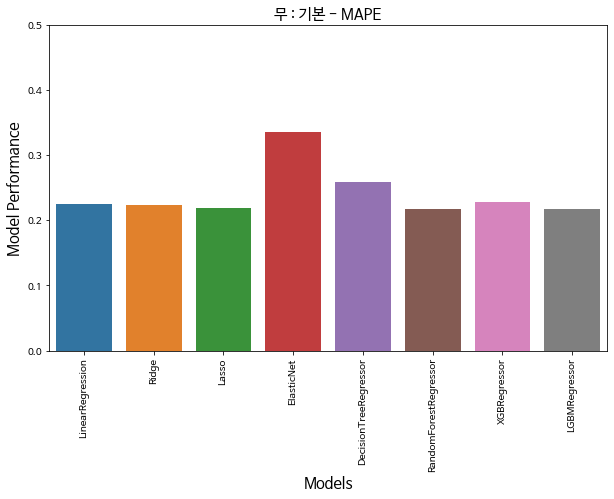

None

(1159, 16) (1159,) (313, 16) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 193.17it/s]

1 FOLDS: LinearRegression MAPE: 0.1839
2 FOLDS: LinearRegression MAPE: 0.3047
3 FOLDS: LinearRegression MAPE: 0.2310
4 FOLDS: LinearRegression MAPE: 0.2263
5 FOLDS: LinearRegression MAPE: 0.1552

LinearRegression mean MAPE: 0.2202


(1159, 16) (1159,) (313, 16) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 190.35it/s]

1 FOLDS: Ridge MAPE: 0.1844
2 FOLDS: Ridge MAPE: 0.3004
3 FOLDS: Ridge MAPE: 0.2284
4 FOLDS: Ridge MAPE: 0.2225
5 FOLDS: Ridge MAPE: 0.1549

Ridge mean MAPE: 0.2181


(1159, 16) (1159,) (313, 16) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 189.88it/s]

1 FOLDS: Lasso MAPE: 0.1880
2 FOLDS: Lasso MAPE: 0.2684
3 FOLDS: Lasso MAPE: 0.2190
4 FOLDS: Lasso MAPE: 0.2206
5 FOLDS: Lasso MAPE: 0.1584

Lasso mean MAPE: 0.2109


(1159, 16) (1159,) (313, 16) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 215.26it/s]

1 FOLDS: ElasticNet MAPE: 0.1965
2 FOLDS: ElasticNet MAPE: 0.2911
3 FOLDS: ElasticNet MAPE: 0.2322
4 FOLDS: ElasticNet MAPE: 0.2714
5 FOLDS: ElasticNet MAPE: 0.2339

ElasticNet mean MAPE: 0.2450


(1159, 16) (1159,) (313, 16) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 108.03it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2686
2 FOLDS: DecisionTreeRegressor MAPE: 0.3445
3 FOLDS: DecisionTreeRegressor MAPE: 0.2322
4 FOLDS: DecisionTreeRegressor MAPE: 0.3042
5 FOLDS: DecisionTreeRegressor MAPE: 0.1911

DecisionTreeRegressor mean MAPE: 0.2681


(1159, 16) (1159,) (313, 16) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.23it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2327
2 FOLDS: RandomForestRegressor MAPE: 0.2736
3 FOLDS: RandomForestRegressor MAPE: 0.1751
4 FOLDS: RandomForestRegressor MAPE: 0.2611
5 FOLDS: RandomForestRegressor MAPE: 0.1743

RandomForestRegressor mean MAPE: 0.2234
(1159, 16) (1159,) (313, 16) (313,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.32it/s]

[08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.09it/s]


[08:30:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2371
2 FOLDS: XGBRegressor MAPE: 0.2912
3 FOLDS: XGBRegressor MAPE: 0.1942
4 FOLDS: XGBRegressor MAPE: 0.2563
5 FOLDS: XGBRegressor MAPE: 0.1726

XGBRegressor mean MAPE: 0.2303
(1159, 16) (1159,) (313, 16) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.38it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2635
2 FOLDS: LGBMRegressor MAPE: 0.2621
3 FOLDS: LGBMRegressor MAPE: 0.1687
4 FOLDS: LGBMRegressor MAPE: 0.2511
5 FOLDS: LGBMRegressor MAPE: 0.1693

LGBMRegressor mean MAPE: 0.2229


,Model,Score
0,LinearRegression,0.22
1,Ridge,0.22
2,Lasso,0.21
3,ElasticNet,0.25
4,DecisionTreeRegressor,0.27
5,RandomForestRegressor,0.22
6,XGBRegressor,0.23
7,LGBMRegressor,0.22


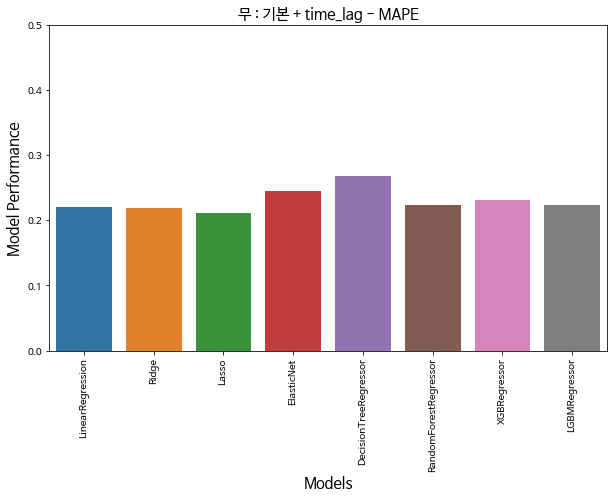

None

(1159, 17) (1159,) (313, 17) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 202.77it/s]

1 FOLDS: LinearRegression MAPE: 0.1252
2 FOLDS: LinearRegression MAPE: 0.1534
3 FOLDS: LinearRegression MAPE: 0.1555
4 FOLDS: LinearRegression MAPE: 0.1516
5 FOLDS: LinearRegression MAPE: 0.1160

LinearRegression mean MAPE: 0.1403


(1159, 17) (1159,) (313, 17) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 197.36it/s]

1 FOLDS: Ridge MAPE: 0.1255
2 FOLDS: Ridge MAPE: 0.1579
3 FOLDS: Ridge MAPE: 0.1556
4 FOLDS: Ridge MAPE: 0.1504
5 FOLDS: Ridge MAPE: 0.1154

Ridge mean MAPE: 0.1409


(1159, 17) (1159,) (313, 17) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 143.95it/s]

1 FOLDS: Lasso MAPE: 0.1230
2 FOLDS: Lasso MAPE: 0.1708
3 FOLDS: Lasso MAPE: 0.1504
4 FOLDS: Lasso MAPE: 0.1515
5 FOLDS: Lasso MAPE: 0.1135

Lasso mean MAPE: 0.1418


(1159, 17) (1159,) (313, 17) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 190.50it/s]

1 FOLDS: ElasticNet MAPE: 0.2078
2 FOLDS: ElasticNet MAPE: 0.2939
3 FOLDS: ElasticNet MAPE: 0.2326
4 FOLDS: ElasticNet MAPE: 0.3005
5 FOLDS: ElasticNet MAPE: 0.3027

ElasticNet mean MAPE: 0.2675


(1159, 17) (1159,) (313, 17) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 126.36it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2287
2 FOLDS: DecisionTreeRegressor MAPE: 0.2695
3 FOLDS: DecisionTreeRegressor MAPE: 0.1928
4 FOLDS: DecisionTreeRegressor MAPE: 0.2089
5 FOLDS: DecisionTreeRegressor MAPE: 0.1721

DecisionTreeRegressor mean MAPE: 0.2144


(1159, 17) (1159,) (313, 17) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.82it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1852
2 FOLDS: RandomForestRegressor MAPE: 0.2085
3 FOLDS: RandomForestRegressor MAPE: 0.1403
4 FOLDS: RandomForestRegressor MAPE: 0.1684
5 FOLDS: RandomForestRegressor MAPE: 0.1303

RandomForestRegressor mean MAPE: 0.1665
(1159, 17) (1159,) (313, 17) (313,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.07it/s]

[08:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.91it/s]


[08:30:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1635
2 FOLDS: XGBRegressor MAPE: 0.2224
3 FOLDS: XGBRegressor MAPE: 0.1386
4 FOLDS: XGBRegressor MAPE: 0.1831
5 FOLDS: XGBRegressor MAPE: 0.1552

XGBRegressor mean MAPE: 0.1726
(1159, 17) (1159,) (313, 17) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.58it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1688
2 FOLDS: LGBMRegressor MAPE: 0.2188
3 FOLDS: LGBMRegressor MAPE: 0.1407
4 FOLDS: LGBMRegressor MAPE: 0.1678
5 FOLDS: LGBMRegressor MAPE: 0.1231

LGBMRegressor mean MAPE: 0.1638


,Model,Score
0,LinearRegression,0.14
1,Ridge,0.14
2,Lasso,0.14
3,ElasticNet,0.27
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.17
6,XGBRegressor,0.17
7,LGBMRegressor,0.16


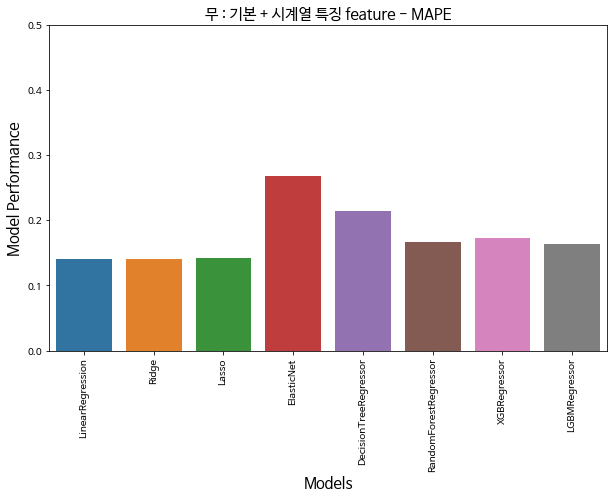

None

(1159, 24) (1159,) (313, 24) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.08it/s]

1 FOLDS: LinearRegression MAPE: 0.4276
2 FOLDS: LinearRegression MAPE: 0.7921
3 FOLDS: LinearRegression MAPE: 0.2502
4 FOLDS: LinearRegression MAPE: 0.5129
5 FOLDS: LinearRegression MAPE: 0.1404

LinearRegression mean MAPE: 0.4246


(1159, 24) (1159,) (313, 24) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 181.31it/s]

1 FOLDS: Ridge MAPE: 0.4172
2 FOLDS: Ridge MAPE: 0.6211
3 FOLDS: Ridge MAPE: 0.2454
4 FOLDS: Ridge MAPE: 0.4643
5 FOLDS: Ridge MAPE: 0.1987

Ridge mean MAPE: 0.3893


(1159, 24) (1159,) (313, 24) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.26it/s]

1 FOLDS: Lasso MAPE: 0.4361
2 FOLDS: Lasso MAPE: 0.4544
3 FOLDS: Lasso MAPE: 0.2312
4 FOLDS: Lasso MAPE: 0.2998
5 FOLDS: Lasso MAPE: 0.2133

Lasso mean MAPE: 0.3270


(1159, 24) (1159,) (313, 24) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 186.93it/s]

1 FOLDS: ElasticNet MAPE: 0.2869
2 FOLDS: ElasticNet MAPE: 0.3646
3 FOLDS: ElasticNet MAPE: 0.2860
4 FOLDS: ElasticNet MAPE: 0.3838
5 FOLDS: ElasticNet MAPE: 0.4738

ElasticNet mean MAPE: 0.3590


(1159, 24) (1159,) (313, 24) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 100.83it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.4790
2 FOLDS: DecisionTreeRegressor MAPE: 0.5106
3 FOLDS: DecisionTreeRegressor MAPE: 0.2703
4 FOLDS: DecisionTreeRegressor MAPE: 0.3228
5 FOLDS: DecisionTreeRegressor MAPE: 0.3571

DecisionTreeRegressor mean MAPE: 0.3880


(1159, 24) (1159,) (313, 24) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.12it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.3785
2 FOLDS: RandomForestRegressor MAPE: 0.2545
3 FOLDS: RandomForestRegressor MAPE: 0.1713
4 FOLDS: RandomForestRegressor MAPE: 0.2603
5 FOLDS: RandomForestRegressor MAPE: 0.2340

RandomForestRegressor mean MAPE: 0.2597
(1159, 24) (1159,) (313, 24) (313,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 18.33it/s]

[08:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.33it/s]


[08:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.4740
2 FOLDS: XGBRegressor MAPE: 0.3503
3 FOLDS: XGBRegressor MAPE: 0.2183
4 FOLDS: XGBRegressor MAPE: 0.3068
5 FOLDS: XGBRegressor MAPE: 0.3417

XGBRegressor mean MAPE: 0.3382
(1159, 24) (1159,) (313, 24) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.34it/s]

1 FOLDS: LGBMRegressor MAPE: 0.4591
2 FOLDS: LGBMRegressor MAPE: 0.2152
3 FOLDS: LGBMRegressor MAPE: 0.1984
4 FOLDS: LGBMRegressor MAPE: 0.2774
5 FOLDS: LGBMRegressor MAPE: 0.3219

LGBMRegressor mean MAPE: 0.2944


,Model,Score
0,LinearRegression,0.42
1,Ridge,0.39
2,Lasso,0.33
3,ElasticNet,0.36
4,DecisionTreeRegressor,0.39
5,RandomForestRegressor,0.26
6,XGBRegressor,0.34
7,LGBMRegressor,0.29


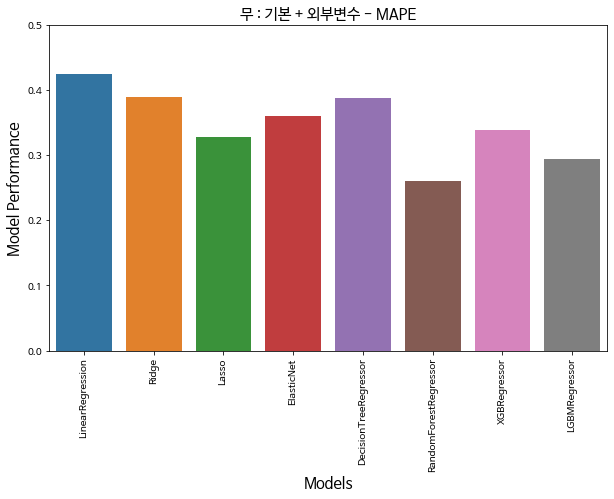

None

(1159, 26) (1159,) (313, 26) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 170.10it/s]

1 FOLDS: LinearRegression MAPE: 0.0944
2 FOLDS: LinearRegression MAPE: 0.1356
3 FOLDS: LinearRegression MAPE: 0.1303
4 FOLDS: LinearRegression MAPE: 0.1229
5 FOLDS: LinearRegression MAPE: 0.0841

LinearRegression mean MAPE: 0.1134


(1159, 26) (1159,) (313, 26) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 142.42it/s]

1 FOLDS: Ridge MAPE: 0.1005
2 FOLDS: Ridge MAPE: 0.1436
3 FOLDS: Ridge MAPE: 0.1269
4 FOLDS: Ridge MAPE: 0.1219
5 FOLDS: Ridge MAPE: 0.0852

Ridge mean MAPE: 0.1156


(1159, 26) (1159,) (313, 26) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 108.94it/s]

1 FOLDS: Lasso MAPE: 0.0968
2 FOLDS: Lasso MAPE: 0.1263
3 FOLDS: Lasso MAPE: 0.1256
4 FOLDS: Lasso MAPE: 0.1166
5 FOLDS: Lasso MAPE: 0.0916

Lasso mean MAPE: 0.1114


(1159, 26) (1159,) (313, 26) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 152.01it/s]

1 FOLDS: ElasticNet MAPE: 0.1810
2 FOLDS: ElasticNet MAPE: 0.2654
3 FOLDS: ElasticNet MAPE: 0.2111
4 FOLDS: ElasticNet MAPE: 0.2448
5 FOLDS: ElasticNet MAPE: 0.2083

ElasticNet mean MAPE: 0.2221


(1159, 26) (1159,) (313, 26) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 95.81it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2212
2 FOLDS: DecisionTreeRegressor MAPE: 0.2859
3 FOLDS: DecisionTreeRegressor MAPE: 0.1959
4 FOLDS: DecisionTreeRegressor MAPE: 0.2435
5 FOLDS: DecisionTreeRegressor MAPE: 0.1446

DecisionTreeRegressor mean MAPE: 0.2182


(1159, 26) (1159,) (313, 26) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.72it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1981
2 FOLDS: RandomForestRegressor MAPE: 0.2068
3 FOLDS: RandomForestRegressor MAPE: 0.1411
4 FOLDS: RandomForestRegressor MAPE: 0.1550
5 FOLDS: RandomForestRegressor MAPE: 0.1266

RandomForestRegressor mean MAPE: 0.1655
(1159, 26) (1159,) (313, 26) (313,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 17.02it/s]

[08:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.06it/s]

[08:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.70it/s]


1 FOLDS: XGBRegressor MAPE: 0.2115
2 FOLDS: XGBRegressor MAPE: 0.2005
3 FOLDS: XGBRegressor MAPE: 0.1358
4 FOLDS: XGBRegressor MAPE: 0.1619
5 FOLDS: XGBRegressor MAPE: 0.1437

XGBRegressor mean MAPE: 0.1707
(1159, 26) (1159,) (313, 26) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.81it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1974
2 FOLDS: LGBMRegressor MAPE: 0.1677
3 FOLDS: LGBMRegressor MAPE: 0.1314
4 FOLDS: LGBMRegressor MAPE: 0.1605
5 FOLDS: LGBMRegressor MAPE: 0.1302

LGBMRegressor mean MAPE: 0.1574


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.12
2,Lasso,0.11
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.22
5,RandomForestRegressor,0.17
6,XGBRegressor,0.17
7,LGBMRegressor,0.16


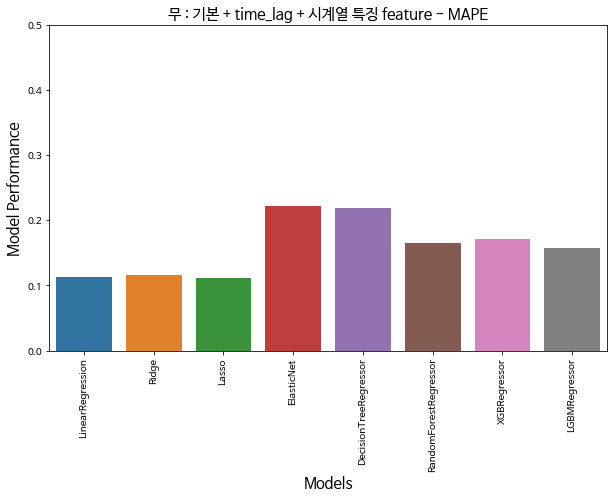

None

(1159, 34) (1159,) (313, 34) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 152.48it/s]

1 FOLDS: LinearRegression MAPE: 0.2338
2 FOLDS: LinearRegression MAPE: 0.3094
3 FOLDS: LinearRegression MAPE: 0.1804
4 FOLDS: LinearRegression MAPE: 0.3416
5 FOLDS: LinearRegression MAPE: 0.1298

LinearRegression mean MAPE: 0.2390


(1159, 34) (1159,) (313, 34) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 165.06it/s]

1 FOLDS: Ridge MAPE: 0.2118
2 FOLDS: Ridge MAPE: 0.2602
3 FOLDS: Ridge MAPE: 0.1778
4 FOLDS: Ridge MAPE: 0.2946
5 FOLDS: Ridge MAPE: 0.1413

Ridge mean MAPE: 0.2171


(1159, 34) (1159,) (313, 34) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 104.23it/s]

1 FOLDS: Lasso MAPE: 0.1929
2 FOLDS: Lasso MAPE: 0.1790
3 FOLDS: Lasso MAPE: 0.1603
4 FOLDS: Lasso MAPE: 0.1678
5 FOLDS: Lasso MAPE: 0.1111

Lasso mean MAPE: 0.1622


(1159, 34) (1159,) (313, 34) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.62it/s]

1 FOLDS: ElasticNet MAPE: 0.2467
2 FOLDS: ElasticNet MAPE: 0.2993
3 FOLDS: ElasticNet MAPE: 0.2308
4 FOLDS: ElasticNet MAPE: 0.2989
5 FOLDS: ElasticNet MAPE: 0.3477

ElasticNet mean MAPE: 0.2847


(1159, 34) (1159,) (313, 34) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 84.77it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2558
2 FOLDS: DecisionTreeRegressor MAPE: 0.3185
3 FOLDS: DecisionTreeRegressor MAPE: 0.1951
4 FOLDS: DecisionTreeRegressor MAPE: 0.2841
5 FOLDS: DecisionTreeRegressor MAPE: 0.1631

DecisionTreeRegressor mean MAPE: 0.2433


(1159, 34) (1159,) (313, 34) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.78it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2553
2 FOLDS: RandomForestRegressor MAPE: 0.2017
3 FOLDS: RandomForestRegressor MAPE: 0.1459
4 FOLDS: RandomForestRegressor MAPE: 0.2032
5 FOLDS: RandomForestRegressor MAPE: 0.1259

RandomForestRegressor mean MAPE: 0.1864
(1159, 34) (1159,) (313, 34) (313,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 17.60it/s]

[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.61it/s]

[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.67it/s]


1 FOLDS: XGBRegressor MAPE: 0.3790
2 FOLDS: XGBRegressor MAPE: 0.2283
3 FOLDS: XGBRegressor MAPE: 0.1535
4 FOLDS: XGBRegressor MAPE: 0.2296
5 FOLDS: XGBRegressor MAPE: 0.1450

XGBRegressor mean MAPE: 0.2271
(1159, 34) (1159,) (313, 34) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.38it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2327
2 FOLDS: LGBMRegressor MAPE: 0.2138
3 FOLDS: LGBMRegressor MAPE: 0.1389
4 FOLDS: LGBMRegressor MAPE: 0.1877
5 FOLDS: LGBMRegressor MAPE: 0.1366

LGBMRegressor mean MAPE: 0.1820


,Model,Score
0,LinearRegression,0.24
1,Ridge,0.22
2,Lasso,0.16
3,ElasticNet,0.28
4,DecisionTreeRegressor,0.24
5,RandomForestRegressor,0.19
6,XGBRegressor,0.23
7,LGBMRegressor,0.18


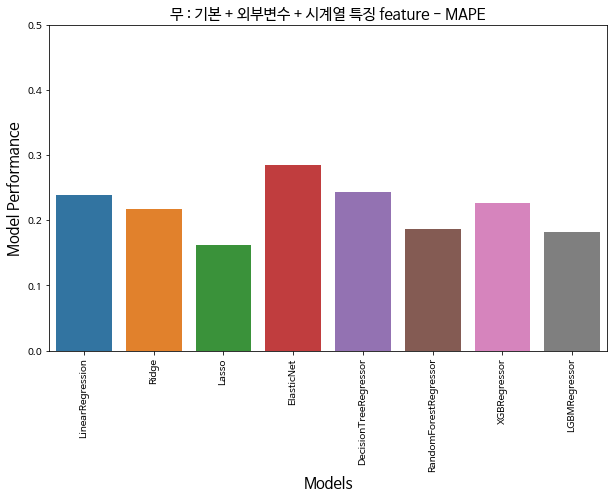

None

(1159, 33) (1159,) (313, 33) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 135.60it/s]

1 FOLDS: LinearRegression MAPE: 0.4671
2 FOLDS: LinearRegression MAPE: 0.7799
3 FOLDS: LinearRegression MAPE: 0.2421
4 FOLDS: LinearRegression MAPE: 0.5135
5 FOLDS: LinearRegression MAPE: 0.1441

LinearRegression mean MAPE: 0.4293


(1159, 33) (1159,) (313, 33) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 162.99it/s]

1 FOLDS: Ridge MAPE: 0.4426
2 FOLDS: Ridge MAPE: 0.5942
3 FOLDS: Ridge MAPE: 0.2373
4 FOLDS: Ridge MAPE: 0.4569
5 FOLDS: Ridge MAPE: 0.1899

Ridge mean MAPE: 0.3842


(1159, 33) (1159,) (313, 33) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 125.03it/s]

1 FOLDS: Lasso MAPE: 0.4598
2 FOLDS: Lasso MAPE: 0.4019
3 FOLDS: Lasso MAPE: 0.2238
4 FOLDS: Lasso MAPE: 0.3023
5 FOLDS: Lasso MAPE: 0.1756

Lasso mean MAPE: 0.3127


(1159, 33) (1159,) (313, 33) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.98it/s]

1 FOLDS: ElasticNet MAPE: 0.2253
2 FOLDS: ElasticNet MAPE: 0.2843
3 FOLDS: ElasticNet MAPE: 0.2255
4 FOLDS: ElasticNet MAPE: 0.2682
5 FOLDS: ElasticNet MAPE: 0.2573

ElasticNet mean MAPE: 0.2521


(1159, 33) (1159,) (313, 33) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 74.40it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.5125
2 FOLDS: DecisionTreeRegressor MAPE: 0.4959
3 FOLDS: DecisionTreeRegressor MAPE: 0.2737
4 FOLDS: DecisionTreeRegressor MAPE: 0.2850
5 FOLDS: DecisionTreeRegressor MAPE: 0.3958

DecisionTreeRegressor mean MAPE: 0.3926


(1159, 33) (1159,) (313, 33) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.3385
2 FOLDS: RandomForestRegressor MAPE: 0.2511
3 FOLDS: RandomForestRegressor MAPE: 0.1713
4 FOLDS: RandomForestRegressor MAPE: 0.2524
5 FOLDS: RandomForestRegressor MAPE: 0.2050

RandomForestRegressor mean MAPE: 0.2436
(1159, 33) (1159,) (313, 33) (313,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 17.36it/s]

[08:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.03it/s]

[08:32:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.38it/s]


1 FOLDS: XGBRegressor MAPE: 0.4236
2 FOLDS: XGBRegressor MAPE: 0.3139
3 FOLDS: XGBRegressor MAPE: 0.2078
4 FOLDS: XGBRegressor MAPE: 0.2888
5 FOLDS: XGBRegressor MAPE: 0.2709

XGBRegressor mean MAPE: 0.3010
(1159, 33) (1159,) (313, 33) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.28it/s]

1 FOLDS: LGBMRegressor MAPE: 0.4697
2 FOLDS: LGBMRegressor MAPE: 0.2373
3 FOLDS: LGBMRegressor MAPE: 0.1775
4 FOLDS: LGBMRegressor MAPE: 0.2671
5 FOLDS: LGBMRegressor MAPE: 0.2658

LGBMRegressor mean MAPE: 0.2835


,Model,Score
0,LinearRegression,0.43
1,Ridge,0.38
2,Lasso,0.31
3,ElasticNet,0.25
4,DecisionTreeRegressor,0.39
5,RandomForestRegressor,0.24
6,XGBRegressor,0.30
7,LGBMRegressor,0.28


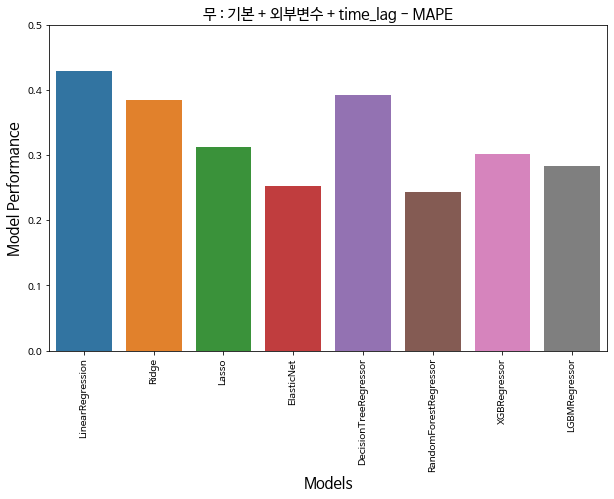

None

(1159, 43) (1159,) (313, 43) (313,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 129.03it/s]

1 FOLDS: LinearRegression MAPE: 0.2422
2 FOLDS: LinearRegression MAPE: 0.3400
3 FOLDS: LinearRegression MAPE: 0.1339
4 FOLDS: LinearRegression MAPE: 0.2259
5 FOLDS: LinearRegression MAPE: 0.0919

LinearRegression mean MAPE: 0.2068


(1159, 43) (1159,) (313, 43) (313,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 148.08it/s]

1 FOLDS: Ridge MAPE: 0.2047
2 FOLDS: Ridge MAPE: 0.2784
3 FOLDS: Ridge MAPE: 0.1321
4 FOLDS: Ridge MAPE: 0.2078
5 FOLDS: Ridge MAPE: 0.1063

Ridge mean MAPE: 0.1858


(1159, 43) (1159,) (313, 43) (313,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 84.04it/s]

1 FOLDS: Lasso MAPE: 0.1834
2 FOLDS: Lasso MAPE: 0.1442
3 FOLDS: Lasso MAPE: 0.1242
4 FOLDS: Lasso MAPE: 0.1151
5 FOLDS: Lasso MAPE: 0.0925

Lasso mean MAPE: 0.1319


(1159, 43) (1159,) (313, 43) (313,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 134.49it/s]

1 FOLDS: ElasticNet MAPE: 0.2080
2 FOLDS: ElasticNet MAPE: 0.2592
3 FOLDS: ElasticNet MAPE: 0.2043
4 FOLDS: ElasticNet MAPE: 0.2398
5 FOLDS: ElasticNet MAPE: 0.2303

ElasticNet mean MAPE: 0.2283


(1159, 43) (1159,) (313, 43) (313,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 64.91it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2323
2 FOLDS: DecisionTreeRegressor MAPE: 0.2871
3 FOLDS: DecisionTreeRegressor MAPE: 0.2076
4 FOLDS: DecisionTreeRegressor MAPE: 0.2677
5 FOLDS: DecisionTreeRegressor MAPE: 0.1513

DecisionTreeRegressor mean MAPE: 0.2292


(1159, 43) (1159,) (313, 43) (313,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2316
2 FOLDS: RandomForestRegressor MAPE: 0.2194
3 FOLDS: RandomForestRegressor MAPE: 0.1398
4 FOLDS: RandomForestRegressor MAPE: 0.1847
5 FOLDS: RandomForestRegressor MAPE: 0.1270

RandomForestRegressor mean MAPE: 0.1805
(1159, 43) (1159,) (313, 43) (313,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 13.62it/s]

[08:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.43it/s]

[08:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:33:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.74it/s]


1 FOLDS: XGBRegressor MAPE: 0.3595
2 FOLDS: XGBRegressor MAPE: 0.2211
3 FOLDS: XGBRegressor MAPE: 0.1559
4 FOLDS: XGBRegressor MAPE: 0.2158
5 FOLDS: XGBRegressor MAPE: 0.1530

XGBRegressor mean MAPE: 0.2210
(1159, 43) (1159,) (313, 43) (313,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.79it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2755
2 FOLDS: LGBMRegressor MAPE: 0.1948
3 FOLDS: LGBMRegressor MAPE: 0.1337
4 FOLDS: LGBMRegressor MAPE: 0.1927
5 FOLDS: LGBMRegressor MAPE: 0.1348

LGBMRegressor mean MAPE: 0.1863


,Model,Score
0,LinearRegression,0.21
1,Ridge,0.19
2,Lasso,0.13
3,ElasticNet,0.23
4,DecisionTreeRegressor,0.23
5,RandomForestRegressor,0.18
6,XGBRegressor,0.22
7,LGBMRegressor,0.19


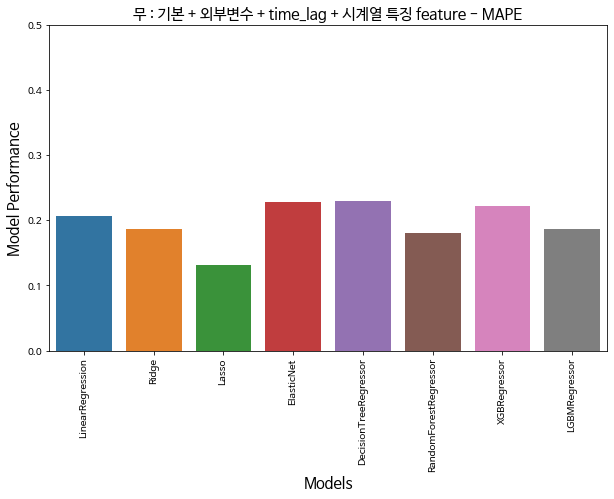

None

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
display(modeling1('무')) # 기본 
display(modeling2('무')) # 기본 + time_lag
display(modeling3('무')) # 기본 + 시계열 특징 feature
display(modeling4('무')) # 기본 + 외부변수
display(modeling5('무')) # 기본 + time_lag + 시계열 특징 feature
display(modeling6('무')) # 기본 + 외부변수 + 시계열 특징 feature
display(modeling7('무')) # 기본 + 외부변수 + time_lag
display(modeling8('무')) # 기본 + 외부변수 + time_lag + 시계열 특징 feature

## 배추

(1159, 7) (1159,) (314, 7) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 198.32it/s]

1 FOLDS: LinearRegression MAPE: 0.1723
2 FOLDS: LinearRegression MAPE: 0.2472
3 FOLDS: LinearRegression MAPE: 0.1537
4 FOLDS: LinearRegression MAPE: 0.2057
5 FOLDS: LinearRegression MAPE: 0.1869

LinearRegression mean MAPE: 0.1932


(1159, 7) (1159,) (314, 7) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 224.59it/s]

1 FOLDS: Ridge MAPE: 0.1695
2 FOLDS: Ridge MAPE: 0.2496
3 FOLDS: Ridge MAPE: 0.1521
4 FOLDS: Ridge MAPE: 0.2051
5 FOLDS: Ridge MAPE: 0.1871

Ridge mean MAPE: 0.1927


(1159, 7) (1159,) (314, 7) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 214.58it/s]

1 FOLDS: Lasso MAPE: 0.1688
2 FOLDS: Lasso MAPE: 0.2543
3 FOLDS: Lasso MAPE: 0.1503
4 FOLDS: Lasso MAPE: 0.2047
5 FOLDS: Lasso MAPE: 0.1901

Lasso mean MAPE: 0.1936


(1159, 7) (1159,) (314, 7) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 240.49it/s]

1 FOLDS: ElasticNet MAPE: 0.1582
2 FOLDS: ElasticNet MAPE: 0.4780
3 FOLDS: ElasticNet MAPE: 0.2588
4 FOLDS: ElasticNet MAPE: 0.2909
5 FOLDS: ElasticNet MAPE: 0.3193

ElasticNet mean MAPE: 0.3010


(1159, 7) (1159,) (314, 7) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 164.39it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2133
2 FOLDS: DecisionTreeRegressor MAPE: 0.4280
3 FOLDS: DecisionTreeRegressor MAPE: 0.2584
4 FOLDS: DecisionTreeRegressor MAPE: 0.2577
5 FOLDS: DecisionTreeRegressor MAPE: 0.2411

DecisionTreeRegressor mean MAPE: 0.2797


(1159, 7) (1159,) (314, 7) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.79it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2038
2 FOLDS: RandomForestRegressor MAPE: 0.4040
3 FOLDS: RandomForestRegressor MAPE: 0.1749
4 FOLDS: RandomForestRegressor MAPE: 0.2000
5 FOLDS: RandomForestRegressor MAPE: 0.1540

RandomForestRegressor mean MAPE: 0.2273
(1159, 7) (1159,) (314, 7) (314,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 27.33it/s]

[08:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:46:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2788
2 FOLDS: XGBRegressor MAPE: 0.3031
3 FOLDS: XGBRegressor MAPE: 0.1553
4 FOLDS: XGBRegressor MAPE: 0.2649
5 FOLDS: XGBRegressor MAPE: 0.1733

XGBRegressor mean MAPE: 0.2351


(1159, 7) (1159,) (314, 7) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 20.86it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2162
2 FOLDS: LGBMRegressor MAPE: 0.4054
3 FOLDS: LGBMRegressor MAPE: 0.1631
4 FOLDS: LGBMRegressor MAPE: 0.2668
5 FOLDS: LGBMRegressor MAPE: 0.1678

LGBMRegressor mean MAPE: 0.2438


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.30
4,DecisionTreeRegressor,0.28
5,RandomForestRegressor,0.23
6,XGBRegressor,0.24
7,LGBMRegressor,0.24


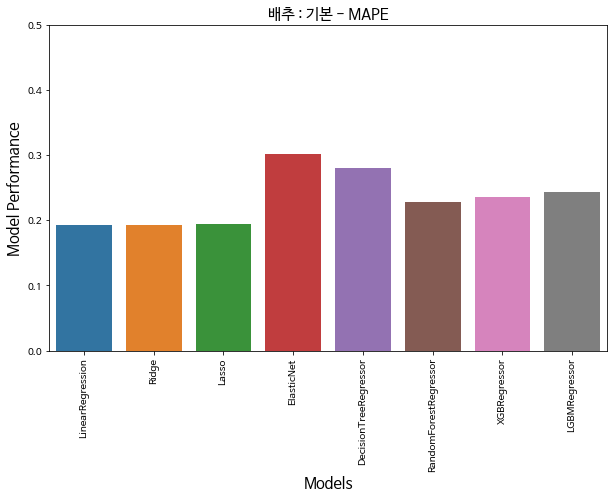

(1159, 16) (1159,) (314, 16) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 193.67it/s]

1 FOLDS: LinearRegression MAPE: 0.1685
2 FOLDS: LinearRegression MAPE: 0.2455
3 FOLDS: LinearRegression MAPE: 0.1548
4 FOLDS: LinearRegression MAPE: 0.2062
5 FOLDS: LinearRegression MAPE: 0.1825

LinearRegression mean MAPE: 0.1915


(1159, 16) (1159,) (314, 16) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 209.67it/s]

1 FOLDS: Ridge MAPE: 0.1656
2 FOLDS: Ridge MAPE: 0.2470
3 FOLDS: Ridge MAPE: 0.1530
4 FOLDS: Ridge MAPE: 0.2051
5 FOLDS: Ridge MAPE: 0.1822

Ridge mean MAPE: 0.1906


(1159, 16) (1159,) (314, 16) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.02it/s]

1 FOLDS: Lasso MAPE: 0.1650
2 FOLDS: Lasso MAPE: 0.2509
3 FOLDS: Lasso MAPE: 0.1511
4 FOLDS: Lasso MAPE: 0.2040
5 FOLDS: Lasso MAPE: 0.1842

Lasso mean MAPE: 0.1911


(1159, 16) (1159,) (314, 16) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 189.18it/s]

1 FOLDS: ElasticNet MAPE: 0.1561
2 FOLDS: ElasticNet MAPE: 0.3894
3 FOLDS: ElasticNet MAPE: 0.2028
4 FOLDS: ElasticNet MAPE: 0.2427
5 FOLDS: ElasticNet MAPE: 0.2251

ElasticNet mean MAPE: 0.2432


(1159, 16) (1159,) (314, 16) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 104.77it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2556
2 FOLDS: DecisionTreeRegressor MAPE: 0.4582
3 FOLDS: DecisionTreeRegressor MAPE: 0.2063
4 FOLDS: DecisionTreeRegressor MAPE: 0.2725
5 FOLDS: DecisionTreeRegressor MAPE: 0.2049

DecisionTreeRegressor mean MAPE: 0.2795


(1159, 16) (1159,) (314, 16) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.19it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2059
2 FOLDS: RandomForestRegressor MAPE: 0.3837
3 FOLDS: RandomForestRegressor MAPE: 0.1489
4 FOLDS: RandomForestRegressor MAPE: 0.2048
5 FOLDS: RandomForestRegressor MAPE: 0.1693

RandomForestRegressor mean MAPE: 0.2225
(1159, 16) (1159,) (314, 16) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.83it/s]

[08:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.34it/s]


[08:47:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2182
2 FOLDS: XGBRegressor MAPE: 0.3525
3 FOLDS: XGBRegressor MAPE: 0.1446
4 FOLDS: XGBRegressor MAPE: 0.2408
5 FOLDS: XGBRegressor MAPE: 0.1982

XGBRegressor mean MAPE: 0.2309
(1159, 16) (1159,) (314, 16) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.46it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1757
2 FOLDS: LGBMRegressor MAPE: 0.4115
3 FOLDS: LGBMRegressor MAPE: 0.1698
4 FOLDS: LGBMRegressor MAPE: 0.2361
5 FOLDS: LGBMRegressor MAPE: 0.1784

LGBMRegressor mean MAPE: 0.2343


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.24
4,DecisionTreeRegressor,0.28
5,RandomForestRegressor,0.22
6,XGBRegressor,0.23
7,LGBMRegressor,0.23


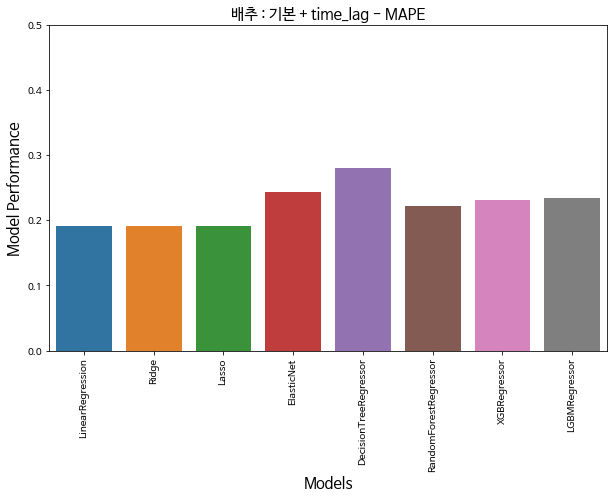

(1159, 17) (1159,) (314, 17) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 196.77it/s]

1 FOLDS: LinearRegression MAPE: 0.1792
2 FOLDS: LinearRegression MAPE: 0.1985
3 FOLDS: LinearRegression MAPE: 0.1262
4 FOLDS: LinearRegression MAPE: 0.1475
5 FOLDS: LinearRegression MAPE: 0.1178

LinearRegression mean MAPE: 0.1538


(1159, 17) (1159,) (314, 17) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 208.17it/s]

1 FOLDS: Ridge MAPE: 0.1687
2 FOLDS: Ridge MAPE: 0.1999
3 FOLDS: Ridge MAPE: 0.1253
4 FOLDS: Ridge MAPE: 0.1477
5 FOLDS: Ridge MAPE: 0.1179

Ridge mean MAPE: 0.1519


(1159, 17) (1159,) (314, 17) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 107.46it/s]

1 FOLDS: Lasso MAPE: 0.1646
2 FOLDS: Lasso MAPE: 0.2034
3 FOLDS: Lasso MAPE: 0.1221
4 FOLDS: Lasso MAPE: 0.1487
5 FOLDS: Lasso MAPE: 0.1173

Lasso mean MAPE: 0.1512


(1159, 17) (1159,) (314, 17) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.39it/s]

1 FOLDS: ElasticNet MAPE: 0.1369
2 FOLDS: ElasticNet MAPE: 0.3749
3 FOLDS: ElasticNet MAPE: 0.1980
4 FOLDS: ElasticNet MAPE: 0.2360
5 FOLDS: ElasticNet MAPE: 0.2413

ElasticNet mean MAPE: 0.2374


(1159, 17) (1159,) (314, 17) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 129.91it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.4253
2 FOLDS: DecisionTreeRegressor MAPE: 0.3737
3 FOLDS: DecisionTreeRegressor MAPE: 0.1876
4 FOLDS: DecisionTreeRegressor MAPE: 0.2565
5 FOLDS: DecisionTreeRegressor MAPE: 0.1462

DecisionTreeRegressor mean MAPE: 0.2779


(1159, 17) (1159,) (314, 17) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.69it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1487
2 FOLDS: RandomForestRegressor MAPE: 0.3316
3 FOLDS: RandomForestRegressor MAPE: 0.1278
4 FOLDS: RandomForestRegressor MAPE: 0.1729
5 FOLDS: RandomForestRegressor MAPE: 0.1222

RandomForestRegressor mean MAPE: 0.1806
(1159, 17) (1159,) (314, 17) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 24.55it/s]

[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:47:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 17.95it/s]


1 FOLDS: XGBRegressor MAPE: 0.2106
2 FOLDS: XGBRegressor MAPE: 0.2536
3 FOLDS: XGBRegressor MAPE: 0.1380
4 FOLDS: XGBRegressor MAPE: 0.1919
5 FOLDS: XGBRegressor MAPE: 0.1614

XGBRegressor mean MAPE: 0.1911
(1159, 17) (1159,) (314, 17) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.42it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1541
2 FOLDS: LGBMRegressor MAPE: 0.3019
3 FOLDS: LGBMRegressor MAPE: 0.1478
4 FOLDS: LGBMRegressor MAPE: 0.2020
5 FOLDS: LGBMRegressor MAPE: 0.1549

LGBMRegressor mean MAPE: 0.1921


,Model,Score
0,LinearRegression,0.15
1,Ridge,0.15
2,Lasso,0.15
3,ElasticNet,0.24
4,DecisionTreeRegressor,0.28
5,RandomForestRegressor,0.18
6,XGBRegressor,0.19
7,LGBMRegressor,0.19


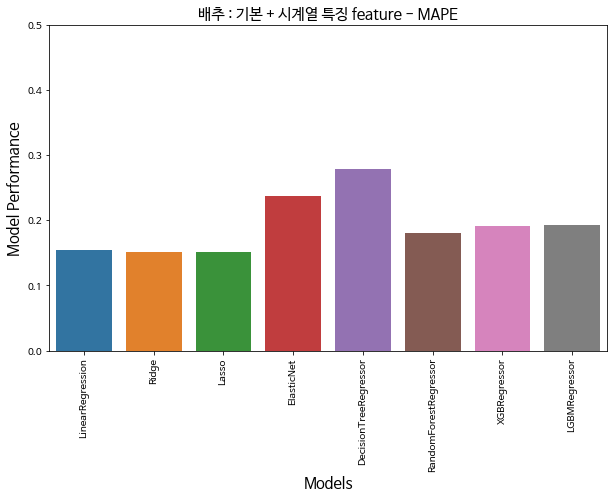

(1159, 24) (1159,) (314, 24) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 177.09it/s]

1 FOLDS: LinearRegression MAPE: 0.3138
2 FOLDS: LinearRegression MAPE: 0.4349
3 FOLDS: LinearRegression MAPE: 0.2169
4 FOLDS: LinearRegression MAPE: 0.4591
5 FOLDS: LinearRegression MAPE: 0.3259

LinearRegression mean MAPE: 0.3501


(1159, 24) (1159,) (314, 24) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 170.83it/s]

1 FOLDS: Ridge MAPE: 0.2787
2 FOLDS: Ridge MAPE: 0.3920
3 FOLDS: Ridge MAPE: 0.2062
4 FOLDS: Ridge MAPE: 0.4307
5 FOLDS: Ridge MAPE: 0.2202

Ridge mean MAPE: 0.3056


(1159, 24) (1159,) (314, 24) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 119.38it/s]

1 FOLDS: Lasso MAPE: 0.2611
2 FOLDS: Lasso MAPE: 0.3005
3 FOLDS: Lasso MAPE: 0.1783
4 FOLDS: Lasso MAPE: 0.3339
5 FOLDS: Lasso MAPE: 0.2105

Lasso mean MAPE: 0.2569


(1159, 24) (1159,) (314, 24) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 178.63it/s]

1 FOLDS: ElasticNet MAPE: 0.1584
2 FOLDS: ElasticNet MAPE: 0.4804
3 FOLDS: ElasticNet MAPE: 0.1785
4 FOLDS: ElasticNet MAPE: 0.2667
5 FOLDS: ElasticNet MAPE: 0.3456

ElasticNet mean MAPE: 0.2859


(1159, 24) (1159,) (314, 24) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 101.80it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2490
2 FOLDS: DecisionTreeRegressor MAPE: 0.3804
3 FOLDS: DecisionTreeRegressor MAPE: 0.2809
4 FOLDS: DecisionTreeRegressor MAPE: 0.2467
5 FOLDS: DecisionTreeRegressor MAPE: 0.2134

DecisionTreeRegressor mean MAPE: 0.2741


(1159, 24) (1159,) (314, 24) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.02it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2175
2 FOLDS: RandomForestRegressor MAPE: 0.3916
3 FOLDS: RandomForestRegressor MAPE: 0.1733
4 FOLDS: RandomForestRegressor MAPE: 0.1903
5 FOLDS: RandomForestRegressor MAPE: 0.1814

RandomForestRegressor mean MAPE: 0.2308
(1159, 24) (1159,) (314, 24) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.49it/s]

[08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.99it/s]


[08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2320
2 FOLDS: XGBRegressor MAPE: 0.3796
3 FOLDS: XGBRegressor MAPE: 0.1756
4 FOLDS: XGBRegressor MAPE: 0.2506
5 FOLDS: XGBRegressor MAPE: 0.1939

XGBRegressor mean MAPE: 0.2463
(1159, 24) (1159,) (314, 24) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.05it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2219
2 FOLDS: LGBMRegressor MAPE: 0.4132
3 FOLDS: LGBMRegressor MAPE: 0.1574
4 FOLDS: LGBMRegressor MAPE: 0.2267
5 FOLDS: LGBMRegressor MAPE: 0.2082

LGBMRegressor mean MAPE: 0.2455


,Model,Score
0,LinearRegression,0.35
1,Ridge,0.31
2,Lasso,0.26
3,ElasticNet,0.29
4,DecisionTreeRegressor,0.27
5,RandomForestRegressor,0.23
6,XGBRegressor,0.25
7,LGBMRegressor,0.25


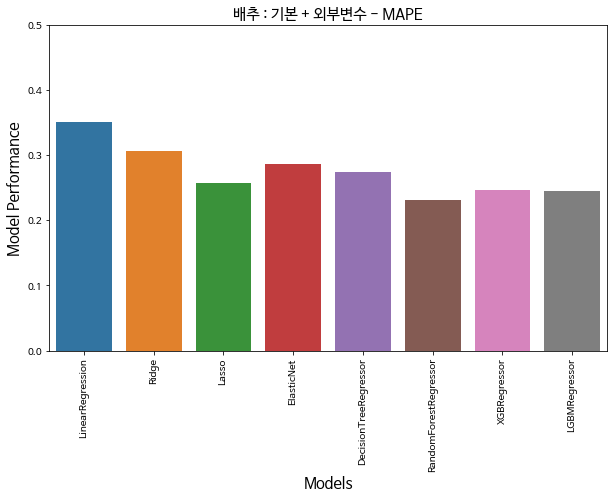

(1159, 26) (1159,) (314, 26) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 150.27it/s]

1 FOLDS: LinearRegression MAPE: 0.1438
2 FOLDS: LinearRegression MAPE: 0.1369
3 FOLDS: LinearRegression MAPE: 0.1169
4 FOLDS: LinearRegression MAPE: 0.1198
5 FOLDS: LinearRegression MAPE: 0.0872

LinearRegression mean MAPE: 0.1209


(1159, 26) (1159,) (314, 26) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.51it/s]

1 FOLDS: Ridge MAPE: 0.1371
2 FOLDS: Ridge MAPE: 0.1409
3 FOLDS: Ridge MAPE: 0.1140
4 FOLDS: Ridge MAPE: 0.1207
5 FOLDS: Ridge MAPE: 0.0878

Ridge mean MAPE: 0.1201


(1159, 26) (1159,) (314, 26) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 74.79it/s]

1 FOLDS: Lasso MAPE: 0.1292
2 FOLDS: Lasso MAPE: 0.1529
3 FOLDS: Lasso MAPE: 0.1166
4 FOLDS: Lasso MAPE: 0.1266
5 FOLDS: Lasso MAPE: 0.0922

Lasso mean MAPE: 0.1235


(1159, 26) (1159,) (314, 26) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 159.13it/s]

1 FOLDS: ElasticNet MAPE: 0.1432
2 FOLDS: ElasticNet MAPE: 0.3486
3 FOLDS: ElasticNet MAPE: 0.1826
4 FOLDS: ElasticNet MAPE: 0.2237
5 FOLDS: ElasticNet MAPE: 0.2053

ElasticNet mean MAPE: 0.2207


(1159, 26) (1159,) (314, 26) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 82.63it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2707
2 FOLDS: DecisionTreeRegressor MAPE: 0.3929
3 FOLDS: DecisionTreeRegressor MAPE: 0.1684
4 FOLDS: DecisionTreeRegressor MAPE: 0.2418
5 FOLDS: DecisionTreeRegressor MAPE: 0.1807

DecisionTreeRegressor mean MAPE: 0.2509


(1159, 26) (1159,) (314, 26) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.79it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1753
2 FOLDS: RandomForestRegressor MAPE: 0.3450
3 FOLDS: RandomForestRegressor MAPE: 0.1433
4 FOLDS: RandomForestRegressor MAPE: 0.1455
5 FOLDS: RandomForestRegressor MAPE: 0.1481

RandomForestRegressor mean MAPE: 0.1914
(1159, 26) (1159,) (314, 26) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.28it/s]

[08:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.21it/s]

[08:48:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.34it/s]


1 FOLDS: XGBRegressor MAPE: 0.1987
2 FOLDS: XGBRegressor MAPE: 0.2981
3 FOLDS: XGBRegressor MAPE: 0.1361
4 FOLDS: XGBRegressor MAPE: 0.1784
5 FOLDS: XGBRegressor MAPE: 0.1465

XGBRegressor mean MAPE: 0.1916
(1159, 26) (1159,) (314, 26) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.19it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1499
2 FOLDS: LGBMRegressor MAPE: 0.3383
3 FOLDS: LGBMRegressor MAPE: 0.1617
4 FOLDS: LGBMRegressor MAPE: 0.1674
5 FOLDS: LGBMRegressor MAPE: 0.1283

LGBMRegressor mean MAPE: 0.1891


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.22
4,DecisionTreeRegressor,0.25
5,RandomForestRegressor,0.19
6,XGBRegressor,0.19
7,LGBMRegressor,0.19


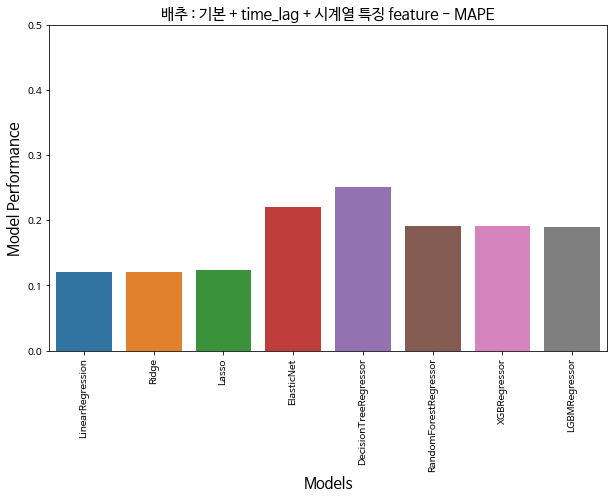

(1159, 34) (1159,) (314, 34) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 153.33it/s]

1 FOLDS: LinearRegression MAPE: 0.3104
2 FOLDS: LinearRegression MAPE: 0.2692
3 FOLDS: LinearRegression MAPE: 0.2675
4 FOLDS: LinearRegression MAPE: 0.3035
5 FOLDS: LinearRegression MAPE: 0.1663

LinearRegression mean MAPE: 0.2634


(1159, 34) (1159,) (314, 34) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.24it/s]

1 FOLDS: Ridge MAPE: 0.2730
2 FOLDS: Ridge MAPE: 0.2453
3 FOLDS: Ridge MAPE: 0.2482
4 FOLDS: Ridge MAPE: 0.2765
5 FOLDS: Ridge MAPE: 0.1486

Ridge mean MAPE: 0.2383


(1159, 34) (1159,) (314, 34) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 70.52it/s]

1 FOLDS: Lasso MAPE: 0.2066
2 FOLDS: Lasso MAPE: 0.2291
3 FOLDS: Lasso MAPE: 0.1714
4 FOLDS: Lasso MAPE: 0.1948
5 FOLDS: Lasso MAPE: 0.1355

Lasso mean MAPE: 0.1875


(1159, 34) (1159,) (314, 34) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 166.64it/s]

1 FOLDS: ElasticNet MAPE: 0.1321
2 FOLDS: ElasticNet MAPE: 0.3763
3 FOLDS: ElasticNet MAPE: 0.1363
4 FOLDS: ElasticNet MAPE: 0.2200
5 FOLDS: ElasticNet MAPE: 0.2607

ElasticNet mean MAPE: 0.2251


(1159, 34) (1159,) (314, 34) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 83.47it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.3468
2 FOLDS: DecisionTreeRegressor MAPE: 0.3297
3 FOLDS: DecisionTreeRegressor MAPE: 0.2026
4 FOLDS: DecisionTreeRegressor MAPE: 0.2520
5 FOLDS: DecisionTreeRegressor MAPE: 0.2125

DecisionTreeRegressor mean MAPE: 0.2687


(1159, 34) (1159,) (314, 34) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.68it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2252
2 FOLDS: RandomForestRegressor MAPE: 0.3183
3 FOLDS: RandomForestRegressor MAPE: 0.1835
4 FOLDS: RandomForestRegressor MAPE: 0.1642
5 FOLDS: RandomForestRegressor MAPE: 0.1617

RandomForestRegressor mean MAPE: 0.2106
(1159, 34) (1159,) (314, 34) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.84it/s]

[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.09it/s]

[08:49:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.32it/s]


1 FOLDS: XGBRegressor MAPE: 0.2295
2 FOLDS: XGBRegressor MAPE: 0.2959
3 FOLDS: XGBRegressor MAPE: 0.2252
4 FOLDS: XGBRegressor MAPE: 0.2134
5 FOLDS: XGBRegressor MAPE: 0.1834

XGBRegressor mean MAPE: 0.2295
(1159, 34) (1159,) (314, 34) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.19it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2364
2 FOLDS: LGBMRegressor MAPE: 0.3358
3 FOLDS: LGBMRegressor MAPE: 0.1463
4 FOLDS: LGBMRegressor MAPE: 0.1920
5 FOLDS: LGBMRegressor MAPE: 0.1774

LGBMRegressor mean MAPE: 0.2176


,Model,Score
0,LinearRegression,0.26
1,Ridge,0.24
2,Lasso,0.19
3,ElasticNet,0.23
4,DecisionTreeRegressor,0.27
5,RandomForestRegressor,0.21
6,XGBRegressor,0.23
7,LGBMRegressor,0.22


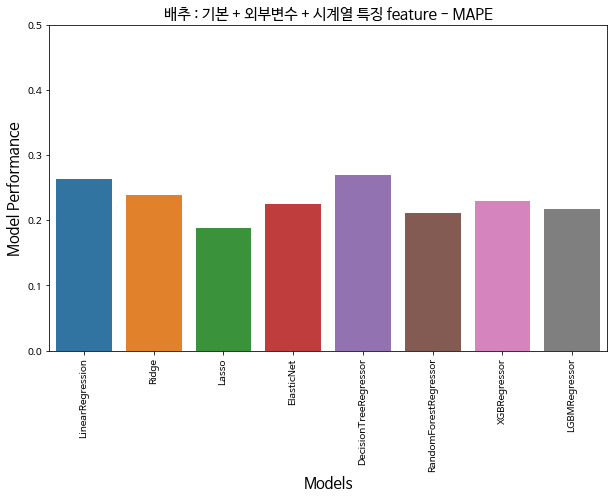

(1159, 33) (1159,) (314, 33) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 146.31it/s]

1 FOLDS: LinearRegression MAPE: 0.3611
2 FOLDS: LinearRegression MAPE: 0.4618
3 FOLDS: LinearRegression MAPE: 0.2127
4 FOLDS: LinearRegression MAPE: 0.4545
5 FOLDS: LinearRegression MAPE: 0.3181

LinearRegression mean MAPE: 0.3616


(1159, 33) (1159,) (314, 33) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 145.26it/s]

1 FOLDS: Ridge MAPE: 0.2820
2 FOLDS: Ridge MAPE: 0.4029
3 FOLDS: Ridge MAPE: 0.2019
4 FOLDS: Ridge MAPE: 0.4268
5 FOLDS: Ridge MAPE: 0.2141

Ridge mean MAPE: 0.3055


(1159, 33) (1159,) (314, 33) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 121.73it/s]

1 FOLDS: Lasso MAPE: 0.2506
2 FOLDS: Lasso MAPE: 0.2961
3 FOLDS: Lasso MAPE: 0.1725
4 FOLDS: Lasso MAPE: 0.3300
5 FOLDS: Lasso MAPE: 0.1996

Lasso mean MAPE: 0.2498


(1159, 33) (1159,) (314, 33) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 152.15it/s]

1 FOLDS: ElasticNet MAPE: 0.1521
2 FOLDS: ElasticNet MAPE: 0.3817
3 FOLDS: ElasticNet MAPE: 0.1470
4 FOLDS: ElasticNet MAPE: 0.2272
5 FOLDS: ElasticNet MAPE: 0.2379

ElasticNet mean MAPE: 0.2292


(1159, 33) (1159,) (314, 33) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 68.88it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.6533
2 FOLDS: DecisionTreeRegressor MAPE: 0.3728
3 FOLDS: DecisionTreeRegressor MAPE: 0.3379
4 FOLDS: DecisionTreeRegressor MAPE: 0.2241
5 FOLDS: DecisionTreeRegressor MAPE: 0.2654

DecisionTreeRegressor mean MAPE: 0.3707


(1159, 33) (1159,) (314, 33) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.43it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2353
2 FOLDS: RandomForestRegressor MAPE: 0.3573
3 FOLDS: RandomForestRegressor MAPE: 0.1827
4 FOLDS: RandomForestRegressor MAPE: 0.1843
5 FOLDS: RandomForestRegressor MAPE: 0.2071

RandomForestRegressor mean MAPE: 0.2333
(1159, 33) (1159,) (314, 33) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]

[08:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 10.59it/s]

[08:50:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.03it/s]


1 FOLDS: XGBRegressor MAPE: 0.2642
2 FOLDS: XGBRegressor MAPE: 0.3315
3 FOLDS: XGBRegressor MAPE: 0.1970
4 FOLDS: XGBRegressor MAPE: 0.2201
5 FOLDS: XGBRegressor MAPE: 0.1830

XGBRegressor mean MAPE: 0.2391
(1159, 33) (1159,) (314, 33) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.70it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2037
2 FOLDS: LGBMRegressor MAPE: 0.3685
3 FOLDS: LGBMRegressor MAPE: 0.1456
4 FOLDS: LGBMRegressor MAPE: 0.2097
5 FOLDS: LGBMRegressor MAPE: 0.2082

LGBMRegressor mean MAPE: 0.2271


,Model,Score
0,LinearRegression,0.36
1,Ridge,0.31
2,Lasso,0.25
3,ElasticNet,0.23
4,DecisionTreeRegressor,0.37
5,RandomForestRegressor,0.23
6,XGBRegressor,0.24
7,LGBMRegressor,0.23


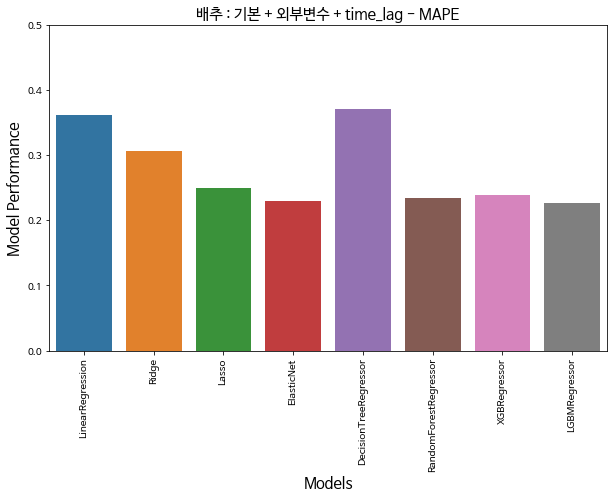

(1159, 43) (1159,) (314, 43) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 131.85it/s]

1 FOLDS: LinearRegression MAPE: 0.2802
2 FOLDS: LinearRegression MAPE: 0.2666
3 FOLDS: LinearRegression MAPE: 0.1557
4 FOLDS: LinearRegression MAPE: 0.2117
5 FOLDS: LinearRegression MAPE: 0.1040

LinearRegression mean MAPE: 0.2036


(1159, 43) (1159,) (314, 43) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 133.39it/s]

1 FOLDS: Ridge MAPE: 0.2666
2 FOLDS: Ridge MAPE: 0.2368
3 FOLDS: Ridge MAPE: 0.1441
4 FOLDS: Ridge MAPE: 0.2008
5 FOLDS: Ridge MAPE: 0.1044

Ridge mean MAPE: 0.1905


(1159, 43) (1159,) (314, 43) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 54.29it/s]

1 FOLDS: Lasso MAPE: 0.2054
2 FOLDS: Lasso MAPE: 0.1785
3 FOLDS: Lasso MAPE: 0.1145
4 FOLDS: Lasso MAPE: 0.1297
5 FOLDS: Lasso MAPE: 0.1019

Lasso mean MAPE: 0.1460


(1159, 43) (1159,) (314, 43) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 160.13it/s]

1 FOLDS: ElasticNet MAPE: 0.1399
2 FOLDS: ElasticNet MAPE: 0.3442
3 FOLDS: ElasticNet MAPE: 0.1331
4 FOLDS: ElasticNet MAPE: 0.2113
5 FOLDS: ElasticNet MAPE: 0.2169

ElasticNet mean MAPE: 0.2091


(1159, 43) (1159,) (314, 43) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 66.21it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.6565
2 FOLDS: DecisionTreeRegressor MAPE: 0.3395
3 FOLDS: DecisionTreeRegressor MAPE: 0.3164
4 FOLDS: DecisionTreeRegressor MAPE: 0.2238
5 FOLDS: DecisionTreeRegressor MAPE: 0.2311

DecisionTreeRegressor mean MAPE: 0.3534


(1159, 43) (1159,) (314, 43) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.27it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2282
2 FOLDS: RandomForestRegressor MAPE: 0.3259
3 FOLDS: RandomForestRegressor MAPE: 0.1561
4 FOLDS: RandomForestRegressor MAPE: 0.1549
5 FOLDS: RandomForestRegressor MAPE: 0.1615

RandomForestRegressor mean MAPE: 0.2053
(1159, 43) (1159,) (314, 43) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.16it/s]

[08:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.48it/s]

[08:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:50:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.55it/s]


1 FOLDS: XGBRegressor MAPE: 0.2645
2 FOLDS: XGBRegressor MAPE: 0.2864
3 FOLDS: XGBRegressor MAPE: 0.1662
4 FOLDS: XGBRegressor MAPE: 0.1979
5 FOLDS: XGBRegressor MAPE: 0.1768

XGBRegressor mean MAPE: 0.2184
(1159, 43) (1159,) (314, 43) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.75it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1796
2 FOLDS: LGBMRegressor MAPE: 0.3257
3 FOLDS: LGBMRegressor MAPE: 0.1415
4 FOLDS: LGBMRegressor MAPE: 0.1699
5 FOLDS: LGBMRegressor MAPE: 0.1635

LGBMRegressor mean MAPE: 0.1960


,Model,Score
0,LinearRegression,0.20
1,Ridge,0.19
2,Lasso,0.15
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.35
5,RandomForestRegressor,0.21
6,XGBRegressor,0.22
7,LGBMRegressor,0.20


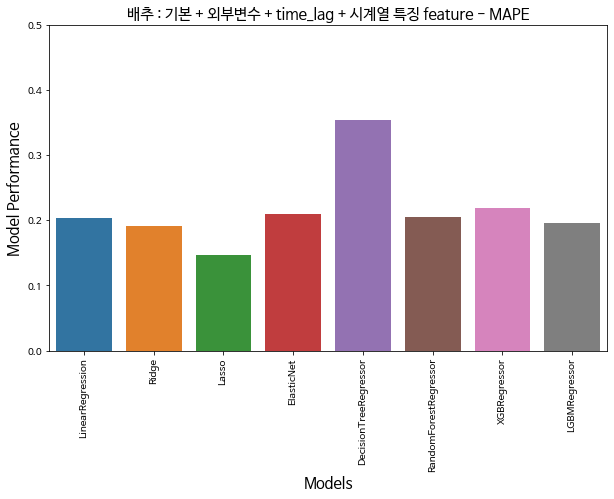

In [ ]:
modeling1('배추')
modeling2('배추')
modeling3('배추')
modeling4('배추')
modeling5('배추')
modeling6('배추')
modeling7('배추')
modeling8('배추')

## 양파

(1156, 7) (1156,) (315, 7) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 253.31it/s]

1 FOLDS: LinearRegression MAPE: 0.0845
2 FOLDS: LinearRegression MAPE: 0.0826
3 FOLDS: LinearRegression MAPE: 0.2266
4 FOLDS: LinearRegression MAPE: 0.0765
5 FOLDS: LinearRegression MAPE: 0.1139

LinearRegression mean MAPE: 0.1168


(1156, 7) (1156,) (315, 7) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 227.91it/s]

1 FOLDS: Ridge MAPE: 0.0840
2 FOLDS: Ridge MAPE: 0.0836
3 FOLDS: Ridge MAPE: 0.2251
4 FOLDS: Ridge MAPE: 0.0773
5 FOLDS: Ridge MAPE: 0.1140

Ridge mean MAPE: 0.1168


(1156, 7) (1156,) (315, 7) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 229.46it/s]

1 FOLDS: Lasso MAPE: 0.0757
2 FOLDS: Lasso MAPE: 0.0886
3 FOLDS: Lasso MAPE: 0.2216
4 FOLDS: Lasso MAPE: 0.0867
5 FOLDS: Lasso MAPE: 0.1133

Lasso mean MAPE: 0.1172


(1156, 7) (1156,) (315, 7) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 220.51it/s]

1 FOLDS: ElasticNet MAPE: 0.0792
2 FOLDS: ElasticNet MAPE: 0.1271
3 FOLDS: ElasticNet MAPE: 0.2888
4 FOLDS: ElasticNet MAPE: 0.3474
5 FOLDS: ElasticNet MAPE: 0.3844

ElasticNet mean MAPE: 0.2454


(1156, 7) (1156,) (315, 7) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.58it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1734
2 FOLDS: DecisionTreeRegressor MAPE: 0.2528
3 FOLDS: DecisionTreeRegressor MAPE: 0.2094
4 FOLDS: DecisionTreeRegressor MAPE: 0.1477
5 FOLDS: DecisionTreeRegressor MAPE: 0.2262

DecisionTreeRegressor mean MAPE: 0.2019


(1156, 7) (1156,) (315, 7) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.81it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1283
2 FOLDS: RandomForestRegressor MAPE: 0.1767
3 FOLDS: RandomForestRegressor MAPE: 0.1367
4 FOLDS: RandomForestRegressor MAPE: 0.1220
5 FOLDS: RandomForestRegressor MAPE: 0.2617

RandomForestRegressor mean MAPE: 0.1651
(1156, 7) (1156,) (315, 7) (315,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 27.03it/s]

[08:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1237
2 FOLDS: XGBRegressor MAPE: 0.1673
3 FOLDS: XGBRegressor MAPE: 0.2290
4 FOLDS: XGBRegressor MAPE: 0.1368
5 FOLDS: XGBRegressor MAPE: 0.2334

XGBRegressor mean MAPE: 0.1780


(1156, 7) (1156,) (315, 7) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 20.98it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1313
2 FOLDS: LGBMRegressor MAPE: 0.2014
3 FOLDS: LGBMRegressor MAPE: 0.2228
4 FOLDS: LGBMRegressor MAPE: 0.1628
5 FOLDS: LGBMRegressor MAPE: 0.2556

LGBMRegressor mean MAPE: 0.1948


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.25
4,DecisionTreeRegressor,0.20
5,RandomForestRegressor,0.17
6,XGBRegressor,0.18
7,LGBMRegressor,0.19


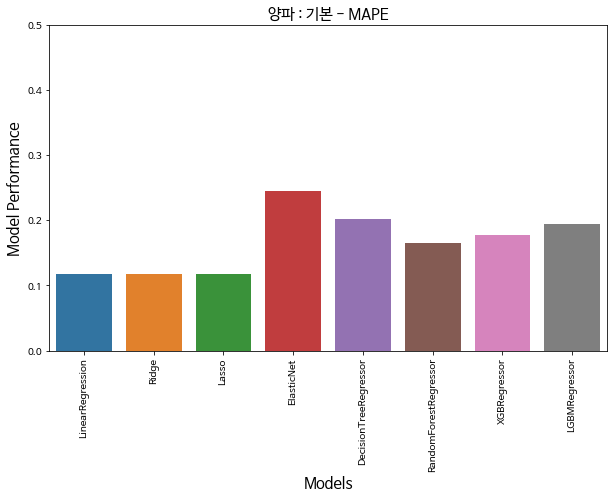

(1156, 16) (1156,) (315, 16) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 198.67it/s]

1 FOLDS: LinearRegression MAPE: 0.0790
2 FOLDS: LinearRegression MAPE: 0.0863
3 FOLDS: LinearRegression MAPE: 0.2283
4 FOLDS: LinearRegression MAPE: 0.0749
5 FOLDS: LinearRegression MAPE: 0.1135

LinearRegression mean MAPE: 0.1164


(1156, 16) (1156,) (315, 16) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 203.30it/s]

1 FOLDS: Ridge MAPE: 0.0806
2 FOLDS: Ridge MAPE: 0.0864
3 FOLDS: Ridge MAPE: 0.2248
4 FOLDS: Ridge MAPE: 0.0749
5 FOLDS: Ridge MAPE: 0.1133

Ridge mean MAPE: 0.1160


(1156, 16) (1156,) (315, 16) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.67it/s]

1 FOLDS: Lasso MAPE: 0.0749
2 FOLDS: Lasso MAPE: 0.0886
3 FOLDS: Lasso MAPE: 0.2184
4 FOLDS: Lasso MAPE: 0.0836
5 FOLDS: Lasso MAPE: 0.1125

Lasso mean MAPE: 0.1156


(1156, 16) (1156,) (315, 16) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 197.34it/s]

1 FOLDS: ElasticNet MAPE: 0.0743
2 FOLDS: ElasticNet MAPE: 0.1012
3 FOLDS: ElasticNet MAPE: 0.1996
4 FOLDS: ElasticNet MAPE: 0.1751
5 FOLDS: ElasticNet MAPE: 0.2046

ElasticNet mean MAPE: 0.1510


(1156, 16) (1156,) (315, 16) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 98.09it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1562
2 FOLDS: DecisionTreeRegressor MAPE: 0.1782
3 FOLDS: DecisionTreeRegressor MAPE: 0.1802
4 FOLDS: DecisionTreeRegressor MAPE: 0.1970
5 FOLDS: DecisionTreeRegressor MAPE: 0.3219

DecisionTreeRegressor mean MAPE: 0.2067


(1156, 16) (1156,) (315, 16) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.17it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2298
2 FOLDS: RandomForestRegressor MAPE: 0.1209
3 FOLDS: RandomForestRegressor MAPE: 0.1466
4 FOLDS: RandomForestRegressor MAPE: 0.0930
5 FOLDS: RandomForestRegressor MAPE: 0.2846

RandomForestRegressor mean MAPE: 0.1750
(1156, 16) (1156,) (315, 16) (315,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.57it/s]

[08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.51it/s]


[08:51:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1113
2 FOLDS: XGBRegressor MAPE: 0.1400
3 FOLDS: XGBRegressor MAPE: 0.2001
4 FOLDS: XGBRegressor MAPE: 0.1209
5 FOLDS: XGBRegressor MAPE: 0.2602

XGBRegressor mean MAPE: 0.1665
(1156, 16) (1156,) (315, 16) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.54it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1273
2 FOLDS: LGBMRegressor MAPE: 0.1822
3 FOLDS: LGBMRegressor MAPE: 0.1832
4 FOLDS: LGBMRegressor MAPE: 0.0979
5 FOLDS: LGBMRegressor MAPE: 0.2518

LGBMRegressor mean MAPE: 0.1685


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.15
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.17
6,XGBRegressor,0.17
7,LGBMRegressor,0.17


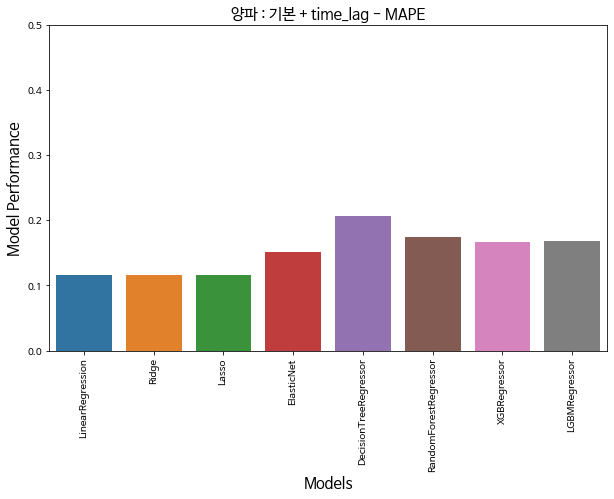

(1156, 17) (1156,) (315, 17) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 176.32it/s]

1 FOLDS: LinearRegression MAPE: 0.0674
2 FOLDS: LinearRegression MAPE: 0.0571
3 FOLDS: LinearRegression MAPE: 0.1366
4 FOLDS: LinearRegression MAPE: 0.0469
5 FOLDS: LinearRegression MAPE: 0.0916

LinearRegression mean MAPE: 0.0799


(1156, 17) (1156,) (315, 17) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 201.81it/s]

1 FOLDS: Ridge MAPE: 0.0611
2 FOLDS: Ridge MAPE: 0.0570
3 FOLDS: Ridge MAPE: 0.1364
4 FOLDS: Ridge MAPE: 0.0472
5 FOLDS: Ridge MAPE: 0.0918

Ridge mean MAPE: 0.0787


(1156, 17) (1156,) (315, 17) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 108.89it/s]

1 FOLDS: Lasso MAPE: 0.0600
2 FOLDS: Lasso MAPE: 0.0591
3 FOLDS: Lasso MAPE: 0.1257
4 FOLDS: Lasso MAPE: 0.0547
5 FOLDS: Lasso MAPE: 0.0893

Lasso mean MAPE: 0.0778


(1156, 17) (1156,) (315, 17) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 191.93it/s]

1 FOLDS: ElasticNet MAPE: 0.0721
2 FOLDS: ElasticNet MAPE: 0.1087
3 FOLDS: ElasticNet MAPE: 0.2417
4 FOLDS: ElasticNet MAPE: 0.2740
5 FOLDS: ElasticNet MAPE: 0.3085

ElasticNet mean MAPE: 0.2010


(1156, 17) (1156,) (315, 17) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 129.88it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2074
2 FOLDS: DecisionTreeRegressor MAPE: 0.2739
3 FOLDS: DecisionTreeRegressor MAPE: 0.1473
4 FOLDS: DecisionTreeRegressor MAPE: 0.0826
5 FOLDS: DecisionTreeRegressor MAPE: 0.2667

DecisionTreeRegressor mean MAPE: 0.1956


(1156, 17) (1156,) (315, 17) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.59it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1725
2 FOLDS: RandomForestRegressor MAPE: 0.1366
3 FOLDS: RandomForestRegressor MAPE: 0.1221
4 FOLDS: RandomForestRegressor MAPE: 0.0630
5 FOLDS: RandomForestRegressor MAPE: 0.2411

RandomForestRegressor mean MAPE: 0.1471
(1156, 17) (1156,) (315, 17) (315,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 22.36it/s]

[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 17.26it/s]


[08:52:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1405
2 FOLDS: XGBRegressor MAPE: 0.1462
3 FOLDS: XGBRegressor MAPE: 0.1623
4 FOLDS: XGBRegressor MAPE: 0.0540
5 FOLDS: XGBRegressor MAPE: 0.2410

XGBRegressor mean MAPE: 0.1488
(1156, 17) (1156,) (315, 17) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.68it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1296
2 FOLDS: LGBMRegressor MAPE: 0.1387
3 FOLDS: LGBMRegressor MAPE: 0.1687
4 FOLDS: LGBMRegressor MAPE: 0.0657
5 FOLDS: LGBMRegressor MAPE: 0.2332

LGBMRegressor mean MAPE: 0.1472


,Model,Score
0,LinearRegression,0.08
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.20
4,DecisionTreeRegressor,0.20
5,RandomForestRegressor,0.15
6,XGBRegressor,0.15
7,LGBMRegressor,0.15


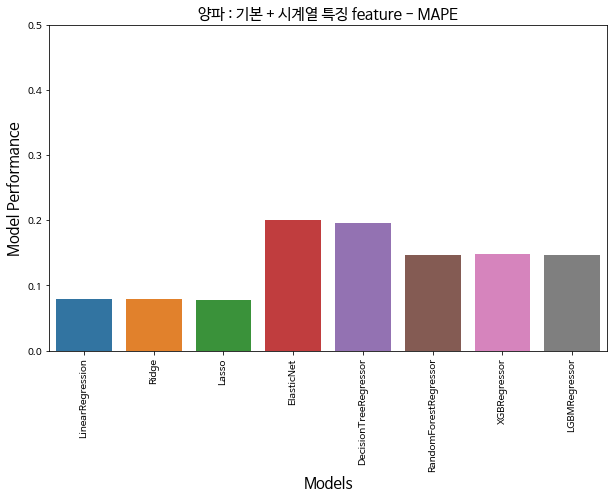

(1156, 24) (1156,) (315, 24) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 153.07it/s]

1 FOLDS: LinearRegression MAPE: 0.1094
2 FOLDS: LinearRegression MAPE: 0.1053
3 FOLDS: LinearRegression MAPE: 0.1137
4 FOLDS: LinearRegression MAPE: 0.1561
5 FOLDS: LinearRegression MAPE: 0.1062

LinearRegression mean MAPE: 0.1181


(1156, 24) (1156,) (315, 24) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 185.57it/s]

1 FOLDS: Ridge MAPE: 0.1221
2 FOLDS: Ridge MAPE: 0.1137
3 FOLDS: Ridge MAPE: 0.0999
4 FOLDS: Ridge MAPE: 0.1428
5 FOLDS: Ridge MAPE: 0.1090

Ridge mean MAPE: 0.1175


(1156, 24) (1156,) (315, 24) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 148.41it/s]

1 FOLDS: Lasso MAPE: 0.1296
2 FOLDS: Lasso MAPE: 0.1214
3 FOLDS: Lasso MAPE: 0.2384
4 FOLDS: Lasso MAPE: 0.0719
5 FOLDS: Lasso MAPE: 0.1090

Lasso mean MAPE: 0.1341


(1156, 24) (1156,) (315, 24) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 180.11it/s]

1 FOLDS: ElasticNet MAPE: 0.0973
2 FOLDS: ElasticNet MAPE: 0.1788
3 FOLDS: ElasticNet MAPE: 0.3213
4 FOLDS: ElasticNet MAPE: 0.2700
5 FOLDS: ElasticNet MAPE: 0.3420

ElasticNet mean MAPE: 0.2419


(1156, 24) (1156,) (315, 24) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 102.78it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2160
2 FOLDS: DecisionTreeRegressor MAPE: 0.1826
3 FOLDS: DecisionTreeRegressor MAPE: 0.2336
4 FOLDS: DecisionTreeRegressor MAPE: 0.2622
5 FOLDS: DecisionTreeRegressor MAPE: 0.2145

DecisionTreeRegressor mean MAPE: 0.2218


(1156, 24) (1156,) (315, 24) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.11it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1760
2 FOLDS: RandomForestRegressor MAPE: 0.1858
3 FOLDS: RandomForestRegressor MAPE: 0.1980
4 FOLDS: RandomForestRegressor MAPE: 0.1906
5 FOLDS: RandomForestRegressor MAPE: 0.2407

RandomForestRegressor mean MAPE: 0.1982
(1156, 24) (1156,) (315, 24) (315,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.08it/s]

[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.58it/s]


[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1285
2 FOLDS: XGBRegressor MAPE: 0.2072
3 FOLDS: XGBRegressor MAPE: 0.3009
4 FOLDS: XGBRegressor MAPE: 0.1636
5 FOLDS: XGBRegressor MAPE: 0.2014

XGBRegressor mean MAPE: 0.2003
(1156, 24) (1156,) (315, 24) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.72it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1349
2 FOLDS: LGBMRegressor MAPE: 0.1505
3 FOLDS: LGBMRegressor MAPE: 0.2156
4 FOLDS: LGBMRegressor MAPE: 0.2015
5 FOLDS: LGBMRegressor MAPE: 0.2487

LGBMRegressor mean MAPE: 0.1902


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.13
3,ElasticNet,0.24
4,DecisionTreeRegressor,0.22
5,RandomForestRegressor,0.20
6,XGBRegressor,0.20
7,LGBMRegressor,0.19


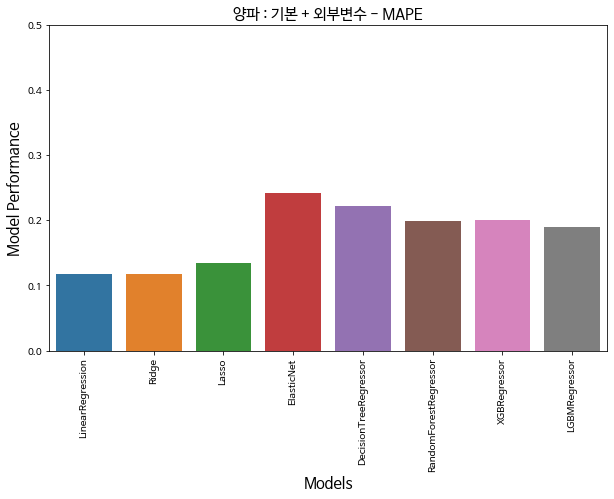

(1156, 26) (1156,) (315, 26) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 147.02it/s]

1 FOLDS: LinearRegression MAPE: 0.0937
2 FOLDS: LinearRegression MAPE: 0.0523
3 FOLDS: LinearRegression MAPE: 0.1364
4 FOLDS: LinearRegression MAPE: 0.0498
5 FOLDS: LinearRegression MAPE: 0.0804

LinearRegression mean MAPE: 0.0825


(1156, 26) (1156,) (315, 26) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 191.83it/s]

1 FOLDS: Ridge MAPE: 0.0689
2 FOLDS: Ridge MAPE: 0.0524
3 FOLDS: Ridge MAPE: 0.1365
4 FOLDS: Ridge MAPE: 0.0498
5 FOLDS: Ridge MAPE: 0.0823

Ridge mean MAPE: 0.0780


(1156, 26) (1156,) (315, 26) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 69.82it/s]

1 FOLDS: Lasso MAPE: 0.0612
2 FOLDS: Lasso MAPE: 0.0557
3 FOLDS: Lasso MAPE: 0.1248
4 FOLDS: Lasso MAPE: 0.0552
5 FOLDS: Lasso MAPE: 0.0833

Lasso mean MAPE: 0.0760


(1156, 26) (1156,) (315, 26) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 181.39it/s]

1 FOLDS: ElasticNet MAPE: 0.0704
2 FOLDS: ElasticNet MAPE: 0.0932
3 FOLDS: ElasticNet MAPE: 0.1839
4 FOLDS: ElasticNet MAPE: 0.1560
5 FOLDS: ElasticNet MAPE: 0.1877

ElasticNet mean MAPE: 0.1382


(1156, 26) (1156,) (315, 26) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 93.80it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2300
2 FOLDS: DecisionTreeRegressor MAPE: 0.1093
3 FOLDS: DecisionTreeRegressor MAPE: 0.1498
4 FOLDS: DecisionTreeRegressor MAPE: 0.1197
5 FOLDS: DecisionTreeRegressor MAPE: 0.3126

DecisionTreeRegressor mean MAPE: 0.1843


(1156, 26) (1156,) (315, 26) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1837
2 FOLDS: RandomForestRegressor MAPE: 0.0935
3 FOLDS: RandomForestRegressor MAPE: 0.1111
4 FOLDS: RandomForestRegressor MAPE: 0.0623
5 FOLDS: RandomForestRegressor MAPE: 0.2543

RandomForestRegressor mean MAPE: 0.1410
(1156, 26) (1156,) (315, 26) (315,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 16.44it/s]

[08:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.84it/s]

1 FOLDS: XGBRegressor MAPE: 0.1620
2 FOLDS: XGBRegressor MAPE: 0.0922
3 FOLDS: XGBRegressor MAPE: 0.1528
4 FOLDS: XGBRegressor MAPE: 0.0699
5 FOLDS: XGBRegressor MAPE: 0.2541

XGBRegressor mean MAPE: 0.1462


(1156, 26) (1156,) (315, 26) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.44it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1466
2 FOLDS: LGBMRegressor MAPE: 0.1494
3 FOLDS: LGBMRegressor MAPE: 0.1385
4 FOLDS: LGBMRegressor MAPE: 0.0653
5 FOLDS: LGBMRegressor MAPE: 0.2451

LGBMRegressor mean MAPE: 0.1490


,Model,Score
0,LinearRegression,0.08
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.14
4,DecisionTreeRegressor,0.18
5,RandomForestRegressor,0.14
6,XGBRegressor,0.15
7,LGBMRegressor,0.15


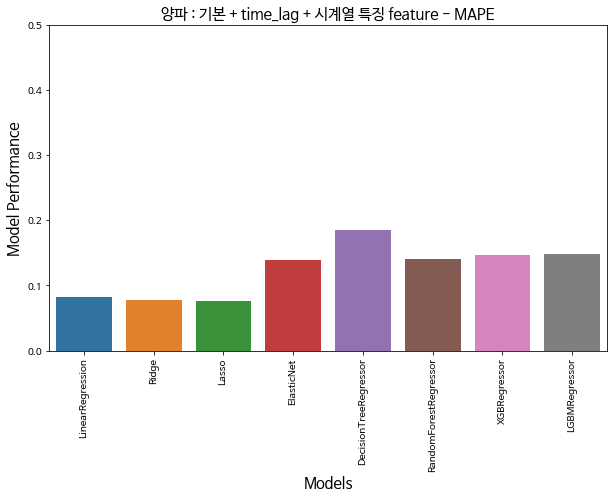

(1156, 34) (1156,) (315, 34) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.04it/s]

1 FOLDS: LinearRegression MAPE: 0.1897
2 FOLDS: LinearRegression MAPE: 0.0894
3 FOLDS: LinearRegression MAPE: 0.0885
4 FOLDS: LinearRegression MAPE: 0.0536
5 FOLDS: LinearRegression MAPE: 0.1338

LinearRegression mean MAPE: 0.1110


(1156, 34) (1156,) (315, 34) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.21it/s]

1 FOLDS: Ridge MAPE: 0.0792
2 FOLDS: Ridge MAPE: 0.0832
3 FOLDS: Ridge MAPE: 0.0907
4 FOLDS: Ridge MAPE: 0.0526
5 FOLDS: Ridge MAPE: 0.1305

Ridge mean MAPE: 0.0873


(1156, 34) (1156,) (315, 34) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 73.31it/s]

1 FOLDS: Lasso MAPE: 0.0616
2 FOLDS: Lasso MAPE: 0.0683
3 FOLDS: Lasso MAPE: 0.1184
4 FOLDS: Lasso MAPE: 0.0482
5 FOLDS: Lasso MAPE: 0.0911

Lasso mean MAPE: 0.0775


(1156, 34) (1156,) (315, 34) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 178.89it/s]

1 FOLDS: ElasticNet MAPE: 0.0883
2 FOLDS: ElasticNet MAPE: 0.1550
3 FOLDS: ElasticNet MAPE: 0.2751
4 FOLDS: ElasticNet MAPE: 0.2220
5 FOLDS: ElasticNet MAPE: 0.2855

ElasticNet mean MAPE: 0.2052


(1156, 34) (1156,) (315, 34) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 84.89it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2550
2 FOLDS: DecisionTreeRegressor MAPE: 0.1788
3 FOLDS: DecisionTreeRegressor MAPE: 0.2106
4 FOLDS: DecisionTreeRegressor MAPE: 0.1798
5 FOLDS: DecisionTreeRegressor MAPE: 0.2355

DecisionTreeRegressor mean MAPE: 0.2120


(1156, 34) (1156,) (315, 34) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.72it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2308
2 FOLDS: RandomForestRegressor MAPE: 0.1715
3 FOLDS: RandomForestRegressor MAPE: 0.1223
4 FOLDS: RandomForestRegressor MAPE: 0.1443
5 FOLDS: RandomForestRegressor MAPE: 0.2428

RandomForestRegressor mean MAPE: 0.1823
(1156, 34) (1156,) (315, 34) (315,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.04it/s]

[08:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 13.07it/s]

[08:53:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.01it/s]


1 FOLDS: XGBRegressor MAPE: 0.1722
2 FOLDS: XGBRegressor MAPE: 0.1985
3 FOLDS: XGBRegressor MAPE: 0.1580
4 FOLDS: XGBRegressor MAPE: 0.1282
5 FOLDS: XGBRegressor MAPE: 0.2279

XGBRegressor mean MAPE: 0.1770
(1156, 34) (1156,) (315, 34) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.12it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1739
2 FOLDS: LGBMRegressor MAPE: 0.1219
3 FOLDS: LGBMRegressor MAPE: 0.1590
4 FOLDS: LGBMRegressor MAPE: 0.1619
5 FOLDS: LGBMRegressor MAPE: 0.2148

LGBMRegressor mean MAPE: 0.1663


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.09
2,Lasso,0.08
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.18
6,XGBRegressor,0.18
7,LGBMRegressor,0.17


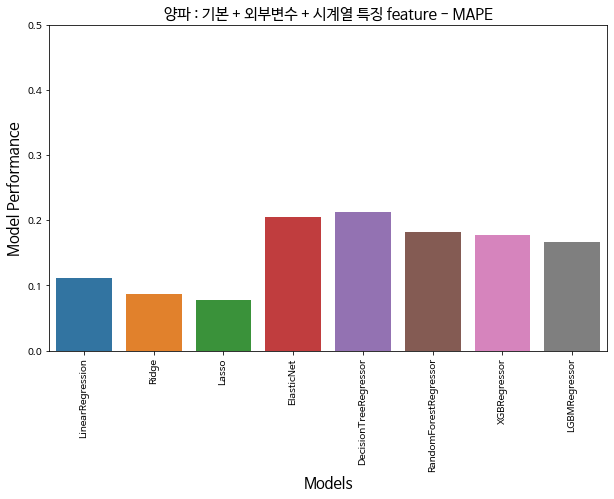

(1156, 33) (1156,) (315, 33) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 152.00it/s]

1 FOLDS: LinearRegression MAPE: 0.0977
2 FOLDS: LinearRegression MAPE: 0.1171
3 FOLDS: LinearRegression MAPE: 0.1168
4 FOLDS: LinearRegression MAPE: 0.1704
5 FOLDS: LinearRegression MAPE: 0.1043

LinearRegression mean MAPE: 0.1213


(1156, 33) (1156,) (315, 33) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 163.90it/s]

1 FOLDS: Ridge MAPE: 0.1128
2 FOLDS: Ridge MAPE: 0.1260
3 FOLDS: Ridge MAPE: 0.1004
4 FOLDS: Ridge MAPE: 0.1515
5 FOLDS: Ridge MAPE: 0.1077

Ridge mean MAPE: 0.1197


(1156, 33) (1156,) (315, 33) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 137.17it/s]

1 FOLDS: Lasso MAPE: 0.1185
2 FOLDS: Lasso MAPE: 0.1210
3 FOLDS: Lasso MAPE: 0.2350
4 FOLDS: Lasso MAPE: 0.0708
5 FOLDS: Lasso MAPE: 0.1089

Lasso mean MAPE: 0.1308


(1156, 33) (1156,) (315, 33) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.95it/s]

1 FOLDS: ElasticNet MAPE: 0.0856
2 FOLDS: ElasticNet MAPE: 0.1389
3 FOLDS: ElasticNet MAPE: 0.2281
4 FOLDS: ElasticNet MAPE: 0.1586
5 FOLDS: ElasticNet MAPE: 0.2024

ElasticNet mean MAPE: 0.1627


(1156, 33) (1156,) (315, 33) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 72.26it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2425
2 FOLDS: DecisionTreeRegressor MAPE: 0.1821
3 FOLDS: DecisionTreeRegressor MAPE: 0.2257
4 FOLDS: DecisionTreeRegressor MAPE: 0.1501
5 FOLDS: DecisionTreeRegressor MAPE: 0.2482

DecisionTreeRegressor mean MAPE: 0.2097


(1156, 33) (1156,) (315, 33) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2222
2 FOLDS: RandomForestRegressor MAPE: 0.1543
3 FOLDS: RandomForestRegressor MAPE: 0.1892
4 FOLDS: RandomForestRegressor MAPE: 0.1645
5 FOLDS: RandomForestRegressor MAPE: 0.2778

RandomForestRegressor mean MAPE: 0.2016
(1156, 33) (1156,) (315, 33) (315,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.49it/s]

[08:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.84it/s]

[08:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.88it/s]


1 FOLDS: XGBRegressor MAPE: 0.1250
2 FOLDS: XGBRegressor MAPE: 0.2000
3 FOLDS: XGBRegressor MAPE: 0.2975
4 FOLDS: XGBRegressor MAPE: 0.1717
5 FOLDS: XGBRegressor MAPE: 0.2430

XGBRegressor mean MAPE: 0.2074
(1156, 33) (1156,) (315, 33) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.78it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1361
2 FOLDS: LGBMRegressor MAPE: 0.1392
3 FOLDS: LGBMRegressor MAPE: 0.1966
4 FOLDS: LGBMRegressor MAPE: 0.1830
5 FOLDS: LGBMRegressor MAPE: 0.2681

LGBMRegressor mean MAPE: 0.1846


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.13
3,ElasticNet,0.16
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.20
6,XGBRegressor,0.21
7,LGBMRegressor,0.18


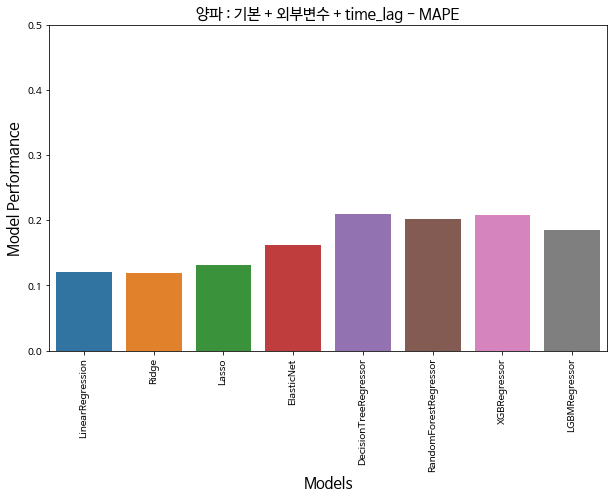

(1156, 43) (1156,) (315, 43) (315,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 106.16it/s]

1 FOLDS: LinearRegression MAPE: 0.2452
2 FOLDS: LinearRegression MAPE: 0.0728
3 FOLDS: LinearRegression MAPE: 0.0778
4 FOLDS: LinearRegression MAPE: 0.0618
5 FOLDS: LinearRegression MAPE: 0.0945

LinearRegression mean MAPE: 0.1104


(1156, 43) (1156,) (315, 43) (315,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.79it/s]

1 FOLDS: Ridge MAPE: 0.0893
2 FOLDS: Ridge MAPE: 0.0747
3 FOLDS: Ridge MAPE: 0.0798
4 FOLDS: Ridge MAPE: 0.0579
5 FOLDS: Ridge MAPE: 0.0979

Ridge mean MAPE: 0.0799


(1156, 43) (1156,) (315, 43) (315,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 58.36it/s]

1 FOLDS: Lasso MAPE: 0.0614
2 FOLDS: Lasso MAPE: 0.0643
3 FOLDS: Lasso MAPE: 0.1191
4 FOLDS: Lasso MAPE: 0.0438
5 FOLDS: Lasso MAPE: 0.0829

Lasso mean MAPE: 0.0743


(1156, 43) (1156,) (315, 43) (315,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 141.17it/s]

1 FOLDS: ElasticNet MAPE: 0.0810
2 FOLDS: ElasticNet MAPE: 0.1280
3 FOLDS: ElasticNet MAPE: 0.2116
4 FOLDS: ElasticNet MAPE: 0.1440
5 FOLDS: ElasticNet MAPE: 0.1870

ElasticNet mean MAPE: 0.1503


(1156, 43) (1156,) (315, 43) (315,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 65.81it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2818
2 FOLDS: DecisionTreeRegressor MAPE: 0.1920
3 FOLDS: DecisionTreeRegressor MAPE: 0.1552
4 FOLDS: DecisionTreeRegressor MAPE: 0.1817
5 FOLDS: DecisionTreeRegressor MAPE: 0.3072

DecisionTreeRegressor mean MAPE: 0.2236


(1156, 43) (1156,) (315, 43) (315,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.31it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2439
2 FOLDS: RandomForestRegressor MAPE: 0.1438
3 FOLDS: RandomForestRegressor MAPE: 0.1183
4 FOLDS: RandomForestRegressor MAPE: 0.1387
5 FOLDS: RandomForestRegressor MAPE: 0.2636

RandomForestRegressor mean MAPE: 0.1817
(1156, 43) (1156,) (315, 43) (315,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.38it/s]

[08:55:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.92it/s]

[08:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.91it/s]


1 FOLDS: XGBRegressor MAPE: 0.1964
2 FOLDS: XGBRegressor MAPE: 0.1831
3 FOLDS: XGBRegressor MAPE: 0.1926
4 FOLDS: XGBRegressor MAPE: 0.1431
5 FOLDS: XGBRegressor MAPE: 0.2420

XGBRegressor mean MAPE: 0.1914
(1156, 43) (1156,) (315, 43) (315,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.80it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1865
2 FOLDS: LGBMRegressor MAPE: 0.1227
3 FOLDS: LGBMRegressor MAPE: 0.1437
4 FOLDS: LGBMRegressor MAPE: 0.1607
5 FOLDS: LGBMRegressor MAPE: 0.2399

LGBMRegressor mean MAPE: 0.1707


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.08
2,Lasso,0.07
3,ElasticNet,0.15
4,DecisionTreeRegressor,0.22
5,RandomForestRegressor,0.18
6,XGBRegressor,0.19
7,LGBMRegressor,0.17


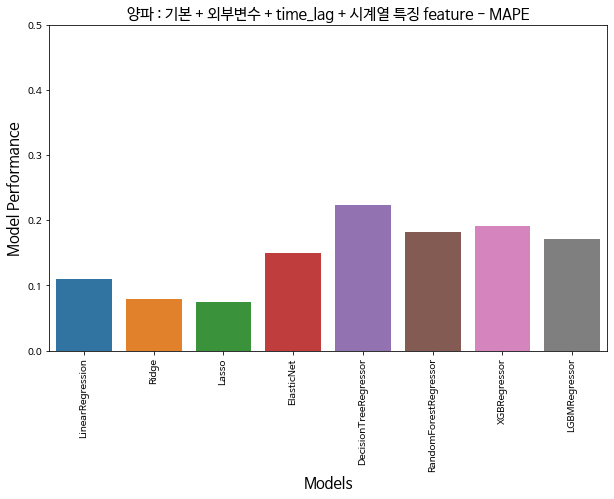

In [ ]:
modeling1('양파')
modeling2('양파')
modeling3('양파')
modeling4('양파')
modeling5('양파')
modeling6('양파')
modeling7('양파')
modeling8('양파')

## 대파

(1158, 7) (1158,) (314, 7) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 239.98it/s]

1 FOLDS: LinearRegression MAPE: 0.2914
2 FOLDS: LinearRegression MAPE: 0.2864
3 FOLDS: LinearRegression MAPE: 0.1724
4 FOLDS: LinearRegression MAPE: 0.1462
5 FOLDS: LinearRegression MAPE: 0.1408

LinearRegression mean MAPE: 0.2074


(1158, 7) (1158,) (314, 7) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 258.76it/s]

1 FOLDS: Ridge MAPE: 0.2861
2 FOLDS: Ridge MAPE: 0.2832
3 FOLDS: Ridge MAPE: 0.1731
4 FOLDS: Ridge MAPE: 0.1460
5 FOLDS: Ridge MAPE: 0.1405

Ridge mean MAPE: 0.2058


(1158, 7) (1158,) (314, 7) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 218.36it/s]

1 FOLDS: Lasso MAPE: 0.3020
2 FOLDS: Lasso MAPE: 0.2738
3 FOLDS: Lasso MAPE: 0.1767
4 FOLDS: Lasso MAPE: 0.1441
5 FOLDS: Lasso MAPE: 0.1425

Lasso mean MAPE: 0.2078


(1158, 7) (1158,) (314, 7) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 243.72it/s]

1 FOLDS: ElasticNet MAPE: 0.1532
2 FOLDS: ElasticNet MAPE: 0.3220
3 FOLDS: ElasticNet MAPE: 0.2940
4 FOLDS: ElasticNet MAPE: 0.1684
5 FOLDS: ElasticNet MAPE: 0.2235

ElasticNet mean MAPE: 0.2322


(1158, 7) (1158,) (314, 7) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 162.16it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2339
2 FOLDS: DecisionTreeRegressor MAPE: 0.2932
3 FOLDS: DecisionTreeRegressor MAPE: 0.2860
4 FOLDS: DecisionTreeRegressor MAPE: 0.2801
5 FOLDS: DecisionTreeRegressor MAPE: 0.2088

DecisionTreeRegressor mean MAPE: 0.2604


(1158, 7) (1158,) (314, 7) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.80it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2268
2 FOLDS: RandomForestRegressor MAPE: 0.2763
3 FOLDS: RandomForestRegressor MAPE: 0.2405
4 FOLDS: RandomForestRegressor MAPE: 0.2012
5 FOLDS: RandomForestRegressor MAPE: 0.1527

RandomForestRegressor mean MAPE: 0.2195
(1158, 7) (1158,) (314, 7) (314,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 27.86it/s]

[08:55:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:55:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1924
2 FOLDS: XGBRegressor MAPE: 0.3303
3 FOLDS: XGBRegressor MAPE: 0.2400
4 FOLDS: XGBRegressor MAPE: 0.2015
5 FOLDS: XGBRegressor MAPE: 0.1392

XGBRegressor mean MAPE: 0.2207


(1158, 7) (1158,) (314, 7) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 21.52it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2319
2 FOLDS: LGBMRegressor MAPE: 0.2339
3 FOLDS: LGBMRegressor MAPE: 0.2428
4 FOLDS: LGBMRegressor MAPE: 0.1788
5 FOLDS: LGBMRegressor MAPE: 0.1675

LGBMRegressor mean MAPE: 0.2110


,Model,Score
0,LinearRegression,0.21
1,Ridge,0.21
2,Lasso,0.21
3,ElasticNet,0.23
4,DecisionTreeRegressor,0.26
5,RandomForestRegressor,0.22
6,XGBRegressor,0.22
7,LGBMRegressor,0.21


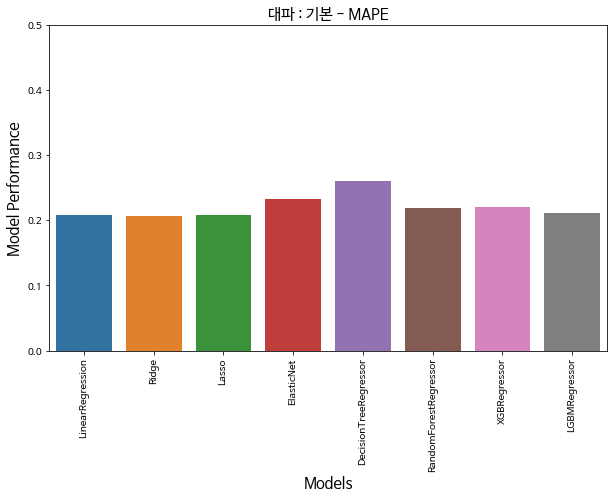

(1158, 16) (1158,) (314, 16) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 196.05it/s]

1 FOLDS: LinearRegression MAPE: 0.2971
2 FOLDS: LinearRegression MAPE: 0.2318
3 FOLDS: LinearRegression MAPE: 0.1680
4 FOLDS: LinearRegression MAPE: 0.1372
5 FOLDS: LinearRegression MAPE: 0.1371

LinearRegression mean MAPE: 0.1942


(1158, 16) (1158,) (314, 16) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 212.02it/s]

1 FOLDS: Ridge MAPE: 0.2784
2 FOLDS: Ridge MAPE: 0.2304
3 FOLDS: Ridge MAPE: 0.1680
4 FOLDS: Ridge MAPE: 0.1367
5 FOLDS: Ridge MAPE: 0.1372

Ridge mean MAPE: 0.1902


(1158, 16) (1158,) (314, 16) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 135.35it/s]

1 FOLDS: Lasso MAPE: 0.2988
2 FOLDS: Lasso MAPE: 0.2214
3 FOLDS: Lasso MAPE: 0.1677
4 FOLDS: Lasso MAPE: 0.1356
5 FOLDS: Lasso MAPE: 0.1379

Lasso mean MAPE: 0.1923


(1158, 16) (1158,) (314, 16) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 194.83it/s]

1 FOLDS: ElasticNet MAPE: 0.1282
2 FOLDS: ElasticNet MAPE: 0.2502
3 FOLDS: ElasticNet MAPE: 0.2259
4 FOLDS: ElasticNet MAPE: 0.1492
5 FOLDS: ElasticNet MAPE: 0.1678

ElasticNet mean MAPE: 0.1843


(1158, 16) (1158,) (314, 16) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 90.13it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2320
2 FOLDS: DecisionTreeRegressor MAPE: 0.2308
3 FOLDS: DecisionTreeRegressor MAPE: 0.3829
4 FOLDS: DecisionTreeRegressor MAPE: 0.2281
5 FOLDS: DecisionTreeRegressor MAPE: 0.2179

DecisionTreeRegressor mean MAPE: 0.2583


(1158, 16) (1158,) (314, 16) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.13it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1773
2 FOLDS: RandomForestRegressor MAPE: 0.1795
3 FOLDS: RandomForestRegressor MAPE: 0.3362
4 FOLDS: RandomForestRegressor MAPE: 0.1779
5 FOLDS: RandomForestRegressor MAPE: 0.1532

RandomForestRegressor mean MAPE: 0.2048
(1158, 16) (1158,) (314, 16) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.50it/s]

[08:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.55it/s]


[08:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1711
2 FOLDS: XGBRegressor MAPE: 0.1871
3 FOLDS: XGBRegressor MAPE: 0.2688
4 FOLDS: XGBRegressor MAPE: 0.1662
5 FOLDS: XGBRegressor MAPE: 0.1613

XGBRegressor mean MAPE: 0.1909
(1158, 16) (1158,) (314, 16) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.71it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1830
2 FOLDS: LGBMRegressor MAPE: 0.1845
3 FOLDS: LGBMRegressor MAPE: 0.2420
4 FOLDS: LGBMRegressor MAPE: 0.1535
5 FOLDS: LGBMRegressor MAPE: 0.1727

LGBMRegressor mean MAPE: 0.1871


,Model,Score
0,LinearRegression,0.19
1,Ridge,0.19
2,Lasso,0.19
3,ElasticNet,0.18
4,DecisionTreeRegressor,0.26
5,RandomForestRegressor,0.20
6,XGBRegressor,0.19
7,LGBMRegressor,0.19


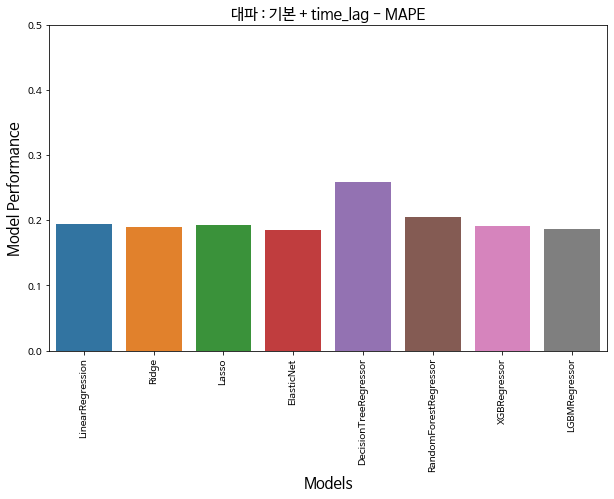

(1158, 17) (1158,) (314, 17) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 177.95it/s]

1 FOLDS: LinearRegression MAPE: 0.1491
2 FOLDS: LinearRegression MAPE: 0.1398
3 FOLDS: LinearRegression MAPE: 0.1370
4 FOLDS: LinearRegression MAPE: 0.1103
5 FOLDS: LinearRegression MAPE: 0.1148

LinearRegression mean MAPE: 0.1302


(1158, 17) (1158,) (314, 17) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 200.57it/s]

1 FOLDS: Ridge MAPE: 0.1531
2 FOLDS: Ridge MAPE: 0.1412
3 FOLDS: Ridge MAPE: 0.1364
4 FOLDS: Ridge MAPE: 0.1101
5 FOLDS: Ridge MAPE: 0.1146

Ridge mean MAPE: 0.1311


(1158, 17) (1158,) (314, 17) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 116.90it/s]

1 FOLDS: Lasso MAPE: 0.1546
2 FOLDS: Lasso MAPE: 0.1374
3 FOLDS: Lasso MAPE: 0.1352
4 FOLDS: Lasso MAPE: 0.1097
5 FOLDS: Lasso MAPE: 0.1130

Lasso mean MAPE: 0.1300


(1158, 17) (1158,) (314, 17) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 192.07it/s]

1 FOLDS: ElasticNet MAPE: 0.1220
2 FOLDS: ElasticNet MAPE: 0.2554
3 FOLDS: ElasticNet MAPE: 0.2278
4 FOLDS: ElasticNet MAPE: 0.1372
5 FOLDS: ElasticNet MAPE: 0.1744

ElasticNet mean MAPE: 0.1834


(1158, 17) (1158,) (314, 17) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 115.87it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1741
2 FOLDS: DecisionTreeRegressor MAPE: 0.1774
3 FOLDS: DecisionTreeRegressor MAPE: 0.2445
4 FOLDS: DecisionTreeRegressor MAPE: 0.2014
5 FOLDS: DecisionTreeRegressor MAPE: 0.1571

DecisionTreeRegressor mean MAPE: 0.1909


(1158, 17) (1158,) (314, 17) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.73it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1287
2 FOLDS: RandomForestRegressor MAPE: 0.1403
3 FOLDS: RandomForestRegressor MAPE: 0.1831
4 FOLDS: RandomForestRegressor MAPE: 0.1286
5 FOLDS: RandomForestRegressor MAPE: 0.1059

RandomForestRegressor mean MAPE: 0.1373
(1158, 17) (1158,) (314, 17) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 24.51it/s]

[08:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 18.32it/s]


1 FOLDS: XGBRegressor MAPE: 0.1342
2 FOLDS: XGBRegressor MAPE: 0.1390
3 FOLDS: XGBRegressor MAPE: 0.1525
4 FOLDS: XGBRegressor MAPE: 0.1177
5 FOLDS: XGBRegressor MAPE: 0.1217

XGBRegressor mean MAPE: 0.1330
(1158, 17) (1158,) (314, 17) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.70it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1394
2 FOLDS: LGBMRegressor MAPE: 0.1448
3 FOLDS: LGBMRegressor MAPE: 0.1681
4 FOLDS: LGBMRegressor MAPE: 0.1097
5 FOLDS: LGBMRegressor MAPE: 0.1205

LGBMRegressor mean MAPE: 0.1365


,Model,Score
0,LinearRegression,0.13
1,Ridge,0.13
2,Lasso,0.13
3,ElasticNet,0.18
4,DecisionTreeRegressor,0.19
5,RandomForestRegressor,0.14
6,XGBRegressor,0.13
7,LGBMRegressor,0.14


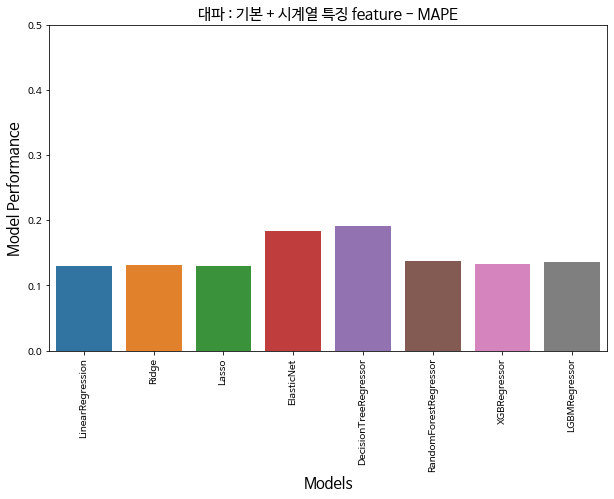

(1158, 24) (1158,) (314, 24) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 161.35it/s]

1 FOLDS: LinearRegression MAPE: 0.4912
2 FOLDS: LinearRegression MAPE: 0.6619
3 FOLDS: LinearRegression MAPE: 0.3425
4 FOLDS: LinearRegression MAPE: 0.1791
5 FOLDS: LinearRegression MAPE: 0.1311

LinearRegression mean MAPE: 0.3612


(1158, 24) (1158,) (314, 24) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 182.45it/s]

1 FOLDS: Ridge MAPE: 0.4135
2 FOLDS: Ridge MAPE: 0.6083
3 FOLDS: Ridge MAPE: 0.3244
4 FOLDS: Ridge MAPE: 0.1789
5 FOLDS: Ridge MAPE: 0.1307

Ridge mean MAPE: 0.3312


(1158, 24) (1158,) (314, 24) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 117.33it/s]

1 FOLDS: Lasso MAPE: 0.4547
2 FOLDS: Lasso MAPE: 0.5680
3 FOLDS: Lasso MAPE: 0.3349
4 FOLDS: Lasso MAPE: 0.1816
5 FOLDS: Lasso MAPE: 0.1332

Lasso mean MAPE: 0.3345


(1158, 24) (1158,) (314, 24) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 173.98it/s]

1 FOLDS: ElasticNet MAPE: 0.1633
2 FOLDS: ElasticNet MAPE: 0.3440
3 FOLDS: ElasticNet MAPE: 0.3462
4 FOLDS: ElasticNet MAPE: 0.2304
5 FOLDS: ElasticNet MAPE: 0.2259

ElasticNet mean MAPE: 0.2620


(1158, 24) (1158,) (314, 24) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 100.21it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.4023
2 FOLDS: DecisionTreeRegressor MAPE: 0.2930
3 FOLDS: DecisionTreeRegressor MAPE: 0.3528
4 FOLDS: DecisionTreeRegressor MAPE: 0.2672
5 FOLDS: DecisionTreeRegressor MAPE: 0.1785

DecisionTreeRegressor mean MAPE: 0.2988


(1158, 24) (1158,) (314, 24) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.02it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2887
2 FOLDS: RandomForestRegressor MAPE: 0.2506
3 FOLDS: RandomForestRegressor MAPE: 0.2995
4 FOLDS: RandomForestRegressor MAPE: 0.2182
5 FOLDS: RandomForestRegressor MAPE: 0.1378

RandomForestRegressor mean MAPE: 0.2390
(1158, 24) (1158,) (314, 24) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 21.10it/s]

[08:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 16.13it/s]


[08:56:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2943
2 FOLDS: XGBRegressor MAPE: 0.2803
3 FOLDS: XGBRegressor MAPE: 0.2996
4 FOLDS: XGBRegressor MAPE: 0.1872
5 FOLDS: XGBRegressor MAPE: 0.1394

XGBRegressor mean MAPE: 0.2402
(1158, 24) (1158,) (314, 24) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.93it/s]

1 FOLDS: LGBMRegressor MAPE: 0.3080
2 FOLDS: LGBMRegressor MAPE: 0.2461
3 FOLDS: LGBMRegressor MAPE: 0.2783
4 FOLDS: LGBMRegressor MAPE: 0.2068
5 FOLDS: LGBMRegressor MAPE: 0.1437

LGBMRegressor mean MAPE: 0.2366


,Model,Score
0,LinearRegression,0.36
1,Ridge,0.33
2,Lasso,0.33
3,ElasticNet,0.26
4,DecisionTreeRegressor,0.30
5,RandomForestRegressor,0.24
6,XGBRegressor,0.24
7,LGBMRegressor,0.24


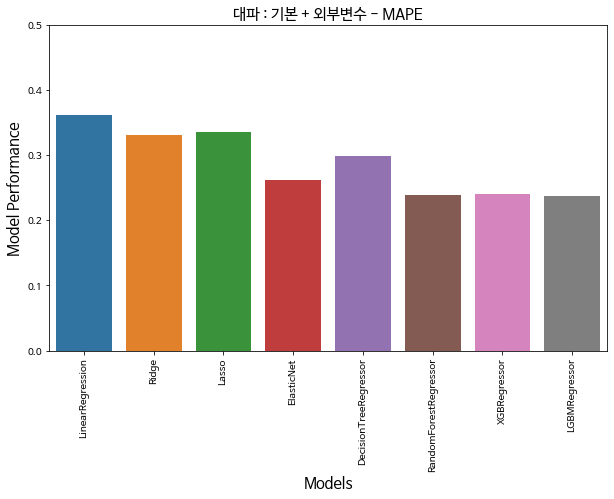

(1158, 26) (1158,) (314, 26) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 166.33it/s]

1 FOLDS: LinearRegression MAPE: 0.1018
2 FOLDS: LinearRegression MAPE: 0.1301
3 FOLDS: LinearRegression MAPE: 0.1140
4 FOLDS: LinearRegression MAPE: 0.0929
5 FOLDS: LinearRegression MAPE: 0.0974

LinearRegression mean MAPE: 0.1072


(1158, 26) (1158,) (314, 26) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.98it/s]

1 FOLDS: Ridge MAPE: 0.1168
2 FOLDS: Ridge MAPE: 0.1328
3 FOLDS: Ridge MAPE: 0.1144
4 FOLDS: Ridge MAPE: 0.0928
5 FOLDS: Ridge MAPE: 0.0979

Ridge mean MAPE: 0.1110


(1158, 26) (1158,) (314, 26) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 81.12it/s]

1 FOLDS: Lasso MAPE: 0.1088
2 FOLDS: Lasso MAPE: 0.1254
3 FOLDS: Lasso MAPE: 0.1175
4 FOLDS: Lasso MAPE: 0.0936
5 FOLDS: Lasso MAPE: 0.0972

Lasso mean MAPE: 0.1085


(1158, 26) (1158,) (314, 26) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 160.70it/s]

1 FOLDS: ElasticNet MAPE: 0.1149
2 FOLDS: ElasticNet MAPE: 0.2246
3 FOLDS: ElasticNet MAPE: 0.2023
4 FOLDS: ElasticNet MAPE: 0.1365
5 FOLDS: ElasticNet MAPE: 0.1534

ElasticNet mean MAPE: 0.1663


(1158, 26) (1158,) (314, 26) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 82.20it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1564
2 FOLDS: DecisionTreeRegressor MAPE: 0.1565
3 FOLDS: DecisionTreeRegressor MAPE: 0.2349
4 FOLDS: DecisionTreeRegressor MAPE: 0.1685
5 FOLDS: DecisionTreeRegressor MAPE: 0.1570

DecisionTreeRegressor mean MAPE: 0.1747


(1158, 26) (1158,) (314, 26) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1320
2 FOLDS: RandomForestRegressor MAPE: 0.1283
3 FOLDS: RandomForestRegressor MAPE: 0.2328
4 FOLDS: RandomForestRegressor MAPE: 0.1132
5 FOLDS: RandomForestRegressor MAPE: 0.1016

RandomForestRegressor mean MAPE: 0.1416
(1158, 26) (1158,) (314, 26) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.03it/s]

[08:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.46it/s]

[08:57:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.08it/s]


1 FOLDS: XGBRegressor MAPE: 0.1423
2 FOLDS: XGBRegressor MAPE: 0.1414
3 FOLDS: XGBRegressor MAPE: 0.1898
4 FOLDS: XGBRegressor MAPE: 0.1186
5 FOLDS: XGBRegressor MAPE: 0.1166

XGBRegressor mean MAPE: 0.1417
(1158, 26) (1158,) (314, 26) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.83it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1390
2 FOLDS: LGBMRegressor MAPE: 0.1336
3 FOLDS: LGBMRegressor MAPE: 0.1731
4 FOLDS: LGBMRegressor MAPE: 0.1028
5 FOLDS: LGBMRegressor MAPE: 0.1137

LGBMRegressor mean MAPE: 0.1324


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.11
2,Lasso,0.11
3,ElasticNet,0.17
4,DecisionTreeRegressor,0.17
5,RandomForestRegressor,0.14
6,XGBRegressor,0.14
7,LGBMRegressor,0.13


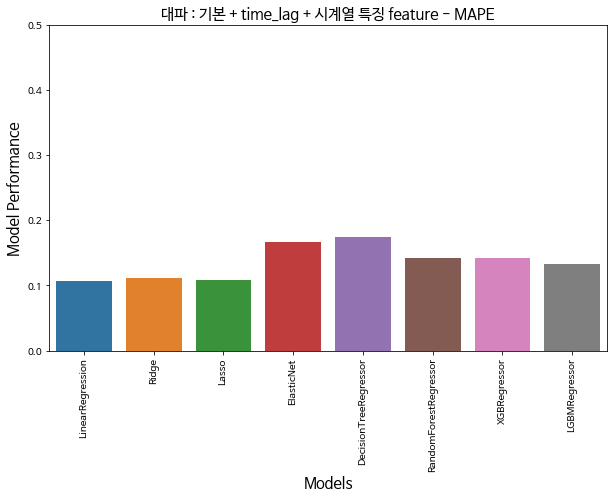

(1158, 34) (1158,) (314, 34) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 150.68it/s]

1 FOLDS: LinearRegression MAPE: 0.2917
2 FOLDS: LinearRegression MAPE: 0.1934
3 FOLDS: LinearRegression MAPE: 0.1750
4 FOLDS: LinearRegression MAPE: 0.1153
5 FOLDS: LinearRegression MAPE: 0.1314

LinearRegression mean MAPE: 0.1814


(1158, 34) (1158,) (314, 34) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.19it/s]

1 FOLDS: Ridge MAPE: 0.2788
2 FOLDS: Ridge MAPE: 0.1975
3 FOLDS: Ridge MAPE: 0.1687
4 FOLDS: Ridge MAPE: 0.1146
5 FOLDS: Ridge MAPE: 0.1311

Ridge mean MAPE: 0.1781


(1158, 34) (1158,) (314, 34) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 75.52it/s]

1 FOLDS: Lasso MAPE: 0.2648
2 FOLDS: Lasso MAPE: 0.1563
3 FOLDS: Lasso MAPE: 0.1557
4 FOLDS: Lasso MAPE: 0.1107
5 FOLDS: Lasso MAPE: 0.1167

Lasso mean MAPE: 0.1608


(1158, 34) (1158,) (314, 34) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.73it/s]

1 FOLDS: ElasticNet MAPE: 0.1422
2 FOLDS: ElasticNet MAPE: 0.2856
3 FOLDS: ElasticNet MAPE: 0.2723
4 FOLDS: ElasticNet MAPE: 0.1818
5 FOLDS: ElasticNet MAPE: 0.1749

ElasticNet mean MAPE: 0.2113


(1158, 34) (1158,) (314, 34) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 79.96it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.3392
2 FOLDS: DecisionTreeRegressor MAPE: 0.1611
3 FOLDS: DecisionTreeRegressor MAPE: 0.2159
4 FOLDS: DecisionTreeRegressor MAPE: 0.1823
5 FOLDS: DecisionTreeRegressor MAPE: 0.1626

DecisionTreeRegressor mean MAPE: 0.2122


(1158, 34) (1158,) (314, 34) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.69it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2370
2 FOLDS: RandomForestRegressor MAPE: 0.1400
3 FOLDS: RandomForestRegressor MAPE: 0.2049
4 FOLDS: RandomForestRegressor MAPE: 0.1389
5 FOLDS: RandomForestRegressor MAPE: 0.1278

RandomForestRegressor mean MAPE: 0.1697
(1158, 34) (1158,) (314, 34) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.88it/s]

[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 13.12it/s]

[08:58:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.97it/s]


1 FOLDS: XGBRegressor MAPE: 0.2072
2 FOLDS: XGBRegressor MAPE: 0.1095
3 FOLDS: XGBRegressor MAPE: 0.1865
4 FOLDS: XGBRegressor MAPE: 0.1357
5 FOLDS: XGBRegressor MAPE: 0.1207

XGBRegressor mean MAPE: 0.1519
(1158, 34) (1158,) (314, 34) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.50it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2056
2 FOLDS: LGBMRegressor MAPE: 0.1179
3 FOLDS: LGBMRegressor MAPE: 0.2220
4 FOLDS: LGBMRegressor MAPE: 0.1206
5 FOLDS: LGBMRegressor MAPE: 0.1305

LGBMRegressor mean MAPE: 0.1593


,Model,Score
0,LinearRegression,0.18
1,Ridge,0.18
2,Lasso,0.16
3,ElasticNet,0.21
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.17
6,XGBRegressor,0.15
7,LGBMRegressor,0.16


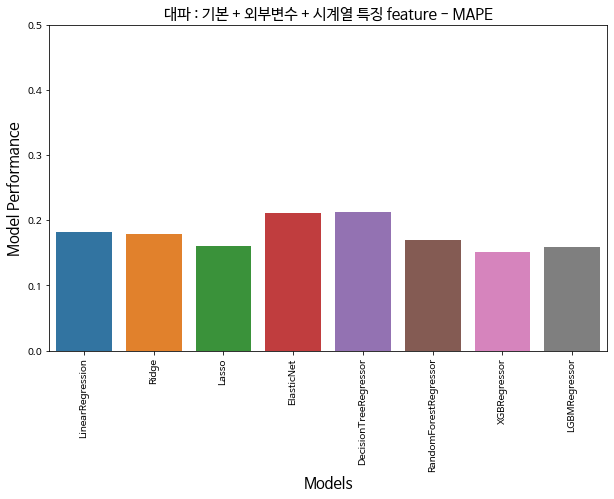

(1158, 33) (1158,) (314, 33) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.84it/s]

1 FOLDS: LinearRegression MAPE: 0.5337
2 FOLDS: LinearRegression MAPE: 0.5017
3 FOLDS: LinearRegression MAPE: 0.2428
4 FOLDS: LinearRegression MAPE: 0.1624
5 FOLDS: LinearRegression MAPE: 0.1336

LinearRegression mean MAPE: 0.3148


(1158, 33) (1158,) (314, 33) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.35it/s]

1 FOLDS: Ridge MAPE: 0.3942
2 FOLDS: Ridge MAPE: 0.4484
3 FOLDS: Ridge MAPE: 0.2329
4 FOLDS: Ridge MAPE: 0.1613
5 FOLDS: Ridge MAPE: 0.1326

Ridge mean MAPE: 0.2739


(1158, 33) (1158,) (314, 33) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 106.01it/s]

1 FOLDS: Lasso MAPE: 0.4395
2 FOLDS: Lasso MAPE: 0.4248
3 FOLDS: Lasso MAPE: 0.2211
4 FOLDS: Lasso MAPE: 0.1661
5 FOLDS: Lasso MAPE: 0.1308

Lasso mean MAPE: 0.2765


(1158, 33) (1158,) (314, 33) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.58it/s]

1 FOLDS: ElasticNet MAPE: 0.1365
2 FOLDS: ElasticNet MAPE: 0.2732
3 FOLDS: ElasticNet MAPE: 0.2513
4 FOLDS: ElasticNet MAPE: 0.1772
5 FOLDS: ElasticNet MAPE: 0.1642

ElasticNet mean MAPE: 0.2005


(1158, 33) (1158,) (314, 33) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 71.59it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.3559
2 FOLDS: DecisionTreeRegressor MAPE: 0.2632
3 FOLDS: DecisionTreeRegressor MAPE: 0.3578
4 FOLDS: DecisionTreeRegressor MAPE: 0.2428
5 FOLDS: DecisionTreeRegressor MAPE: 0.2765

DecisionTreeRegressor mean MAPE: 0.2992


(1158, 33) (1158,) (314, 33) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.44it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.2586
2 FOLDS: RandomForestRegressor MAPE: 0.1694
3 FOLDS: RandomForestRegressor MAPE: 0.2847
4 FOLDS: RandomForestRegressor MAPE: 0.1948
5 FOLDS: RandomForestRegressor MAPE: 0.1501

RandomForestRegressor mean MAPE: 0.2115
(1158, 33) (1158,) (314, 33) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.94it/s]

[08:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.20it/s]

[08:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:58:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.42it/s]


1 FOLDS: XGBRegressor MAPE: 0.2776
2 FOLDS: XGBRegressor MAPE: 0.1800
3 FOLDS: XGBRegressor MAPE: 0.2582
4 FOLDS: XGBRegressor MAPE: 0.1638
5 FOLDS: XGBRegressor MAPE: 0.1529

XGBRegressor mean MAPE: 0.2065
(1158, 33) (1158,) (314, 33) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.20it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2630
2 FOLDS: LGBMRegressor MAPE: 0.1530
3 FOLDS: LGBMRegressor MAPE: 0.2551
4 FOLDS: LGBMRegressor MAPE: 0.1935
5 FOLDS: LGBMRegressor MAPE: 0.1585

LGBMRegressor mean MAPE: 0.2046


,Model,Score
0,LinearRegression,0.31
1,Ridge,0.27
2,Lasso,0.28
3,ElasticNet,0.20
4,DecisionTreeRegressor,0.30
5,RandomForestRegressor,0.21
6,XGBRegressor,0.21
7,LGBMRegressor,0.20


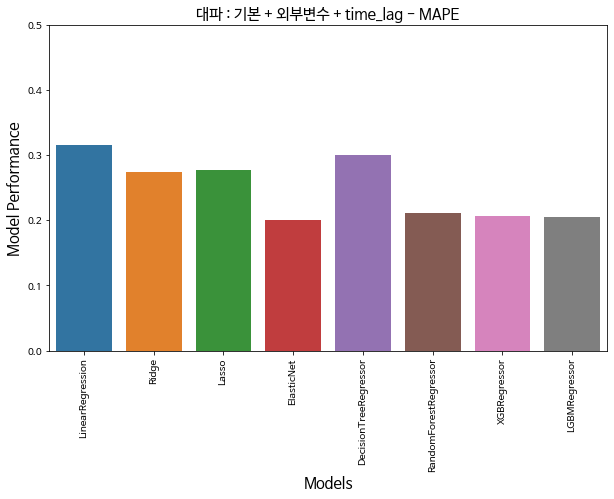

(1158, 43) (1158,) (314, 43) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 127.89it/s]

1 FOLDS: LinearRegression MAPE: 0.2806
2 FOLDS: LinearRegression MAPE: 0.2181
3 FOLDS: LinearRegression MAPE: 0.1432
4 FOLDS: LinearRegression MAPE: 0.0955
5 FOLDS: LinearRegression MAPE: 0.1080

LinearRegression mean MAPE: 0.1691


(1158, 43) (1158,) (314, 43) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 121.90it/s]

1 FOLDS: Ridge MAPE: 0.2771
2 FOLDS: Ridge MAPE: 0.2159
3 FOLDS: Ridge MAPE: 0.1377
4 FOLDS: Ridge MAPE: 0.0947
5 FOLDS: Ridge MAPE: 0.1106

Ridge mean MAPE: 0.1672


(1158, 43) (1158,) (314, 43) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 63.16it/s]

1 FOLDS: Lasso MAPE: 0.2748
2 FOLDS: Lasso MAPE: 0.1687
3 FOLDS: Lasso MAPE: 0.1305
4 FOLDS: Lasso MAPE: 0.0918
5 FOLDS: Lasso MAPE: 0.0956

Lasso mean MAPE: 0.1523


(1158, 43) (1158,) (314, 43) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 125.78it/s]

1 FOLDS: ElasticNet MAPE: 0.1283
2 FOLDS: ElasticNet MAPE: 0.2484
3 FOLDS: ElasticNet MAPE: 0.2281
4 FOLDS: ElasticNet MAPE: 0.1603
5 FOLDS: ElasticNet MAPE: 0.1496

ElasticNet mean MAPE: 0.1829


(1158, 43) (1158,) (314, 43) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 61.04it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.3222
2 FOLDS: DecisionTreeRegressor MAPE: 0.1609
3 FOLDS: DecisionTreeRegressor MAPE: 0.2446
4 FOLDS: DecisionTreeRegressor MAPE: 0.1725
5 FOLDS: DecisionTreeRegressor MAPE: 0.1679

DecisionTreeRegressor mean MAPE: 0.2136


(1158, 43) (1158,) (314, 43) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.28it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1925
2 FOLDS: RandomForestRegressor MAPE: 0.1215
3 FOLDS: RandomForestRegressor MAPE: 0.2276
4 FOLDS: RandomForestRegressor MAPE: 0.1320
5 FOLDS: RandomForestRegressor MAPE: 0.1224

RandomForestRegressor mean MAPE: 0.1592
(1158, 43) (1158,) (314, 43) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.32it/s]

[08:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:59:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.18it/s]

[08:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.62it/s]


1 FOLDS: XGBRegressor MAPE: 0.2254
2 FOLDS: XGBRegressor MAPE: 0.1165
3 FOLDS: XGBRegressor MAPE: 0.1954
4 FOLDS: XGBRegressor MAPE: 0.1378
5 FOLDS: XGBRegressor MAPE: 0.1244

XGBRegressor mean MAPE: 0.1599
(1158, 43) (1158,) (314, 43) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.03it/s]

1 FOLDS: LGBMRegressor MAPE: 0.2040
2 FOLDS: LGBMRegressor MAPE: 0.1147
3 FOLDS: LGBMRegressor MAPE: 0.2100
4 FOLDS: LGBMRegressor MAPE: 0.1191
5 FOLDS: LGBMRegressor MAPE: 0.1276

LGBMRegressor mean MAPE: 0.1551


,Model,Score
0,LinearRegression,0.17
1,Ridge,0.17
2,Lasso,0.15
3,ElasticNet,0.18
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.16
6,XGBRegressor,0.16
7,LGBMRegressor,0.16


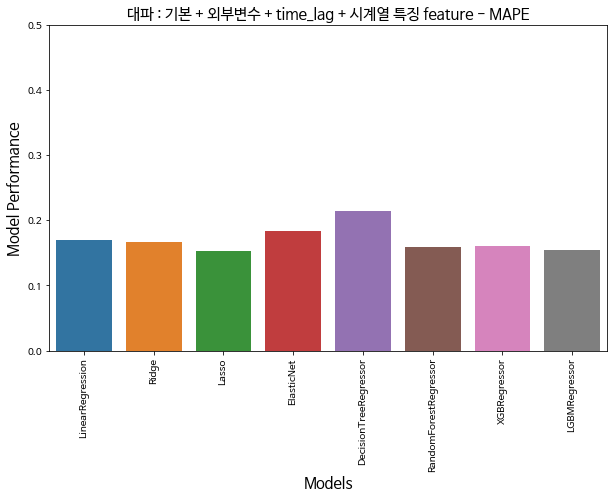

In [ ]:
modeling1('대파')
modeling2('대파')
modeling3('대파')
modeling4('대파')
modeling5('대파')
modeling6('대파')
modeling7('대파')
modeling8('대파')

## 마늘

(1151, 7) (1151,) (310, 7) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 277.00it/s]

1 FOLDS: LinearRegression MAPE: 0.0646
2 FOLDS: LinearRegression MAPE: 0.1285
3 FOLDS: LinearRegression MAPE: 0.0991
4 FOLDS: LinearRegression MAPE: 0.0602
5 FOLDS: LinearRegression MAPE: 0.1060

LinearRegression mean MAPE: 0.0917


(1151, 7) (1151,) (310, 7) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 250.55it/s]

1 FOLDS: Ridge MAPE: 0.0655
2 FOLDS: Ridge MAPE: 0.1287
3 FOLDS: Ridge MAPE: 0.0990
4 FOLDS: Ridge MAPE: 0.0601
5 FOLDS: Ridge MAPE: 0.1065

Ridge mean MAPE: 0.0919


(1151, 7) (1151,) (310, 7) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 183.23it/s]

1 FOLDS: Lasso MAPE: 0.0655
2 FOLDS: Lasso MAPE: 0.1263
3 FOLDS: Lasso MAPE: 0.0988
4 FOLDS: Lasso MAPE: 0.0600
5 FOLDS: Lasso MAPE: 0.1071

Lasso mean MAPE: 0.0915


(1151, 7) (1151,) (310, 7) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 243.35it/s]

1 FOLDS: ElasticNet MAPE: 0.0987
2 FOLDS: ElasticNet MAPE: 0.1862
3 FOLDS: ElasticNet MAPE: 0.1429
4 FOLDS: ElasticNet MAPE: 0.0810
5 FOLDS: ElasticNet MAPE: 0.2988

ElasticNet mean MAPE: 0.1615


(1151, 7) (1151,) (310, 7) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 175.50it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.0792
2 FOLDS: DecisionTreeRegressor MAPE: 0.1860
3 FOLDS: DecisionTreeRegressor MAPE: 0.1315
4 FOLDS: DecisionTreeRegressor MAPE: 0.1851
5 FOLDS: DecisionTreeRegressor MAPE: 0.3158

DecisionTreeRegressor mean MAPE: 0.1795


(1151, 7) (1151,) (310, 7) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.76it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0662
2 FOLDS: RandomForestRegressor MAPE: 0.1701
3 FOLDS: RandomForestRegressor MAPE: 0.0979
4 FOLDS: RandomForestRegressor MAPE: 0.1018
5 FOLDS: RandomForestRegressor MAPE: 0.2611

RandomForestRegressor mean MAPE: 0.1394
(1151, 7) (1151,) (310, 7) (310,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 28.27it/s]

[09:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.0593
2 FOLDS: XGBRegressor MAPE: 0.1552
3 FOLDS: XGBRegressor MAPE: 0.0951
4 FOLDS: XGBRegressor MAPE: 0.0871
5 FOLDS: XGBRegressor MAPE: 0.2145

XGBRegressor mean MAPE: 0.1223


(1151, 7) (1151,) (310, 7) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 20.90it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0607
2 FOLDS: LGBMRegressor MAPE: 0.1591
3 FOLDS: LGBMRegressor MAPE: 0.0960
4 FOLDS: LGBMRegressor MAPE: 0.1045
5 FOLDS: LGBMRegressor MAPE: 0.2233

LGBMRegressor mean MAPE: 0.1287


,Model,Score
0,LinearRegression,0.09
1,Ridge,0.09
2,Lasso,0.09
3,ElasticNet,0.16
4,DecisionTreeRegressor,0.18
5,RandomForestRegressor,0.14
6,XGBRegressor,0.12
7,LGBMRegressor,0.13


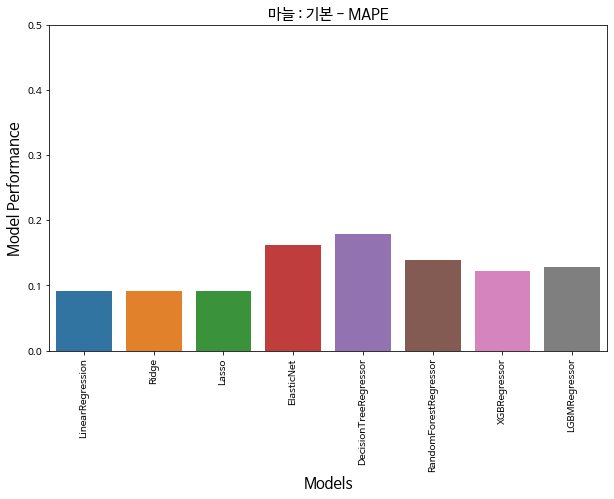

(1151, 16) (1151,) (310, 16) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 197.30it/s]

1 FOLDS: LinearRegression MAPE: 0.0603
2 FOLDS: LinearRegression MAPE: 0.1015
3 FOLDS: LinearRegression MAPE: 0.0929
4 FOLDS: LinearRegression MAPE: 0.0550
5 FOLDS: LinearRegression MAPE: 0.0944

LinearRegression mean MAPE: 0.0808


(1151, 16) (1151,) (310, 16) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 197.19it/s]

1 FOLDS: Ridge MAPE: 0.0606
2 FOLDS: Ridge MAPE: 0.1020
3 FOLDS: Ridge MAPE: 0.0926
4 FOLDS: Ridge MAPE: 0.0549
5 FOLDS: Ridge MAPE: 0.0944

Ridge mean MAPE: 0.0809


(1151, 16) (1151,) (310, 16) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 103.30it/s]

1 FOLDS: Lasso MAPE: 0.0606
2 FOLDS: Lasso MAPE: 0.1022
3 FOLDS: Lasso MAPE: 0.0924
4 FOLDS: Lasso MAPE: 0.0547
5 FOLDS: Lasso MAPE: 0.0947

Lasso mean MAPE: 0.0809


(1151, 16) (1151,) (310, 16) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 188.54it/s]

1 FOLDS: ElasticNet MAPE: 0.0802
2 FOLDS: ElasticNet MAPE: 0.1383
3 FOLDS: ElasticNet MAPE: 0.1101
4 FOLDS: ElasticNet MAPE: 0.0554
5 FOLDS: ElasticNet MAPE: 0.1648

ElasticNet mean MAPE: 0.1098


(1151, 16) (1151,) (310, 16) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 113.04it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.0881
2 FOLDS: DecisionTreeRegressor MAPE: 0.1704
3 FOLDS: DecisionTreeRegressor MAPE: 0.1011
4 FOLDS: DecisionTreeRegressor MAPE: 0.1016
5 FOLDS: DecisionTreeRegressor MAPE: 0.1701

DecisionTreeRegressor mean MAPE: 0.1263


(1151, 16) (1151,) (310, 16) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.20it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0661
2 FOLDS: RandomForestRegressor MAPE: 0.1429
3 FOLDS: RandomForestRegressor MAPE: 0.0793
4 FOLDS: RandomForestRegressor MAPE: 0.0735
5 FOLDS: RandomForestRegressor MAPE: 0.1881

RandomForestRegressor mean MAPE: 0.1100
(1151, 16) (1151,) (310, 16) (310,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.65it/s]

[09:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.46it/s]


[09:00:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.0679
2 FOLDS: XGBRegressor MAPE: 0.1402
3 FOLDS: XGBRegressor MAPE: 0.0810
4 FOLDS: XGBRegressor MAPE: 0.0633
5 FOLDS: XGBRegressor MAPE: 0.1743

XGBRegressor mean MAPE: 0.1053
(1151, 16) (1151,) (310, 16) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.27it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0626
2 FOLDS: LGBMRegressor MAPE: 0.1307
3 FOLDS: LGBMRegressor MAPE: 0.0815
4 FOLDS: LGBMRegressor MAPE: 0.0867
5 FOLDS: LGBMRegressor MAPE: 0.1731

LGBMRegressor mean MAPE: 0.1069


,Model,Score
0,LinearRegression,0.08
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.13
5,RandomForestRegressor,0.11
6,XGBRegressor,0.11
7,LGBMRegressor,0.11


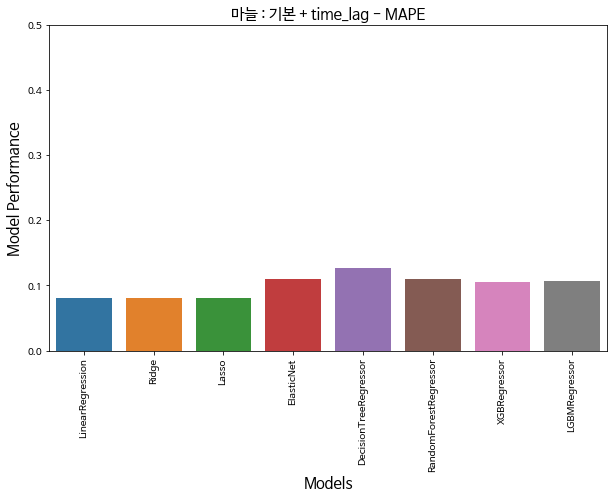

(1151, 17) (1151,) (310, 17) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 190.87it/s]

1 FOLDS: LinearRegression MAPE: 0.0506
2 FOLDS: LinearRegression MAPE: 0.0794
3 FOLDS: LinearRegression MAPE: 0.0809
4 FOLDS: LinearRegression MAPE: 0.0512
5 FOLDS: LinearRegression MAPE: 0.0825

LinearRegression mean MAPE: 0.0689


(1151, 17) (1151,) (310, 17) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 193.86it/s]

1 FOLDS: Ridge MAPE: 0.0492
2 FOLDS: Ridge MAPE: 0.0789
3 FOLDS: Ridge MAPE: 0.0808
4 FOLDS: Ridge MAPE: 0.0511
5 FOLDS: Ridge MAPE: 0.0824

Ridge mean MAPE: 0.0685


(1151, 17) (1151,) (310, 17) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 127.31it/s]

1 FOLDS: Lasso MAPE: 0.0494
2 FOLDS: Lasso MAPE: 0.0787
3 FOLDS: Lasso MAPE: 0.0810
4 FOLDS: Lasso MAPE: 0.0509
5 FOLDS: Lasso MAPE: 0.0823

Lasso mean MAPE: 0.0685


(1151, 17) (1151,) (310, 17) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 190.44it/s]

1 FOLDS: ElasticNet MAPE: 0.0782
2 FOLDS: ElasticNet MAPE: 0.1477
3 FOLDS: ElasticNet MAPE: 0.1118
4 FOLDS: ElasticNet MAPE: 0.0610
5 FOLDS: ElasticNet MAPE: 0.2087

ElasticNet mean MAPE: 0.1215


(1151, 17) (1151,) (310, 17) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 127.78it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.0773
2 FOLDS: DecisionTreeRegressor MAPE: 0.1269
3 FOLDS: DecisionTreeRegressor MAPE: 0.0984
4 FOLDS: DecisionTreeRegressor MAPE: 0.0884
5 FOLDS: DecisionTreeRegressor MAPE: 0.1778

DecisionTreeRegressor mean MAPE: 0.1137


(1151, 17) (1151,) (310, 17) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.72it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0558
2 FOLDS: RandomForestRegressor MAPE: 0.1098
3 FOLDS: RandomForestRegressor MAPE: 0.0796
4 FOLDS: RandomForestRegressor MAPE: 0.0552
5 FOLDS: RandomForestRegressor MAPE: 0.1598

RandomForestRegressor mean MAPE: 0.0920
(1151, 17) (1151,) (310, 17) (310,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 24.06it/s]

[09:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 17.78it/s]


1 FOLDS: XGBRegressor MAPE: 0.0602
2 FOLDS: XGBRegressor MAPE: 0.1068
3 FOLDS: XGBRegressor MAPE: 0.0754
4 FOLDS: XGBRegressor MAPE: 0.0546
5 FOLDS: XGBRegressor MAPE: 0.1347

XGBRegressor mean MAPE: 0.0863
(1151, 17) (1151,) (310, 17) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.72it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0568
2 FOLDS: LGBMRegressor MAPE: 0.1052
3 FOLDS: LGBMRegressor MAPE: 0.0866
4 FOLDS: LGBMRegressor MAPE: 0.0563
5 FOLDS: LGBMRegressor MAPE: 0.1393

LGBMRegressor mean MAPE: 0.0889


,Model,Score
0,LinearRegression,0.07
1,Ridge,0.07
2,Lasso,0.07
3,ElasticNet,0.12
4,DecisionTreeRegressor,0.11
5,RandomForestRegressor,0.09
6,XGBRegressor,0.09
7,LGBMRegressor,0.09


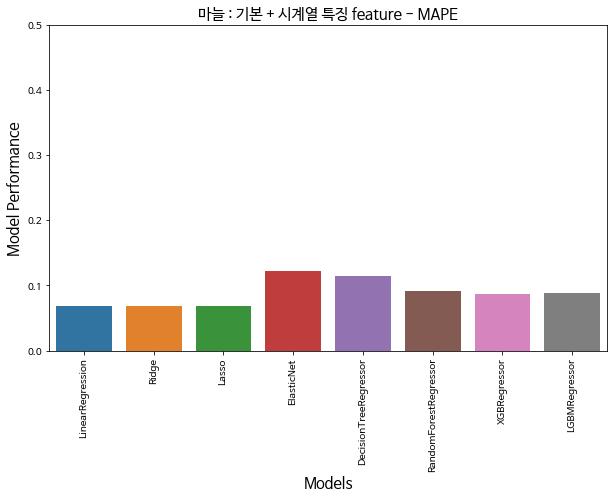

(1151, 24) (1151,) (310, 24) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 176.30it/s]

1 FOLDS: LinearRegression MAPE: 0.2552
2 FOLDS: LinearRegression MAPE: 0.2813
3 FOLDS: LinearRegression MAPE: 0.0986
4 FOLDS: LinearRegression MAPE: 0.1030
5 FOLDS: LinearRegression MAPE: 0.1425

LinearRegression mean MAPE: 0.1761


(1151, 24) (1151,) (310, 24) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 141.21it/s]

1 FOLDS: Ridge MAPE: 0.1453
2 FOLDS: Ridge MAPE: 0.1991
3 FOLDS: Ridge MAPE: 0.0985
4 FOLDS: Ridge MAPE: 0.0684
5 FOLDS: Ridge MAPE: 0.1397

Ridge mean MAPE: 0.1302


(1151, 24) (1151,) (310, 24) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 84.59it/s]

1 FOLDS: Lasso MAPE: 0.2133
2 FOLDS: Lasso MAPE: 0.2291
3 FOLDS: Lasso MAPE: 0.0984
4 FOLDS: Lasso MAPE: 0.0674
5 FOLDS: Lasso MAPE: 0.1329

Lasso mean MAPE: 0.1482


(1151, 24) (1151,) (310, 24) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 160.88it/s]

1 FOLDS: ElasticNet MAPE: 0.1040
2 FOLDS: ElasticNet MAPE: 0.1748
3 FOLDS: ElasticNet MAPE: 0.1298
4 FOLDS: ElasticNet MAPE: 0.0681
5 FOLDS: ElasticNet MAPE: 0.2549

ElasticNet mean MAPE: 0.1463


(1151, 24) (1151,) (310, 24) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 102.38it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1272
2 FOLDS: DecisionTreeRegressor MAPE: 0.2276
3 FOLDS: DecisionTreeRegressor MAPE: 0.2370
4 FOLDS: DecisionTreeRegressor MAPE: 0.1943
5 FOLDS: DecisionTreeRegressor MAPE: 0.3202

DecisionTreeRegressor mean MAPE: 0.2213


(1151, 24) (1151,) (310, 24) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.13it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1495
2 FOLDS: RandomForestRegressor MAPE: 0.1747
3 FOLDS: RandomForestRegressor MAPE: 0.1279
4 FOLDS: RandomForestRegressor MAPE: 0.0962
5 FOLDS: RandomForestRegressor MAPE: 0.2563

RandomForestRegressor mean MAPE: 0.1609
(1151, 24) (1151,) (310, 24) (310,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.60it/s]

[09:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.96it/s]


[09:01:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1233
2 FOLDS: XGBRegressor MAPE: 0.1600
3 FOLDS: XGBRegressor MAPE: 0.1177
4 FOLDS: XGBRegressor MAPE: 0.0992
5 FOLDS: XGBRegressor MAPE: 0.1841

XGBRegressor mean MAPE: 0.1369
(1151, 24) (1151,) (310, 24) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.70it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1499
2 FOLDS: LGBMRegressor MAPE: 0.1825
3 FOLDS: LGBMRegressor MAPE: 0.1379
4 FOLDS: LGBMRegressor MAPE: 0.1011
5 FOLDS: LGBMRegressor MAPE: 0.2216

LGBMRegressor mean MAPE: 0.1586


,Model,Score
0,LinearRegression,0.18
1,Ridge,0.13
2,Lasso,0.15
3,ElasticNet,0.15
4,DecisionTreeRegressor,0.22
5,RandomForestRegressor,0.16
6,XGBRegressor,0.14
7,LGBMRegressor,0.16


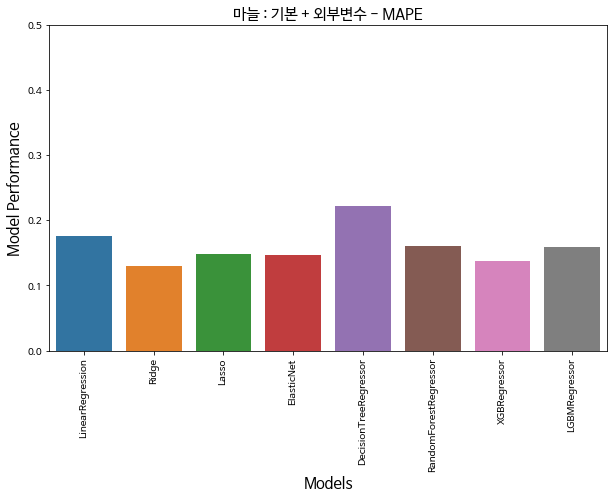

(1151, 26) (1151,) (310, 26) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 122.36it/s]

1 FOLDS: LinearRegression MAPE: 0.0529
2 FOLDS: LinearRegression MAPE: 0.0757
3 FOLDS: LinearRegression MAPE: 0.0761
4 FOLDS: LinearRegression MAPE: 0.0509
5 FOLDS: LinearRegression MAPE: 0.0779

LinearRegression mean MAPE: 0.0667


(1151, 26) (1151,) (310, 26) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.07it/s]

1 FOLDS: Ridge MAPE: 0.0510
2 FOLDS: Ridge MAPE: 0.0756
3 FOLDS: Ridge MAPE: 0.0761
4 FOLDS: Ridge MAPE: 0.0508
5 FOLDS: Ridge MAPE: 0.0780

Ridge mean MAPE: 0.0663


(1151, 26) (1151,) (310, 26) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 78.16it/s]

1 FOLDS: Lasso MAPE: 0.0514
2 FOLDS: Lasso MAPE: 0.0755
3 FOLDS: Lasso MAPE: 0.0765
4 FOLDS: Lasso MAPE: 0.0504
5 FOLDS: Lasso MAPE: 0.0785

Lasso mean MAPE: 0.0665


(1151, 26) (1151,) (310, 26) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.29it/s]

1 FOLDS: ElasticNet MAPE: 0.0693
2 FOLDS: ElasticNet MAPE: 0.1227
3 FOLDS: ElasticNet MAPE: 0.1006
4 FOLDS: ElasticNet MAPE: 0.0525
5 FOLDS: ElasticNet MAPE: 0.1445

ElasticNet mean MAPE: 0.0979


(1151, 26) (1151,) (310, 26) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 81.78it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.0986
2 FOLDS: DecisionTreeRegressor MAPE: 0.1411
3 FOLDS: DecisionTreeRegressor MAPE: 0.1012
4 FOLDS: DecisionTreeRegressor MAPE: 0.1525
5 FOLDS: DecisionTreeRegressor MAPE: 0.1679

DecisionTreeRegressor mean MAPE: 0.1322


(1151, 26) (1151,) (310, 26) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.75it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0701
2 FOLDS: RandomForestRegressor MAPE: 0.1101
3 FOLDS: RandomForestRegressor MAPE: 0.0746
4 FOLDS: RandomForestRegressor MAPE: 0.0546
5 FOLDS: RandomForestRegressor MAPE: 0.1639

RandomForestRegressor mean MAPE: 0.0947
(1151, 26) (1151,) (310, 26) (310,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.91it/s]

[09:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.05it/s]

[09:02:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.02it/s]


1 FOLDS: XGBRegressor MAPE: 0.0658
2 FOLDS: XGBRegressor MAPE: 0.1108
3 FOLDS: XGBRegressor MAPE: 0.0768
4 FOLDS: XGBRegressor MAPE: 0.0541
5 FOLDS: XGBRegressor MAPE: 0.1406

XGBRegressor mean MAPE: 0.0896
(1151, 26) (1151,) (310, 26) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.33it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0658
2 FOLDS: LGBMRegressor MAPE: 0.1095
3 FOLDS: LGBMRegressor MAPE: 0.0827
4 FOLDS: LGBMRegressor MAPE: 0.0564
5 FOLDS: LGBMRegressor MAPE: 0.1421

LGBMRegressor mean MAPE: 0.0913


,Model,Score
0,LinearRegression,0.07
1,Ridge,0.07
2,Lasso,0.07
3,ElasticNet,0.10
4,DecisionTreeRegressor,0.13
5,RandomForestRegressor,0.09
6,XGBRegressor,0.09
7,LGBMRegressor,0.09


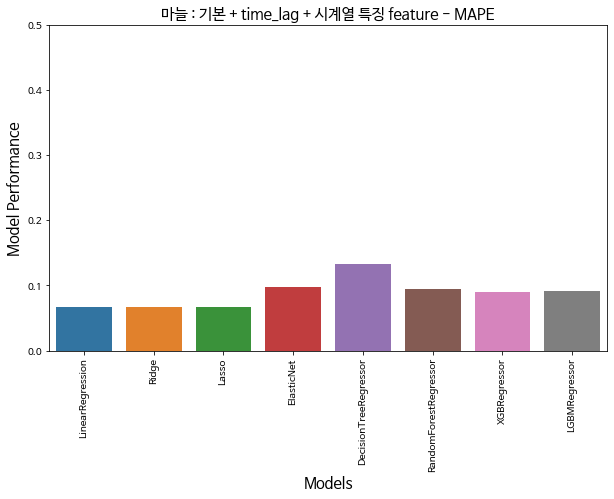

(1151, 34) (1151,) (310, 34) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 149.99it/s]

1 FOLDS: LinearRegression MAPE: 0.1850
2 FOLDS: LinearRegression MAPE: 0.0800
3 FOLDS: LinearRegression MAPE: 0.0825
4 FOLDS: LinearRegression MAPE: 0.0612
5 FOLDS: LinearRegression MAPE: 0.0915

LinearRegression mean MAPE: 0.1000


(1151, 34) (1151,) (310, 34) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 174.61it/s]

1 FOLDS: Ridge MAPE: 0.1168
2 FOLDS: Ridge MAPE: 0.0785
3 FOLDS: Ridge MAPE: 0.0813
4 FOLDS: Ridge MAPE: 0.0575
5 FOLDS: Ridge MAPE: 0.0903

Ridge mean MAPE: 0.0849


(1151, 34) (1151,) (310, 34) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 67.21it/s]

1 FOLDS: Lasso MAPE: 0.1392
2 FOLDS: Lasso MAPE: 0.0779
3 FOLDS: Lasso MAPE: 0.0815
4 FOLDS: Lasso MAPE: 0.0545
5 FOLDS: Lasso MAPE: 0.0840

Lasso mean MAPE: 0.0874


(1151, 34) (1151,) (310, 34) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 136.29it/s]

1 FOLDS: ElasticNet MAPE: 0.0817
2 FOLDS: ElasticNet MAPE: 0.1417
3 FOLDS: ElasticNet MAPE: 0.1049
4 FOLDS: ElasticNet MAPE: 0.0578
5 FOLDS: ElasticNet MAPE: 0.1896

ElasticNet mean MAPE: 0.1151


(1151, 34) (1151,) (310, 34) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 82.95it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.0857
2 FOLDS: DecisionTreeRegressor MAPE: 0.1408
3 FOLDS: DecisionTreeRegressor MAPE: 0.1059
4 FOLDS: DecisionTreeRegressor MAPE: 0.0646
5 FOLDS: DecisionTreeRegressor MAPE: 0.1530

DecisionTreeRegressor mean MAPE: 0.1100


(1151, 34) (1151,) (310, 34) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0692
2 FOLDS: RandomForestRegressor MAPE: 0.1294
3 FOLDS: RandomForestRegressor MAPE: 0.0811
4 FOLDS: RandomForestRegressor MAPE: 0.0759
5 FOLDS: RandomForestRegressor MAPE: 0.1647

RandomForestRegressor mean MAPE: 0.1040
(1151, 34) (1151,) (310, 34) (310,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.69it/s]

[09:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.63it/s]

[09:02:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.76it/s]


1 FOLDS: XGBRegressor MAPE: 0.0627
2 FOLDS: XGBRegressor MAPE: 0.1171
3 FOLDS: XGBRegressor MAPE: 0.0889
4 FOLDS: XGBRegressor MAPE: 0.0619
5 FOLDS: XGBRegressor MAPE: 0.1407

XGBRegressor mean MAPE: 0.0943
(1151, 34) (1151,) (310, 34) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.68it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0761
2 FOLDS: LGBMRegressor MAPE: 0.1344
3 FOLDS: LGBMRegressor MAPE: 0.0953
4 FOLDS: LGBMRegressor MAPE: 0.0709
5 FOLDS: LGBMRegressor MAPE: 0.1394

LGBMRegressor mean MAPE: 0.1032


,Model,Score
0,LinearRegression,0.10
1,Ridge,0.08
2,Lasso,0.09
3,ElasticNet,0.12
4,DecisionTreeRegressor,0.11
5,RandomForestRegressor,0.10
6,XGBRegressor,0.09
7,LGBMRegressor,0.10


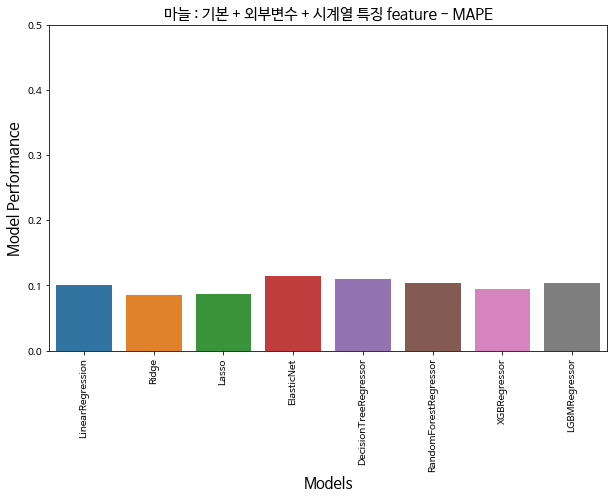

(1151, 33) (1151,) (310, 33) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 145.82it/s]

1 FOLDS: LinearRegression MAPE: 0.2842
2 FOLDS: LinearRegression MAPE: 0.1589
3 FOLDS: LinearRegression MAPE: 0.0897
4 FOLDS: LinearRegression MAPE: 0.0903
5 FOLDS: LinearRegression MAPE: 0.1216

LinearRegression mean MAPE: 0.1489


(1151, 33) (1151,) (310, 33) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 166.96it/s]

1 FOLDS: Ridge MAPE: 0.1126
2 FOLDS: Ridge MAPE: 0.1226
3 FOLDS: Ridge MAPE: 0.0894
4 FOLDS: Ridge MAPE: 0.0641
5 FOLDS: Ridge MAPE: 0.1194

Ridge mean MAPE: 0.1016


(1151, 33) (1151,) (310, 33) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 51.86it/s]

1 FOLDS: Lasso MAPE: 0.2181
2 FOLDS: Lasso MAPE: 0.1102
3 FOLDS: Lasso MAPE: 0.0890
4 FOLDS: Lasso MAPE: 0.0611
5 FOLDS: Lasso MAPE: 0.1049

Lasso mean MAPE: 0.1167


(1151, 33) (1151,) (310, 33) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 156.23it/s]

1 FOLDS: ElasticNet MAPE: 0.0805
2 FOLDS: ElasticNet MAPE: 0.1320
3 FOLDS: ElasticNet MAPE: 0.1033
4 FOLDS: ElasticNet MAPE: 0.0572
5 FOLDS: ElasticNet MAPE: 0.1547

ElasticNet mean MAPE: 0.1055


(1151, 33) (1151,) (310, 33) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 76.76it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1323
2 FOLDS: DecisionTreeRegressor MAPE: 0.2101
3 FOLDS: DecisionTreeRegressor MAPE: 0.1208
4 FOLDS: DecisionTreeRegressor MAPE: 0.1618
5 FOLDS: DecisionTreeRegressor MAPE: 0.1998

DecisionTreeRegressor mean MAPE: 0.1650


(1151, 33) (1151,) (310, 33) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1140
2 FOLDS: RandomForestRegressor MAPE: 0.1546
3 FOLDS: RandomForestRegressor MAPE: 0.0850
4 FOLDS: RandomForestRegressor MAPE: 0.0795
5 FOLDS: RandomForestRegressor MAPE: 0.1865

RandomForestRegressor mean MAPE: 0.1239
(1151, 33) (1151,) (310, 33) (310,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 17.00it/s]

[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.50it/s]

[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.73it/s]


1 FOLDS: XGBRegressor MAPE: 0.1173
2 FOLDS: XGBRegressor MAPE: 0.1312
3 FOLDS: XGBRegressor MAPE: 0.0886
4 FOLDS: XGBRegressor MAPE: 0.0827
5 FOLDS: XGBRegressor MAPE: 0.1796

XGBRegressor mean MAPE: 0.1199
(1151, 33) (1151,) (310, 33) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.19it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1155
2 FOLDS: LGBMRegressor MAPE: 0.1568
3 FOLDS: LGBMRegressor MAPE: 0.0943
4 FOLDS: LGBMRegressor MAPE: 0.0965
5 FOLDS: LGBMRegressor MAPE: 0.1774

LGBMRegressor mean MAPE: 0.1281


,Model,Score
0,LinearRegression,0.15
1,Ridge,0.10
2,Lasso,0.12
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.16
5,RandomForestRegressor,0.12
6,XGBRegressor,0.12
7,LGBMRegressor,0.13


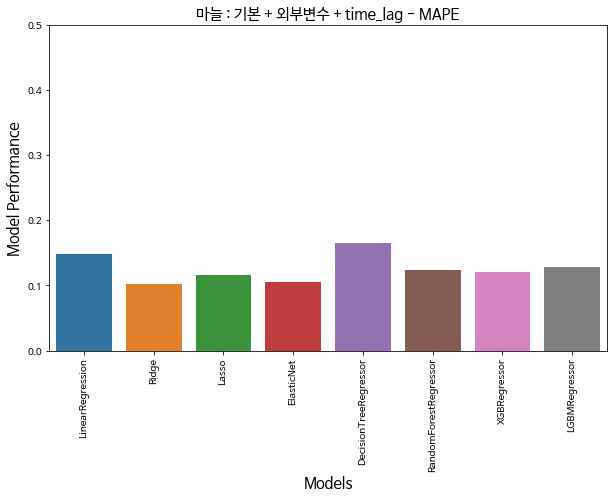

(1151, 43) (1151,) (310, 43) (310,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 99.39it/s]

1 FOLDS: LinearRegression MAPE: 0.1908
2 FOLDS: LinearRegression MAPE: 0.0824
3 FOLDS: LinearRegression MAPE: 0.0773
4 FOLDS: LinearRegression MAPE: 0.0586
5 FOLDS: LinearRegression MAPE: 0.0830

LinearRegression mean MAPE: 0.0984


(1151, 43) (1151,) (310, 43) (310,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 156.08it/s]

1 FOLDS: Ridge MAPE: 0.1167
2 FOLDS: Ridge MAPE: 0.0783
3 FOLDS: Ridge MAPE: 0.0765
4 FOLDS: Ridge MAPE: 0.0557
5 FOLDS: Ridge MAPE: 0.0825

Ridge mean MAPE: 0.0820


(1151, 43) (1151,) (310, 43) (310,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 57.69it/s]

1 FOLDS: Lasso MAPE: 0.1371
2 FOLDS: Lasso MAPE: 0.0763
3 FOLDS: Lasso MAPE: 0.0771
4 FOLDS: Lasso MAPE: 0.0522
5 FOLDS: Lasso MAPE: 0.0784

Lasso mean MAPE: 0.0842


(1151, 43) (1151,) (310, 43) (310,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 142.97it/s]

1 FOLDS: ElasticNet MAPE: 0.0692
2 FOLDS: ElasticNet MAPE: 0.1185
3 FOLDS: ElasticNet MAPE: 0.0956
4 FOLDS: ElasticNet MAPE: 0.0547
5 FOLDS: ElasticNet MAPE: 0.1375

ElasticNet mean MAPE: 0.0951


(1151, 43) (1151,) (310, 43) (310,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 67.02it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1216
2 FOLDS: DecisionTreeRegressor MAPE: 0.1780
3 FOLDS: DecisionTreeRegressor MAPE: 0.1164
4 FOLDS: DecisionTreeRegressor MAPE: 0.1445
5 FOLDS: DecisionTreeRegressor MAPE: 0.1559

DecisionTreeRegressor mean MAPE: 0.1433


(1151, 43) (1151,) (310, 43) (310,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.29it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.0798
2 FOLDS: RandomForestRegressor MAPE: 0.1253
3 FOLDS: RandomForestRegressor MAPE: 0.0772
4 FOLDS: RandomForestRegressor MAPE: 0.0772
5 FOLDS: RandomForestRegressor MAPE: 0.1662

RandomForestRegressor mean MAPE: 0.1051
(1151, 43) (1151,) (310, 43) (310,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 15.62it/s]

[09:03:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.56it/s]

[09:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:03:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.89it/s]


1 FOLDS: XGBRegressor MAPE: 0.0759
2 FOLDS: XGBRegressor MAPE: 0.1184
3 FOLDS: XGBRegressor MAPE: 0.0852
4 FOLDS: XGBRegressor MAPE: 0.0735
5 FOLDS: XGBRegressor MAPE: 0.1491

XGBRegressor mean MAPE: 0.1004
(1151, 43) (1151,) (310, 43) (310,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.06it/s]

1 FOLDS: LGBMRegressor MAPE: 0.0662
2 FOLDS: LGBMRegressor MAPE: 0.1310
3 FOLDS: LGBMRegressor MAPE: 0.0912
4 FOLDS: LGBMRegressor MAPE: 0.0695
5 FOLDS: LGBMRegressor MAPE: 0.1567

LGBMRegressor mean MAPE: 0.1029


,Model,Score
0,LinearRegression,0.10
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.10
4,DecisionTreeRegressor,0.14
5,RandomForestRegressor,0.11
6,XGBRegressor,0.10
7,LGBMRegressor,0.10


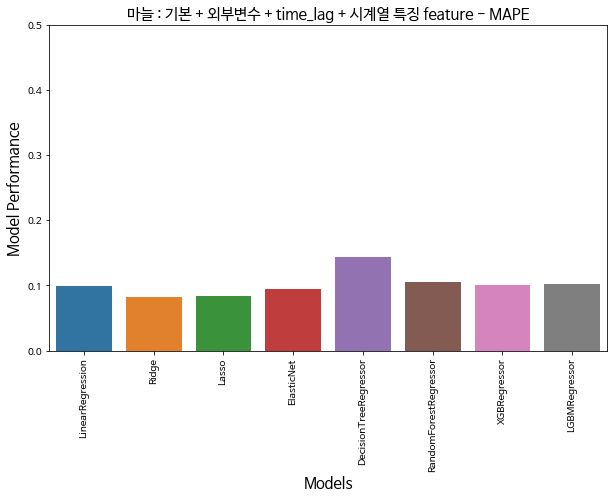

In [ ]:
modeling1('마늘')
modeling2('마늘')
modeling3('마늘')
modeling4('마늘')
modeling5('마늘')
modeling6('마늘')
modeling7('마늘')
modeling8('마늘')

## 사과

(1159, 7) (1159,) (314, 7) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 226.54it/s]

1 FOLDS: LinearRegression MAPE: 0.1495
2 FOLDS: LinearRegression MAPE: 0.0941
3 FOLDS: LinearRegression MAPE: 0.1042
4 FOLDS: LinearRegression MAPE: 0.1357
5 FOLDS: LinearRegression MAPE: 0.1409

LinearRegression mean MAPE: 0.1249


(1159, 7) (1159,) (314, 7) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 244.99it/s]

1 FOLDS: Ridge MAPE: 0.1452
2 FOLDS: Ridge MAPE: 0.0940
3 FOLDS: Ridge MAPE: 0.1038
4 FOLDS: Ridge MAPE: 0.1357
5 FOLDS: Ridge MAPE: 0.1406

Ridge mean MAPE: 0.1239


(1159, 7) (1159,) (314, 7) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 226.22it/s]

1 FOLDS: Lasso MAPE: 0.1459
2 FOLDS: Lasso MAPE: 0.0936
3 FOLDS: Lasso MAPE: 0.1008
4 FOLDS: Lasso MAPE: 0.1355
5 FOLDS: Lasso MAPE: 0.1392

Lasso mean MAPE: 0.1230


(1159, 7) (1159,) (314, 7) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 234.54it/s]

1 FOLDS: ElasticNet MAPE: 0.1393
2 FOLDS: ElasticNet MAPE: 0.1094
3 FOLDS: ElasticNet MAPE: 0.0973
4 FOLDS: ElasticNet MAPE: 0.1374
5 FOLDS: ElasticNet MAPE: 0.1234

ElasticNet mean MAPE: 0.1214


(1159, 7) (1159,) (314, 7) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.56it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1730
2 FOLDS: DecisionTreeRegressor MAPE: 0.1422
3 FOLDS: DecisionTreeRegressor MAPE: 0.1391
4 FOLDS: DecisionTreeRegressor MAPE: 0.1819
5 FOLDS: DecisionTreeRegressor MAPE: 0.2714

DecisionTreeRegressor mean MAPE: 0.1815


(1159, 7) (1159,) (314, 7) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.73it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1730
2 FOLDS: RandomForestRegressor MAPE: 0.1208
3 FOLDS: RandomForestRegressor MAPE: 0.0890
4 FOLDS: RandomForestRegressor MAPE: 0.1388
5 FOLDS: RandomForestRegressor MAPE: 0.1991

RandomForestRegressor mean MAPE: 0.1442
(1159, 7) (1159,) (314, 7) (314,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 30.04it/s]

[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2108
2 FOLDS: XGBRegressor MAPE: 0.1350
3 FOLDS: XGBRegressor MAPE: 0.0814
4 FOLDS: XGBRegressor MAPE: 0.1288
5 FOLDS: XGBRegressor MAPE: 0.2270

XGBRegressor mean MAPE: 0.1566


(1159, 7) (1159,) (314, 7) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 20.74it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1491
2 FOLDS: LGBMRegressor MAPE: 0.1420
3 FOLDS: LGBMRegressor MAPE: 0.1024
4 FOLDS: LGBMRegressor MAPE: 0.1443
5 FOLDS: LGBMRegressor MAPE: 0.2020

LGBMRegressor mean MAPE: 0.1480


,Model,Score
0,LinearRegression,0.12
1,Ridge,0.12
2,Lasso,0.12
3,ElasticNet,0.12
4,DecisionTreeRegressor,0.18
5,RandomForestRegressor,0.14
6,XGBRegressor,0.16
7,LGBMRegressor,0.15


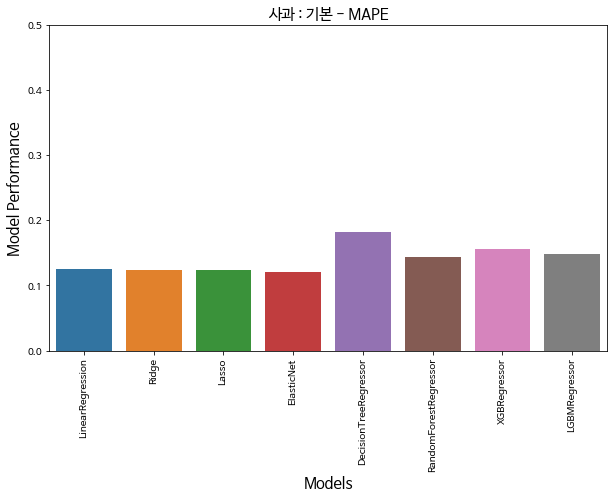

(1159, 16) (1159,) (314, 16) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 196.95it/s]

1 FOLDS: LinearRegression MAPE: 0.1546
2 FOLDS: LinearRegression MAPE: 0.0902
3 FOLDS: LinearRegression MAPE: 0.1163
4 FOLDS: LinearRegression MAPE: 0.1405
5 FOLDS: LinearRegression MAPE: 0.1325

LinearRegression mean MAPE: 0.1268


(1159, 16) (1159,) (314, 16) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 205.80it/s]

1 FOLDS: Ridge MAPE: 0.1474
2 FOLDS: Ridge MAPE: 0.0900
3 FOLDS: Ridge MAPE: 0.1151
4 FOLDS: Ridge MAPE: 0.1404
5 FOLDS: Ridge MAPE: 0.1321

Ridge mean MAPE: 0.1250


(1159, 16) (1159,) (314, 16) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 163.15it/s]

1 FOLDS: Lasso MAPE: 0.1457
2 FOLDS: Lasso MAPE: 0.0899
3 FOLDS: Lasso MAPE: 0.1123
4 FOLDS: Lasso MAPE: 0.1397
5 FOLDS: Lasso MAPE: 0.1309

Lasso mean MAPE: 0.1237


(1159, 16) (1159,) (314, 16) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 192.85it/s]

1 FOLDS: ElasticNet MAPE: 0.1337
2 FOLDS: ElasticNet MAPE: 0.1032
3 FOLDS: ElasticNet MAPE: 0.0852
4 FOLDS: ElasticNet MAPE: 0.1393
5 FOLDS: ElasticNet MAPE: 0.1216

ElasticNet mean MAPE: 0.1166


(1159, 16) (1159,) (314, 16) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 102.34it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1799
2 FOLDS: DecisionTreeRegressor MAPE: 0.1938
3 FOLDS: DecisionTreeRegressor MAPE: 0.1056
4 FOLDS: DecisionTreeRegressor MAPE: 0.1684
5 FOLDS: DecisionTreeRegressor MAPE: 0.3849

DecisionTreeRegressor mean MAPE: 0.2065


(1159, 16) (1159,) (314, 16) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.07it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1681
2 FOLDS: RandomForestRegressor MAPE: 0.1090
3 FOLDS: RandomForestRegressor MAPE: 0.0781
4 FOLDS: RandomForestRegressor MAPE: 0.1234
5 FOLDS: RandomForestRegressor MAPE: 0.2362

RandomForestRegressor mean MAPE: 0.1429
(1159, 16) (1159,) (314, 16) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.93it/s]

[09:08:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 14.91it/s]


[09:08:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.2060
2 FOLDS: XGBRegressor MAPE: 0.1354
3 FOLDS: XGBRegressor MAPE: 0.0748
4 FOLDS: XGBRegressor MAPE: 0.1305
5 FOLDS: XGBRegressor MAPE: 0.2408

XGBRegressor mean MAPE: 0.1575
(1159, 16) (1159,) (314, 16) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.12it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1343
2 FOLDS: LGBMRegressor MAPE: 0.1248
3 FOLDS: LGBMRegressor MAPE: 0.0781
4 FOLDS: LGBMRegressor MAPE: 0.1375
5 FOLDS: LGBMRegressor MAPE: 0.2733

LGBMRegressor mean MAPE: 0.1496


,Model,Score
0,LinearRegression,0.13
1,Ridge,0.13
2,Lasso,0.12
3,ElasticNet,0.12
4,DecisionTreeRegressor,0.21
5,RandomForestRegressor,0.14
6,XGBRegressor,0.16
7,LGBMRegressor,0.15


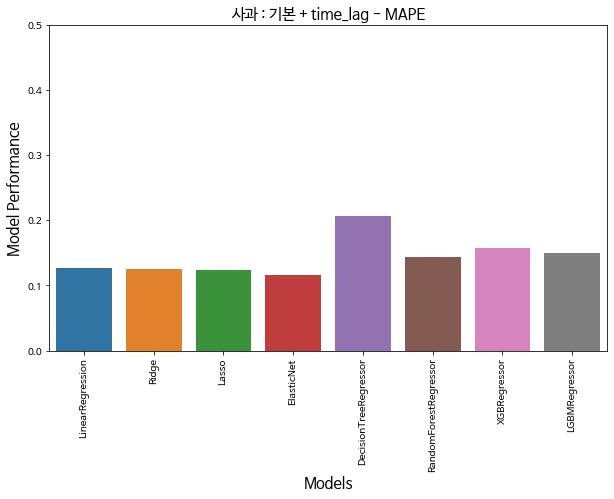

(1159, 17) (1159,) (314, 17) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 184.47it/s]

1 FOLDS: LinearRegression MAPE: 0.1624
2 FOLDS: LinearRegression MAPE: 0.0835
3 FOLDS: LinearRegression MAPE: 0.0775
4 FOLDS: LinearRegression MAPE: 0.1169
5 FOLDS: LinearRegression MAPE: 0.1172

LinearRegression mean MAPE: 0.1115


(1159, 17) (1159,) (314, 17) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 233.26it/s]

1 FOLDS: Ridge MAPE: 0.1538
2 FOLDS: Ridge MAPE: 0.0831
3 FOLDS: Ridge MAPE: 0.0773
4 FOLDS: Ridge MAPE: 0.1169
5 FOLDS: Ridge MAPE: 0.1173

Ridge mean MAPE: 0.1097


(1159, 17) (1159,) (314, 17) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 115.87it/s]

1 FOLDS: Lasso MAPE: 0.1578
2 FOLDS: Lasso MAPE: 0.0815
3 FOLDS: Lasso MAPE: 0.0753
4 FOLDS: Lasso MAPE: 0.1171
5 FOLDS: Lasso MAPE: 0.1166

Lasso mean MAPE: 0.1097


(1159, 17) (1159,) (314, 17) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 192.15it/s]

1 FOLDS: ElasticNet MAPE: 0.1354
2 FOLDS: ElasticNet MAPE: 0.0939
3 FOLDS: ElasticNet MAPE: 0.0784
4 FOLDS: ElasticNet MAPE: 0.1239
5 FOLDS: ElasticNet MAPE: 0.1171

ElasticNet mean MAPE: 0.1097


(1159, 17) (1159,) (314, 17) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 125.79it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1737
2 FOLDS: DecisionTreeRegressor MAPE: 0.1754
3 FOLDS: DecisionTreeRegressor MAPE: 0.0997
4 FOLDS: DecisionTreeRegressor MAPE: 0.1787
5 FOLDS: DecisionTreeRegressor MAPE: 0.1590

DecisionTreeRegressor mean MAPE: 0.1573


(1159, 17) (1159,) (314, 17) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.63it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1562
2 FOLDS: RandomForestRegressor MAPE: 0.1267
3 FOLDS: RandomForestRegressor MAPE: 0.0751
4 FOLDS: RandomForestRegressor MAPE: 0.1201
5 FOLDS: RandomForestRegressor MAPE: 0.1242

RandomForestRegressor mean MAPE: 0.1204
(1159, 17) (1159,) (314, 17) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.92it/s]

[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 17.88it/s]


1 FOLDS: XGBRegressor MAPE: 0.1825
2 FOLDS: XGBRegressor MAPE: 0.1201
3 FOLDS: XGBRegressor MAPE: 0.0752
4 FOLDS: XGBRegressor MAPE: 0.1133
5 FOLDS: XGBRegressor MAPE: 0.1105

XGBRegressor mean MAPE: 0.1203
(1159, 17) (1159,) (314, 17) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.66it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1577
2 FOLDS: LGBMRegressor MAPE: 0.1287
3 FOLDS: LGBMRegressor MAPE: 0.0662
4 FOLDS: LGBMRegressor MAPE: 0.1159
5 FOLDS: LGBMRegressor MAPE: 0.1218

LGBMRegressor mean MAPE: 0.1181


,Model,Score
0,LinearRegression,0.11
1,Ridge,0.11
2,Lasso,0.11
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.16
5,RandomForestRegressor,0.12
6,XGBRegressor,0.12
7,LGBMRegressor,0.12


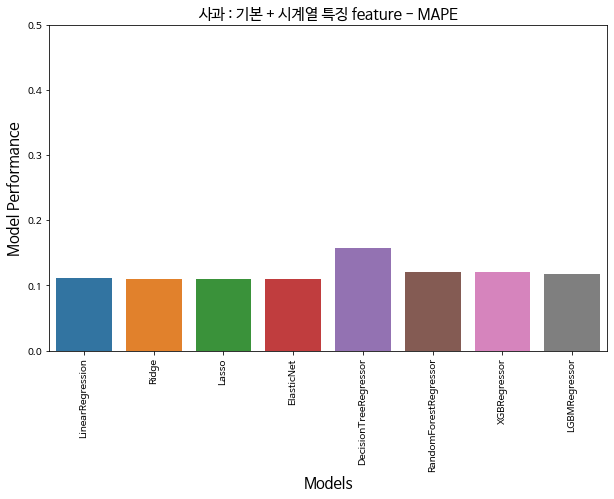

(1159, 24) (1159,) (314, 24) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 177.86it/s]

1 FOLDS: LinearRegression MAPE: 0.1681
2 FOLDS: LinearRegression MAPE: 0.1134
3 FOLDS: LinearRegression MAPE: 0.1416
4 FOLDS: LinearRegression MAPE: 0.1336
5 FOLDS: LinearRegression MAPE: 0.2101

LinearRegression mean MAPE: 0.1533


(1159, 24) (1159,) (314, 24) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 183.75it/s]

1 FOLDS: Ridge MAPE: 0.1608
2 FOLDS: Ridge MAPE: 0.1101
3 FOLDS: Ridge MAPE: 0.1405
4 FOLDS: Ridge MAPE: 0.1336
5 FOLDS: Ridge MAPE: 0.2024

Ridge mean MAPE: 0.1495


(1159, 24) (1159,) (314, 24) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 128.76it/s]

1 FOLDS: Lasso MAPE: 0.1524
2 FOLDS: Lasso MAPE: 0.1051
3 FOLDS: Lasso MAPE: 0.1238
4 FOLDS: Lasso MAPE: 0.1335
5 FOLDS: Lasso MAPE: 0.1838

Lasso mean MAPE: 0.1397


(1159, 24) (1159,) (314, 24) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 173.34it/s]

1 FOLDS: ElasticNet MAPE: 0.1507
2 FOLDS: ElasticNet MAPE: 0.1073
3 FOLDS: ElasticNet MAPE: 0.1165
4 FOLDS: ElasticNet MAPE: 0.1398
5 FOLDS: ElasticNet MAPE: 0.1258

ElasticNet mean MAPE: 0.1280


(1159, 24) (1159,) (314, 24) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 98.25it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1480
2 FOLDS: DecisionTreeRegressor MAPE: 0.3636
3 FOLDS: DecisionTreeRegressor MAPE: 0.1471
4 FOLDS: DecisionTreeRegressor MAPE: 0.1866
5 FOLDS: DecisionTreeRegressor MAPE: 0.3435

DecisionTreeRegressor mean MAPE: 0.2378


(1159, 24) (1159,) (314, 24) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.95it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1564
2 FOLDS: RandomForestRegressor MAPE: 0.1251
3 FOLDS: RandomForestRegressor MAPE: 0.0820
4 FOLDS: RandomForestRegressor MAPE: 0.1440
5 FOLDS: RandomForestRegressor MAPE: 0.2234

RandomForestRegressor mean MAPE: 0.1462
(1159, 24) (1159,) (314, 24) (314,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.05it/s]

[09:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.59it/s]


[09:10:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1613
2 FOLDS: XGBRegressor MAPE: 0.1260
3 FOLDS: XGBRegressor MAPE: 0.0820
4 FOLDS: XGBRegressor MAPE: 0.1509
5 FOLDS: XGBRegressor MAPE: 0.1617

XGBRegressor mean MAPE: 0.1364
(1159, 24) (1159,) (314, 24) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.74it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1321
2 FOLDS: LGBMRegressor MAPE: 0.1154
3 FOLDS: LGBMRegressor MAPE: 0.0832
4 FOLDS: LGBMRegressor MAPE: 0.1489
5 FOLDS: LGBMRegressor MAPE: 0.2590

LGBMRegressor mean MAPE: 0.1477


,Model,Score
0,LinearRegression,0.15
1,Ridge,0.15
2,Lasso,0.14
3,ElasticNet,0.13
4,DecisionTreeRegressor,0.24
5,RandomForestRegressor,0.15
6,XGBRegressor,0.14
7,LGBMRegressor,0.15


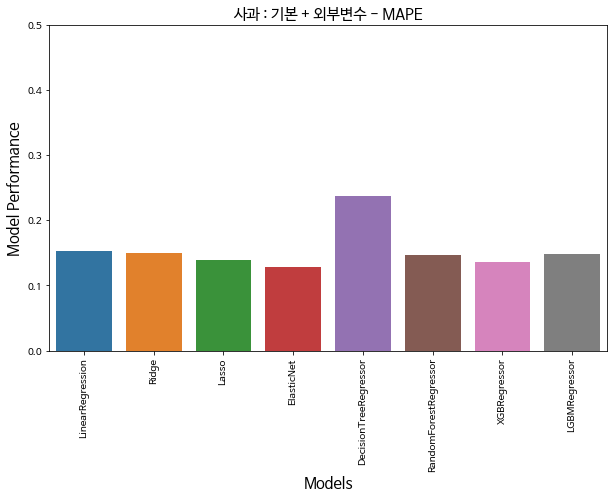

(1159, 26) (1159,) (314, 26) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 158.75it/s]

1 FOLDS: LinearRegression MAPE: 0.1374
2 FOLDS: LinearRegression MAPE: 0.0664
3 FOLDS: LinearRegression MAPE: 0.0623
4 FOLDS: LinearRegression MAPE: 0.0773
5 FOLDS: LinearRegression MAPE: 0.0720

LinearRegression mean MAPE: 0.0831


(1159, 26) (1159,) (314, 26) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 187.70it/s]

1 FOLDS: Ridge MAPE: 0.1280
2 FOLDS: Ridge MAPE: 0.0658
3 FOLDS: Ridge MAPE: 0.0622
4 FOLDS: Ridge MAPE: 0.0779
5 FOLDS: Ridge MAPE: 0.0723

Ridge mean MAPE: 0.0812


(1159, 26) (1159,) (314, 26) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 81.41it/s]

1 FOLDS: Lasso MAPE: 0.1267
2 FOLDS: Lasso MAPE: 0.0649
3 FOLDS: Lasso MAPE: 0.0597
4 FOLDS: Lasso MAPE: 0.0786
5 FOLDS: Lasso MAPE: 0.0718

Lasso mean MAPE: 0.0803


(1159, 26) (1159,) (314, 26) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 144.50it/s]

1 FOLDS: ElasticNet MAPE: 0.1268
2 FOLDS: ElasticNet MAPE: 0.0912
3 FOLDS: ElasticNet MAPE: 0.0741
4 FOLDS: ElasticNet MAPE: 0.1250
5 FOLDS: ElasticNet MAPE: 0.1084

ElasticNet mean MAPE: 0.1051


(1159, 26) (1159,) (314, 26) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 85.32it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1798
2 FOLDS: DecisionTreeRegressor MAPE: 0.2231
3 FOLDS: DecisionTreeRegressor MAPE: 0.0798
4 FOLDS: DecisionTreeRegressor MAPE: 0.1165
5 FOLDS: DecisionTreeRegressor MAPE: 0.1576

DecisionTreeRegressor mean MAPE: 0.1513


(1159, 26) (1159,) (314, 26) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.76it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1401
2 FOLDS: RandomForestRegressor MAPE: 0.0936
3 FOLDS: RandomForestRegressor MAPE: 0.0524
4 FOLDS: RandomForestRegressor MAPE: 0.1019
5 FOLDS: RandomForestRegressor MAPE: 0.1260

RandomForestRegressor mean MAPE: 0.1028
(1159, 26) (1159,) (314, 26) (314,)


XGBRegressor Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

[09:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 15.82it/s]

[09:10:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:10:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.71it/s]

1 FOLDS: XGBRegressor MAPE: 0.1526
2 FOLDS: XGBRegressor MAPE: 0.1107
3 FOLDS: XGBRegressor MAPE: 0.0637
4 FOLDS: XGBRegressor MAPE: 0.1088
5 FOLDS: XGBRegressor MAPE: 0.1025

XGBRegressor mean MAPE: 0.1076


(1159, 26) (1159,) (314, 26) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.49it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1306
2 FOLDS: LGBMRegressor MAPE: 0.1391
3 FOLDS: LGBMRegressor MAPE: 0.0600
4 FOLDS: LGBMRegressor MAPE: 0.1089
5 FOLDS: LGBMRegressor MAPE: 0.1202

LGBMRegressor mean MAPE: 0.1118


,Model,Score
0,LinearRegression,0.08
1,Ridge,0.08
2,Lasso,0.08
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.15
5,RandomForestRegressor,0.10
6,XGBRegressor,0.11
7,LGBMRegressor,0.11


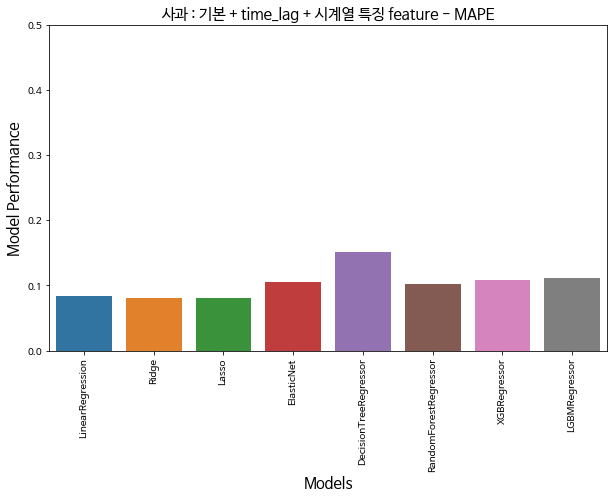

(1159, 34) (1159,) (314, 34) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 142.04it/s]

1 FOLDS: LinearRegression MAPE: 0.1892
2 FOLDS: LinearRegression MAPE: 0.1003
3 FOLDS: LinearRegression MAPE: 0.1230
4 FOLDS: LinearRegression MAPE: 0.1206
5 FOLDS: LinearRegression MAPE: 0.1675

LinearRegression mean MAPE: 0.1401


(1159, 34) (1159,) (314, 34) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 169.50it/s]

1 FOLDS: Ridge MAPE: 0.1466
2 FOLDS: Ridge MAPE: 0.0967
3 FOLDS: Ridge MAPE: 0.1231
4 FOLDS: Ridge MAPE: 0.1208
5 FOLDS: Ridge MAPE: 0.1596

Ridge mean MAPE: 0.1294


(1159, 34) (1159,) (314, 34) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 74.06it/s]

1 FOLDS: Lasso MAPE: 0.1523
2 FOLDS: Lasso MAPE: 0.0936
3 FOLDS: Lasso MAPE: 0.1113
4 FOLDS: Lasso MAPE: 0.1191
5 FOLDS: Lasso MAPE: 0.1368

Lasso mean MAPE: 0.1226


(1159, 34) (1159,) (314, 34) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 164.46it/s]

1 FOLDS: ElasticNet MAPE: 0.1439
2 FOLDS: ElasticNet MAPE: 0.0930
3 FOLDS: ElasticNet MAPE: 0.0941
4 FOLDS: ElasticNet MAPE: 0.1253
5 FOLDS: ElasticNet MAPE: 0.1176

ElasticNet mean MAPE: 0.1148


(1159, 34) (1159,) (314, 34) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 80.90it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1516
2 FOLDS: DecisionTreeRegressor MAPE: 0.2528
3 FOLDS: DecisionTreeRegressor MAPE: 0.1101
4 FOLDS: DecisionTreeRegressor MAPE: 0.1967
5 FOLDS: DecisionTreeRegressor MAPE: 0.2055

DecisionTreeRegressor mean MAPE: 0.1833


(1159, 34) (1159,) (314, 34) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.65it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1548
2 FOLDS: RandomForestRegressor MAPE: 0.1009
3 FOLDS: RandomForestRegressor MAPE: 0.0708
4 FOLDS: RandomForestRegressor MAPE: 0.1227
5 FOLDS: RandomForestRegressor MAPE: 0.1273

RandomForestRegressor mean MAPE: 0.1153
(1159, 34) (1159,) (314, 34) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.63it/s]

[09:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.28it/s]

[09:11:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.48it/s]


1 FOLDS: XGBRegressor MAPE: 0.1999
2 FOLDS: XGBRegressor MAPE: 0.1091
3 FOLDS: XGBRegressor MAPE: 0.0848
4 FOLDS: XGBRegressor MAPE: 0.1249
5 FOLDS: XGBRegressor MAPE: 0.1165

XGBRegressor mean MAPE: 0.1270
(1159, 34) (1159,) (314, 34) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.15it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1519
2 FOLDS: LGBMRegressor MAPE: 0.1169
3 FOLDS: LGBMRegressor MAPE: 0.0785
4 FOLDS: LGBMRegressor MAPE: 0.1196
5 FOLDS: LGBMRegressor MAPE: 0.1602

LGBMRegressor mean MAPE: 0.1254


,Model,Score
0,LinearRegression,0.14
1,Ridge,0.13
2,Lasso,0.12
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.18
5,RandomForestRegressor,0.12
6,XGBRegressor,0.13
7,LGBMRegressor,0.13


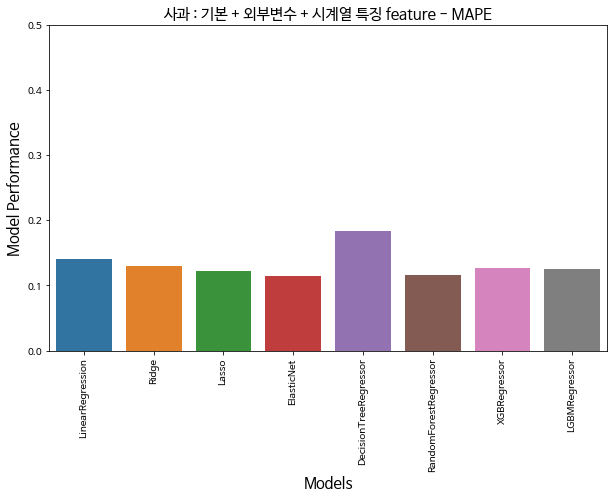

(1159, 33) (1159,) (314, 33) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 150.81it/s]

1 FOLDS: LinearRegression MAPE: 0.1646
2 FOLDS: LinearRegression MAPE: 0.0977
3 FOLDS: LinearRegression MAPE: 0.1459
4 FOLDS: LinearRegression MAPE: 0.1375
5 FOLDS: LinearRegression MAPE: 0.2030

LinearRegression mean MAPE: 0.1497


(1159, 33) (1159,) (314, 33) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 172.61it/s]

1 FOLDS: Ridge MAPE: 0.1846
2 FOLDS: Ridge MAPE: 0.0969
3 FOLDS: Ridge MAPE: 0.1435
4 FOLDS: Ridge MAPE: 0.1372
5 FOLDS: Ridge MAPE: 0.1956

Ridge mean MAPE: 0.1516


(1159, 33) (1159,) (314, 33) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 112.37it/s]

1 FOLDS: Lasso MAPE: 0.1512
2 FOLDS: Lasso MAPE: 0.0960
3 FOLDS: Lasso MAPE: 0.1280
4 FOLDS: Lasso MAPE: 0.1375
5 FOLDS: Lasso MAPE: 0.1767

Lasso mean MAPE: 0.1379


(1159, 33) (1159,) (314, 33) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 126.89it/s]

1 FOLDS: ElasticNet MAPE: 0.1447
2 FOLDS: ElasticNet MAPE: 0.1008
3 FOLDS: ElasticNet MAPE: 0.1042
4 FOLDS: ElasticNet MAPE: 0.1404
5 FOLDS: ElasticNet MAPE: 0.1228

ElasticNet mean MAPE: 0.1226


(1159, 33) (1159,) (314, 33) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 69.79it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1509
2 FOLDS: DecisionTreeRegressor MAPE: 0.2281
3 FOLDS: DecisionTreeRegressor MAPE: 0.1228
4 FOLDS: DecisionTreeRegressor MAPE: 0.1722
5 FOLDS: DecisionTreeRegressor MAPE: 0.3008

DecisionTreeRegressor mean MAPE: 0.1950


(1159, 33) (1159,) (314, 33) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.35it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1563
2 FOLDS: RandomForestRegressor MAPE: 0.1188
3 FOLDS: RandomForestRegressor MAPE: 0.0745
4 FOLDS: RandomForestRegressor MAPE: 0.1445
5 FOLDS: RandomForestRegressor MAPE: 0.2448

RandomForestRegressor mean MAPE: 0.1478
(1159, 33) (1159,) (314, 33) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.16it/s]

[09:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 10.92it/s]

[09:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:12:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.84it/s]


1 FOLDS: XGBRegressor MAPE: 0.1519
2 FOLDS: XGBRegressor MAPE: 0.1142
3 FOLDS: XGBRegressor MAPE: 0.0747
4 FOLDS: XGBRegressor MAPE: 0.1418
5 FOLDS: XGBRegressor MAPE: 0.2378

XGBRegressor mean MAPE: 0.1441
(1159, 33) (1159,) (314, 33) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.57it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1258
2 FOLDS: LGBMRegressor MAPE: 0.1023
3 FOLDS: LGBMRegressor MAPE: 0.0783
4 FOLDS: LGBMRegressor MAPE: 0.1466
5 FOLDS: LGBMRegressor MAPE: 0.2926

LGBMRegressor mean MAPE: 0.1491


,Model,Score
0,LinearRegression,0.15
1,Ridge,0.15
2,Lasso,0.14
3,ElasticNet,0.12
4,DecisionTreeRegressor,0.19
5,RandomForestRegressor,0.15
6,XGBRegressor,0.14
7,LGBMRegressor,0.15


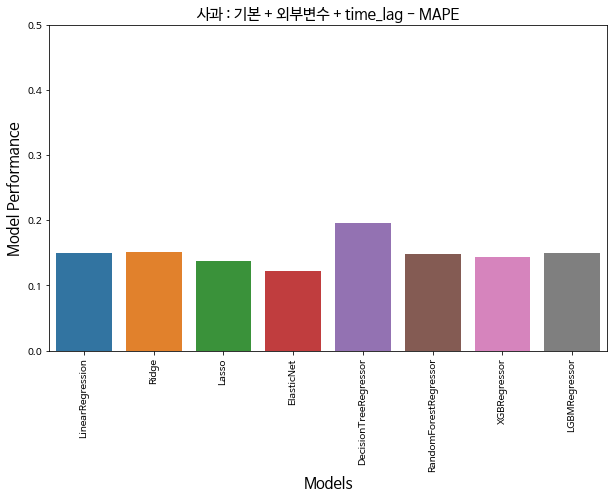

(1159, 43) (1159,) (314, 43) (314,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 129.43it/s]

1 FOLDS: LinearRegression MAPE: 0.2253
2 FOLDS: LinearRegression MAPE: 0.1224
3 FOLDS: LinearRegression MAPE: 0.1148
4 FOLDS: LinearRegression MAPE: 0.0783
5 FOLDS: LinearRegression MAPE: 0.1170

LinearRegression mean MAPE: 0.1316


(1159, 43) (1159,) (314, 43) (314,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 164.95it/s]

1 FOLDS: Ridge MAPE: 0.1616
2 FOLDS: Ridge MAPE: 0.0930
3 FOLDS: Ridge MAPE: 0.1152
4 FOLDS: Ridge MAPE: 0.0785
5 FOLDS: Ridge MAPE: 0.1113

Ridge mean MAPE: 0.1119


(1159, 43) (1159,) (314, 43) (314,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 65.84it/s]

1 FOLDS: Lasso MAPE: 0.1592
2 FOLDS: Lasso MAPE: 0.0705
3 FOLDS: Lasso MAPE: 0.1026
4 FOLDS: Lasso MAPE: 0.0805
5 FOLDS: Lasso MAPE: 0.0913

Lasso mean MAPE: 0.1008


(1159, 43) (1159,) (314, 43) (314,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 145.39it/s]

1 FOLDS: ElasticNet MAPE: 0.1347
2 FOLDS: ElasticNet MAPE: 0.0889
3 FOLDS: ElasticNet MAPE: 0.0917
4 FOLDS: ElasticNet MAPE: 0.1265
5 FOLDS: ElasticNet MAPE: 0.1087

ElasticNet mean MAPE: 0.1101


(1159, 43) (1159,) (314, 43) (314,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 59.47it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.1535
2 FOLDS: DecisionTreeRegressor MAPE: 0.1857
3 FOLDS: DecisionTreeRegressor MAPE: 0.0798
4 FOLDS: DecisionTreeRegressor MAPE: 0.1522
5 FOLDS: DecisionTreeRegressor MAPE: 0.1980

DecisionTreeRegressor mean MAPE: 0.1538


(1159, 43) (1159,) (314, 43) (314,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:04<00:04,  1.25it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1428
2 FOLDS: RandomForestRegressor MAPE: 0.1116
3 FOLDS: RandomForestRegressor MAPE: 0.0516
4 FOLDS: RandomForestRegressor MAPE: 0.1111
5 FOLDS: RandomForestRegressor MAPE: 0.1230

RandomForestRegressor mean MAPE: 0.1080
(1159, 43) (1159,) (314, 43) (314,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.85it/s]

[09:13:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 10.00it/s]

[09:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:13:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.93it/s]


1 FOLDS: XGBRegressor MAPE: 0.1922
2 FOLDS: XGBRegressor MAPE: 0.1049
3 FOLDS: XGBRegressor MAPE: 0.0659
4 FOLDS: XGBRegressor MAPE: 0.1119
5 FOLDS: XGBRegressor MAPE: 0.1028

XGBRegressor mean MAPE: 0.1155
(1159, 43) (1159,) (314, 43) (314,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.87it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1250
2 FOLDS: LGBMRegressor MAPE: 0.1251
3 FOLDS: LGBMRegressor MAPE: 0.0595
4 FOLDS: LGBMRegressor MAPE: 0.1124
5 FOLDS: LGBMRegressor MAPE: 0.1264

LGBMRegressor mean MAPE: 0.1097


,Model,Score
0,LinearRegression,0.13
1,Ridge,0.11
2,Lasso,0.10
3,ElasticNet,0.11
4,DecisionTreeRegressor,0.15
5,RandomForestRegressor,0.11
6,XGBRegressor,0.12
7,LGBMRegressor,0.11


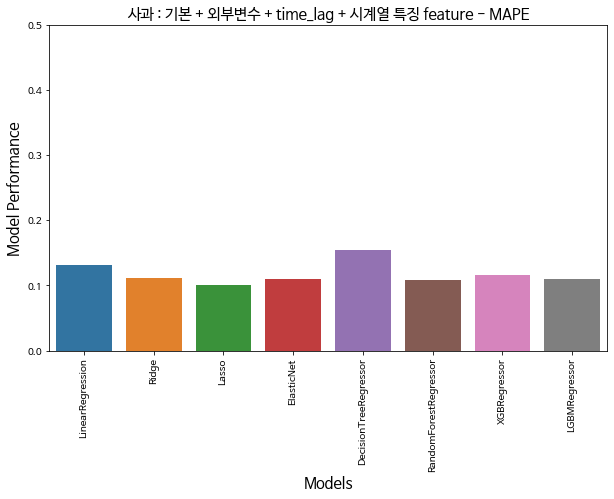

In [ ]:
modeling1('사과')
modeling2('사과')
modeling3('사과')
modeling4('사과')
modeling5('사과')
modeling6('사과')
modeling7('사과')
modeling8('사과')

## 건고추

(1142, 7) (1142,) (309, 7) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 247.83it/s]

1 FOLDS: LinearRegression MAPE: 0.2007
2 FOLDS: LinearRegression MAPE: 0.2715
3 FOLDS: LinearRegression MAPE: 3.2419
4 FOLDS: LinearRegression MAPE: 0.4458
5 FOLDS: LinearRegression MAPE: 0.3318

LinearRegression mean MAPE: 0.8983


(1142, 7) (1142,) (309, 7) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 238.19it/s]

1 FOLDS: Ridge MAPE: 0.1975
2 FOLDS: Ridge MAPE: 0.2728
3 FOLDS: Ridge MAPE: 3.2052
4 FOLDS: Ridge MAPE: 0.4433
5 FOLDS: Ridge MAPE: 0.3309

Ridge mean MAPE: 0.8900


(1142, 7) (1142,) (309, 7) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 230.01it/s]

1 FOLDS: Lasso MAPE: 0.1992
2 FOLDS: Lasso MAPE: 0.2719
3 FOLDS: Lasso MAPE: 3.2372
4 FOLDS: Lasso MAPE: 0.4453
5 FOLDS: Lasso MAPE: 0.3316

Lasso mean MAPE: 0.8970


(1142, 7) (1142,) (309, 7) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 211.89it/s]

1 FOLDS: ElasticNet MAPE: 0.1707
2 FOLDS: ElasticNet MAPE: 0.3006
3 FOLDS: ElasticNet MAPE: 2.4117
4 FOLDS: ElasticNet MAPE: 0.3468
5 FOLDS: ElasticNet MAPE: 0.2891

ElasticNet mean MAPE: 0.7038


(1142, 7) (1142,) (309, 7) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 172.61it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2454
2 FOLDS: DecisionTreeRegressor MAPE: 0.3825
3 FOLDS: DecisionTreeRegressor MAPE: 2.6479
4 FOLDS: DecisionTreeRegressor MAPE: 0.5349
5 FOLDS: DecisionTreeRegressor MAPE: 0.4674

DecisionTreeRegressor mean MAPE: 0.8556


(1142, 7) (1142,) (309, 7) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.73it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1962
2 FOLDS: RandomForestRegressor MAPE: 0.3082
3 FOLDS: RandomForestRegressor MAPE: 2.2847
4 FOLDS: RandomForestRegressor MAPE: 0.4730
5 FOLDS: RandomForestRegressor MAPE: 0.3600

RandomForestRegressor mean MAPE: 0.7244
(1142, 7) (1142,) (309, 7) (309,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 28.10it/s]

[09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1899
2 FOLDS: XGBRegressor MAPE: 0.3030
3 FOLDS: XGBRegressor MAPE: 2.2910
4 FOLDS: XGBRegressor MAPE: 0.4138
5 FOLDS: XGBRegressor MAPE: 0.3664

XGBRegressor mean MAPE: 0.7128


(1142, 7) (1142,) (309, 7) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 21.12it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1915
2 FOLDS: LGBMRegressor MAPE: 0.4012
3 FOLDS: LGBMRegressor MAPE: 2.0709
4 FOLDS: LGBMRegressor MAPE: 0.4479
5 FOLDS: LGBMRegressor MAPE: 0.3545

LGBMRegressor mean MAPE: 0.6932


,Model,Score
0,LinearRegression,0.90
1,Ridge,0.89
2,Lasso,0.90
3,ElasticNet,0.70
4,DecisionTreeRegressor,0.86
5,RandomForestRegressor,0.72
6,XGBRegressor,0.71
7,LGBMRegressor,0.69


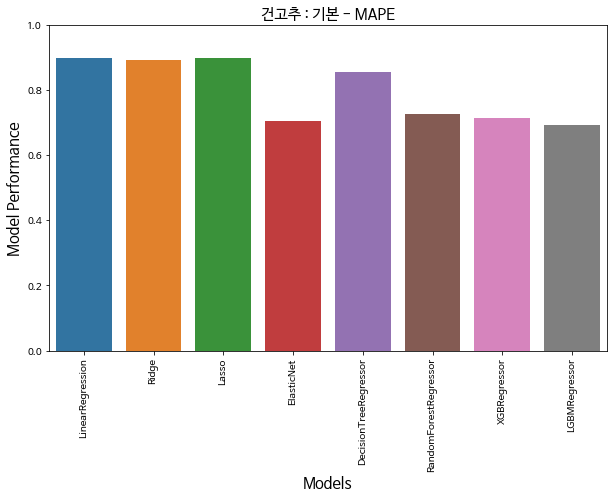

(1142, 16) (1142,) (309, 16) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 200.94it/s]

1 FOLDS: LinearRegression MAPE: 0.2217
2 FOLDS: LinearRegression MAPE: 0.2653
3 FOLDS: LinearRegression MAPE: 2.9342
4 FOLDS: LinearRegression MAPE: 0.4046
5 FOLDS: LinearRegression MAPE: 0.3207

LinearRegression mean MAPE: 0.8293


(1142, 16) (1142,) (309, 16) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 224.24it/s]

1 FOLDS: Ridge MAPE: 0.2165
2 FOLDS: Ridge MAPE: 0.2663
3 FOLDS: Ridge MAPE: 2.9110
4 FOLDS: Ridge MAPE: 0.4028
5 FOLDS: Ridge MAPE: 0.3203

Ridge mean MAPE: 0.8234


(1142, 16) (1142,) (309, 16) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 200.20it/s]

1 FOLDS: Lasso MAPE: 0.2185
2 FOLDS: Lasso MAPE: 0.2657
3 FOLDS: Lasso MAPE: 2.9294
4 FOLDS: Lasso MAPE: 0.4041
5 FOLDS: Lasso MAPE: 0.3205

Lasso mean MAPE: 0.8276


(1142, 16) (1142,) (309, 16) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 207.78it/s]

1 FOLDS: ElasticNet MAPE: 0.1724
2 FOLDS: ElasticNet MAPE: 0.2933
3 FOLDS: ElasticNet MAPE: 2.4656
4 FOLDS: ElasticNet MAPE: 0.3285
5 FOLDS: ElasticNet MAPE: 0.2956

ElasticNet mean MAPE: 0.7111


(1142, 16) (1142,) (309, 16) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 94.91it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2699
2 FOLDS: DecisionTreeRegressor MAPE: 0.3443
3 FOLDS: DecisionTreeRegressor MAPE: 3.3170
4 FOLDS: DecisionTreeRegressor MAPE: 0.3890
5 FOLDS: DecisionTreeRegressor MAPE: 0.4177

DecisionTreeRegressor mean MAPE: 0.9476


(1142, 16) (1142,) (309, 16) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.96it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1902
2 FOLDS: RandomForestRegressor MAPE: 0.2814
3 FOLDS: RandomForestRegressor MAPE: 3.1635
4 FOLDS: RandomForestRegressor MAPE: 0.3351
5 FOLDS: RandomForestRegressor MAPE: 0.3416

RandomForestRegressor mean MAPE: 0.8624
(1142, 16) (1142,) (309, 16) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.47it/s]

[09:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.59it/s]


[09:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1951
2 FOLDS: XGBRegressor MAPE: 0.2674
3 FOLDS: XGBRegressor MAPE: 3.0184
4 FOLDS: XGBRegressor MAPE: 0.3462
5 FOLDS: XGBRegressor MAPE: 0.3306

XGBRegressor mean MAPE: 0.8315
(1142, 16) (1142,) (309, 16) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.56it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1900
2 FOLDS: LGBMRegressor MAPE: 0.2920
3 FOLDS: LGBMRegressor MAPE: 3.0312
4 FOLDS: LGBMRegressor MAPE: 0.3930
5 FOLDS: LGBMRegressor MAPE: 0.3591

LGBMRegressor mean MAPE: 0.8531


,Model,Score
0,LinearRegression,0.83
1,Ridge,0.82
2,Lasso,0.83
3,ElasticNet,0.71
4,DecisionTreeRegressor,0.95
5,RandomForestRegressor,0.86
6,XGBRegressor,0.83
7,LGBMRegressor,0.85


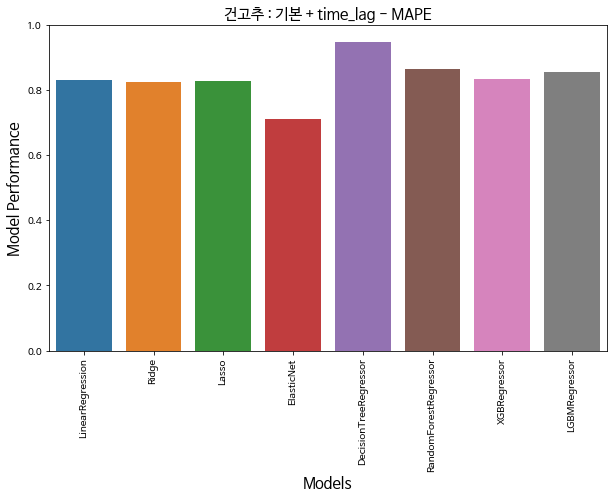

(1142, 17) (1142,) (309, 17) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 183.71it/s]

1 FOLDS: LinearRegression MAPE: 0.2351
2 FOLDS: LinearRegression MAPE: 0.2322
3 FOLDS: LinearRegression MAPE: 2.6746
4 FOLDS: LinearRegression MAPE: 0.3633
5 FOLDS: LinearRegression MAPE: 0.3073

LinearRegression mean MAPE: 0.7625


(1142, 17) (1142,) (309, 17) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 189.18it/s]

1 FOLDS: Ridge MAPE: 0.2223
2 FOLDS: Ridge MAPE: 0.2328
3 FOLDS: Ridge MAPE: 2.6677
4 FOLDS: Ridge MAPE: 0.3627
5 FOLDS: Ridge MAPE: 0.3072

Ridge mean MAPE: 0.7585


(1142, 17) (1142,) (309, 17) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 91.57it/s]

1 FOLDS: Lasso MAPE: 0.2324
2 FOLDS: Lasso MAPE: 0.2326
3 FOLDS: Lasso MAPE: 2.6694
4 FOLDS: Lasso MAPE: 0.3628
5 FOLDS: Lasso MAPE: 0.3071

Lasso mean MAPE: 0.7609


(1142, 17) (1142,) (309, 17) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 173.49it/s]

1 FOLDS: ElasticNet MAPE: 0.1735
2 FOLDS: ElasticNet MAPE: 0.2800
3 FOLDS: ElasticNet MAPE: 2.4679
4 FOLDS: ElasticNet MAPE: 0.3197
5 FOLDS: ElasticNet MAPE: 0.2817

ElasticNet mean MAPE: 0.7046


(1142, 17) (1142,) (309, 17) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 116.53it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2987
2 FOLDS: DecisionTreeRegressor MAPE: 1.5490
3 FOLDS: DecisionTreeRegressor MAPE: 3.5268
4 FOLDS: DecisionTreeRegressor MAPE: 3.3781
5 FOLDS: DecisionTreeRegressor MAPE: 0.5303

DecisionTreeRegressor mean MAPE: 1.8566


(1142, 17) (1142,) (309, 17) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.58it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1996
2 FOLDS: RandomForestRegressor MAPE: 0.9527
3 FOLDS: RandomForestRegressor MAPE: 2.7883
4 FOLDS: RandomForestRegressor MAPE: 0.7622
5 FOLDS: RandomForestRegressor MAPE: 0.3596

RandomForestRegressor mean MAPE: 1.0125
(1142, 17) (1142,) (309, 17) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 23.76it/s]

[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 17.30it/s]


[09:39:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1935
2 FOLDS: XGBRegressor MAPE: 1.4432
3 FOLDS: XGBRegressor MAPE: 2.5891
4 FOLDS: XGBRegressor MAPE: 1.3977
5 FOLDS: XGBRegressor MAPE: 0.3270

XGBRegressor mean MAPE: 1.1901
(1142, 17) (1142,) (309, 17) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.63it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1917
2 FOLDS: LGBMRegressor MAPE: 0.3184
3 FOLDS: LGBMRegressor MAPE: 2.5966
4 FOLDS: LGBMRegressor MAPE: 0.4527
5 FOLDS: LGBMRegressor MAPE: 0.3823

LGBMRegressor mean MAPE: 0.7884


,Model,Score
0,LinearRegression,0.76
1,Ridge,0.76
2,Lasso,0.76
3,ElasticNet,0.70
4,DecisionTreeRegressor,1.86
5,RandomForestRegressor,1.01
6,XGBRegressor,1.19
7,LGBMRegressor,0.79


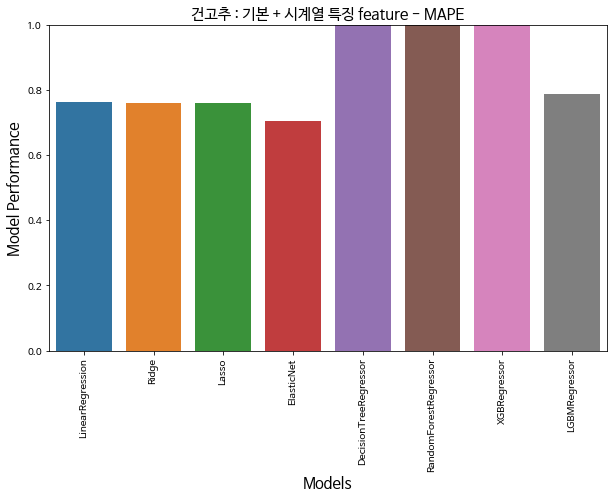

(1142, 24) (1142,) (309, 24) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 168.79it/s]

1 FOLDS: LinearRegression MAPE: 0.3808
2 FOLDS: LinearRegression MAPE: 0.4821
3 FOLDS: LinearRegression MAPE: 2.5423
4 FOLDS: LinearRegression MAPE: 0.4385
5 FOLDS: LinearRegression MAPE: 0.3384

LinearRegression mean MAPE: 0.8364


(1142, 24) (1142,) (309, 24) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 185.02it/s]

1 FOLDS: Ridge MAPE: 0.2558
2 FOLDS: Ridge MAPE: 0.4255
3 FOLDS: Ridge MAPE: 2.3789
4 FOLDS: Ridge MAPE: 0.4308
5 FOLDS: Ridge MAPE: 0.3370

Ridge mean MAPE: 0.7656


(1142, 24) (1142,) (309, 24) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 68.61it/s]

1 FOLDS: Lasso MAPE: 0.3311
2 FOLDS: Lasso MAPE: 0.4644
3 FOLDS: Lasso MAPE: 2.2288
4 FOLDS: Lasso MAPE: 0.4380
5 FOLDS: Lasso MAPE: 0.3375

Lasso mean MAPE: 0.7600


(1142, 24) (1142,) (309, 24) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 180.66it/s]

1 FOLDS: ElasticNet MAPE: 0.1680
2 FOLDS: ElasticNet MAPE: 0.3107
3 FOLDS: ElasticNet MAPE: 2.4614
4 FOLDS: ElasticNet MAPE: 0.3485
5 FOLDS: ElasticNet MAPE: 0.2872

ElasticNet mean MAPE: 0.7151


(1142, 24) (1142,) (309, 24) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 93.67it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2538
2 FOLDS: DecisionTreeRegressor MAPE: 0.3874
3 FOLDS: DecisionTreeRegressor MAPE: 2.1238
4 FOLDS: DecisionTreeRegressor MAPE: 0.7022
5 FOLDS: DecisionTreeRegressor MAPE: 0.4325

DecisionTreeRegressor mean MAPE: 0.7799


(1142, 24) (1142,) (309, 24) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.95it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1728
2 FOLDS: RandomForestRegressor MAPE: 0.3033
3 FOLDS: RandomForestRegressor MAPE: 2.7790
4 FOLDS: RandomForestRegressor MAPE: 0.3938
5 FOLDS: RandomForestRegressor MAPE: 0.3235

RandomForestRegressor mean MAPE: 0.7945
(1142, 24) (1142,) (309, 24) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 19.55it/s]

[09:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.02it/s]


[09:39:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1838
2 FOLDS: XGBRegressor MAPE: 0.3000
3 FOLDS: XGBRegressor MAPE: 2.2025
4 FOLDS: XGBRegressor MAPE: 0.4653
5 FOLDS: XGBRegressor MAPE: 0.3363

XGBRegressor mean MAPE: 0.6976
(1142, 24) (1142,) (309, 24) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.64it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1899
2 FOLDS: LGBMRegressor MAPE: 0.3414
3 FOLDS: LGBMRegressor MAPE: 1.7376
4 FOLDS: LGBMRegressor MAPE: 0.4592
5 FOLDS: LGBMRegressor MAPE: 0.3620

LGBMRegressor mean MAPE: 0.6180


,Model,Score
0,LinearRegression,0.84
1,Ridge,0.77
2,Lasso,0.76
3,ElasticNet,0.72
4,DecisionTreeRegressor,0.78
5,RandomForestRegressor,0.79
6,XGBRegressor,0.70
7,LGBMRegressor,0.62


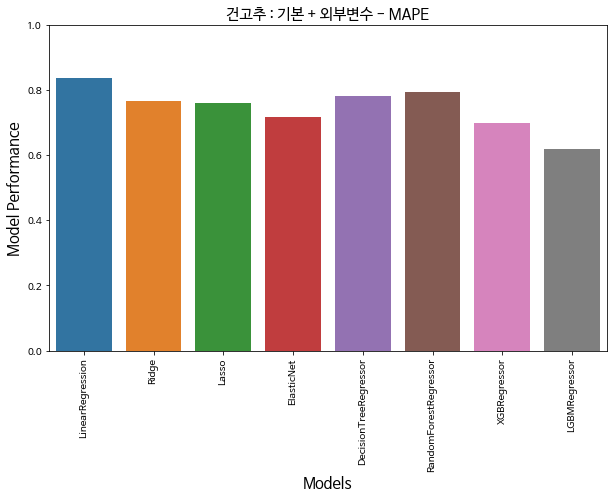

(1142, 26) (1142,) (309, 26) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 160.00it/s]

1 FOLDS: LinearRegression MAPE: 0.2545
2 FOLDS: LinearRegression MAPE: 0.2233
3 FOLDS: LinearRegression MAPE: 2.7301
4 FOLDS: LinearRegression MAPE: 0.3530
5 FOLDS: LinearRegression MAPE: 0.3099

LinearRegression mean MAPE: 0.7742


(1142, 26) (1142,) (309, 26) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 187.18it/s]

1 FOLDS: Ridge MAPE: 0.2366
2 FOLDS: Ridge MAPE: 0.2248
3 FOLDS: Ridge MAPE: 2.7220
4 FOLDS: Ridge MAPE: 0.3530
5 FOLDS: Ridge MAPE: 0.3097

Ridge mean MAPE: 0.7692


(1142, 26) (1142,) (309, 26) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 68.20it/s]

1 FOLDS: Lasso MAPE: 0.2512
2 FOLDS: Lasso MAPE: 0.2237
3 FOLDS: Lasso MAPE: 2.7238
4 FOLDS: Lasso MAPE: 0.3527
5 FOLDS: Lasso MAPE: 0.3098

Lasso mean MAPE: 0.7722


(1142, 26) (1142,) (309, 26) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 171.36it/s]

1 FOLDS: ElasticNet MAPE: 0.1757
2 FOLDS: ElasticNet MAPE: 0.2806
3 FOLDS: ElasticNet MAPE: 2.4925
4 FOLDS: ElasticNet MAPE: 0.3227
5 FOLDS: ElasticNet MAPE: 0.2930

ElasticNet mean MAPE: 0.7129


(1142, 26) (1142,) (309, 26) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 79.03it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2518
2 FOLDS: DecisionTreeRegressor MAPE: 0.3875
3 FOLDS: DecisionTreeRegressor MAPE: 3.6300
4 FOLDS: DecisionTreeRegressor MAPE: 0.5629
5 FOLDS: DecisionTreeRegressor MAPE: 0.4838

DecisionTreeRegressor mean MAPE: 1.0632


(1142, 26) (1142,) (309, 26) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1891
2 FOLDS: RandomForestRegressor MAPE: 0.5556
3 FOLDS: RandomForestRegressor MAPE: 3.0493
4 FOLDS: RandomForestRegressor MAPE: 0.3702
5 FOLDS: RandomForestRegressor MAPE: 0.3452

RandomForestRegressor mean MAPE: 0.9019
(1142, 26) (1142,) (309, 26) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 19.76it/s]

[09:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.45it/s]

[09:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.13it/s]


1 FOLDS: XGBRegressor MAPE: 0.1895
2 FOLDS: XGBRegressor MAPE: 0.3383
3 FOLDS: XGBRegressor MAPE: 2.8119
4 FOLDS: XGBRegressor MAPE: 0.4132
5 FOLDS: XGBRegressor MAPE: 0.3425

XGBRegressor mean MAPE: 0.8191
(1142, 26) (1142,) (309, 26) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.04it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1872
2 FOLDS: LGBMRegressor MAPE: 0.2742
3 FOLDS: LGBMRegressor MAPE: 2.9728
4 FOLDS: LGBMRegressor MAPE: 0.4185
5 FOLDS: LGBMRegressor MAPE: 0.3726

LGBMRegressor mean MAPE: 0.8451


,Model,Score
0,LinearRegression,0.77
1,Ridge,0.77
2,Lasso,0.77
3,ElasticNet,0.71
4,DecisionTreeRegressor,1.06
5,RandomForestRegressor,0.90
6,XGBRegressor,0.82
7,LGBMRegressor,0.85


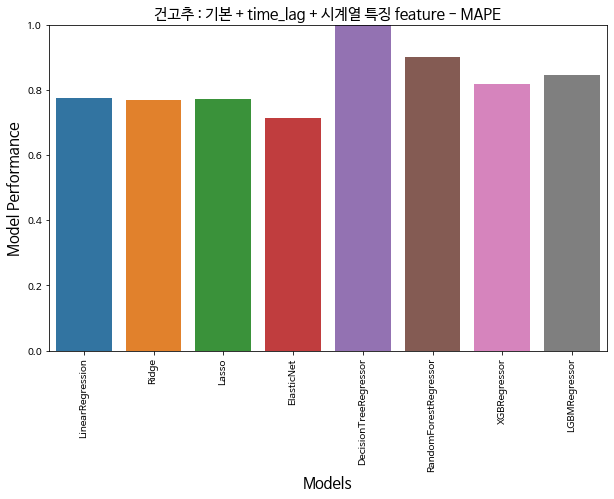

(1142, 34) (1142,) (309, 34) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 135.96it/s]

1 FOLDS: LinearRegression MAPE: 0.3920
2 FOLDS: LinearRegression MAPE: 0.3959
3 FOLDS: LinearRegression MAPE: 2.5084
4 FOLDS: LinearRegression MAPE: 0.3792
5 FOLDS: LinearRegression MAPE: 0.2986

LinearRegression mean MAPE: 0.7948


(1142, 34) (1142,) (309, 34) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 179.48it/s]

1 FOLDS: Ridge MAPE: 0.2848
2 FOLDS: Ridge MAPE: 0.3419
3 FOLDS: Ridge MAPE: 2.3233
4 FOLDS: Ridge MAPE: 0.3754
5 FOLDS: Ridge MAPE: 0.3026

Ridge mean MAPE: 0.7256


(1142, 34) (1142,) (309, 34) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 53.96it/s]

1 FOLDS: Lasso MAPE: 0.3344
2 FOLDS: Lasso MAPE: 0.3841
3 FOLDS: Lasso MAPE: 2.3931
4 FOLDS: Lasso MAPE: 0.3819
5 FOLDS: Lasso MAPE: 0.3006

Lasso mean MAPE: 0.7588


(1142, 34) (1142,) (309, 34) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 140.31it/s]

1 FOLDS: ElasticNet MAPE: 0.1718
2 FOLDS: ElasticNet MAPE: 0.2919
3 FOLDS: ElasticNet MAPE: 2.4678
4 FOLDS: ElasticNet MAPE: 0.3280
5 FOLDS: ElasticNet MAPE: 0.2825

ElasticNet mean MAPE: 0.7084


(1142, 34) (1142,) (309, 34) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 73.70it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2555
2 FOLDS: DecisionTreeRegressor MAPE: 1.5242
3 FOLDS: DecisionTreeRegressor MAPE: 4.0533
4 FOLDS: DecisionTreeRegressor MAPE: 3.3960
5 FOLDS: DecisionTreeRegressor MAPE: 0.4388

DecisionTreeRegressor mean MAPE: 1.9335


(1142, 34) (1142,) (309, 34) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.63it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1820
2 FOLDS: RandomForestRegressor MAPE: 1.0546
3 FOLDS: RandomForestRegressor MAPE: 3.0200
4 FOLDS: RandomForestRegressor MAPE: 0.9421
5 FOLDS: RandomForestRegressor MAPE: 0.3299

RandomForestRegressor mean MAPE: 1.1057
(1142, 34) (1142,) (309, 34) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.79it/s]

[09:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.53it/s]

[09:40:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.63it/s]


1 FOLDS: XGBRegressor MAPE: 0.1910
2 FOLDS: XGBRegressor MAPE: 1.8354
3 FOLDS: XGBRegressor MAPE: 2.7945
4 FOLDS: XGBRegressor MAPE: 1.1126
5 FOLDS: XGBRegressor MAPE: 0.3191

XGBRegressor mean MAPE: 1.2505
(1142, 34) (1142,) (309, 34) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.44it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1966
2 FOLDS: LGBMRegressor MAPE: 0.3450
3 FOLDS: LGBMRegressor MAPE: 1.9218
4 FOLDS: LGBMRegressor MAPE: 0.4097
5 FOLDS: LGBMRegressor MAPE: 0.3900

LGBMRegressor mean MAPE: 0.6526


,Model,Score
0,LinearRegression,0.79
1,Ridge,0.73
2,Lasso,0.76
3,ElasticNet,0.71
4,DecisionTreeRegressor,1.93
5,RandomForestRegressor,1.11
6,XGBRegressor,1.25
7,LGBMRegressor,0.65


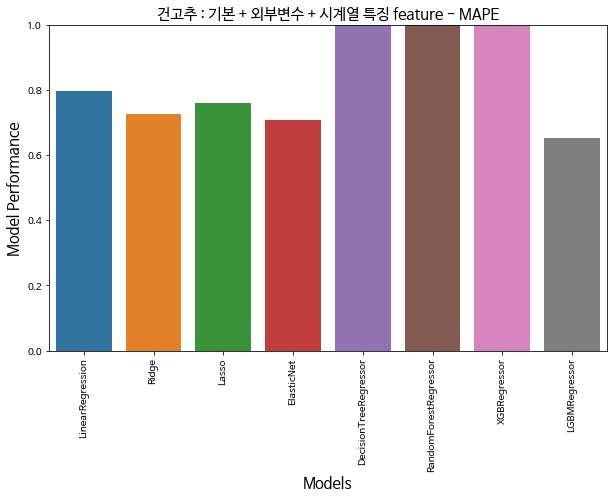

(1142, 33) (1142,) (309, 33) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 158.20it/s]

1 FOLDS: LinearRegression MAPE: 0.4223
2 FOLDS: LinearRegression MAPE: 0.4933
3 FOLDS: LinearRegression MAPE: 2.5392
4 FOLDS: LinearRegression MAPE: 0.4181
5 FOLDS: LinearRegression MAPE: 0.3107

LinearRegression mean MAPE: 0.8367


(1142, 33) (1142,) (309, 33) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 157.16it/s]

1 FOLDS: Ridge MAPE: 0.2831
2 FOLDS: Ridge MAPE: 0.4281
3 FOLDS: Ridge MAPE: 2.3597
4 FOLDS: Ridge MAPE: 0.4121
5 FOLDS: Ridge MAPE: 0.3143

Ridge mean MAPE: 0.7594


(1142, 33) (1142,) (309, 33) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 54.09it/s]

1 FOLDS: Lasso MAPE: 0.3486
2 FOLDS: Lasso MAPE: 0.4746
3 FOLDS: Lasso MAPE: 2.3258
4 FOLDS: Lasso MAPE: 0.4241
5 FOLDS: Lasso MAPE: 0.3127

Lasso mean MAPE: 0.7772


(1142, 33) (1142,) (309, 33) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 153.62it/s]

1 FOLDS: ElasticNet MAPE: 0.1699
2 FOLDS: ElasticNet MAPE: 0.3077
3 FOLDS: ElasticNet MAPE: 2.4402
4 FOLDS: ElasticNet MAPE: 0.3308
5 FOLDS: ElasticNet MAPE: 0.2956

ElasticNet mean MAPE: 0.7089


(1142, 33) (1142,) (309, 33) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 60.65it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2270
2 FOLDS: DecisionTreeRegressor MAPE: 0.4994
3 FOLDS: DecisionTreeRegressor MAPE: 2.8976
4 FOLDS: DecisionTreeRegressor MAPE: 0.4064
5 FOLDS: DecisionTreeRegressor MAPE: 0.4214

DecisionTreeRegressor mean MAPE: 0.8904


(1142, 33) (1142,) (309, 33) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.27it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1777
2 FOLDS: RandomForestRegressor MAPE: 0.2974
3 FOLDS: RandomForestRegressor MAPE: 3.1372
4 FOLDS: RandomForestRegressor MAPE: 0.3527
5 FOLDS: RandomForestRegressor MAPE: 0.3172

RandomForestRegressor mean MAPE: 0.8564
(1142, 33) (1142,) (309, 33) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.47it/s]

[09:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.26it/s]

[09:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 10.07it/s]


1 FOLDS: XGBRegressor MAPE: 0.1783
2 FOLDS: XGBRegressor MAPE: 0.2786
3 FOLDS: XGBRegressor MAPE: 2.5869
4 FOLDS: XGBRegressor MAPE: 0.3621
5 FOLDS: XGBRegressor MAPE: 0.3265

XGBRegressor mean MAPE: 0.7465
(1142, 33) (1142,) (309, 33) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.59it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1823
2 FOLDS: LGBMRegressor MAPE: 0.3004
3 FOLDS: LGBMRegressor MAPE: 2.8753
4 FOLDS: LGBMRegressor MAPE: 0.4096
5 FOLDS: LGBMRegressor MAPE: 0.3414

LGBMRegressor mean MAPE: 0.8218


,Model,Score
0,LinearRegression,0.84
1,Ridge,0.76
2,Lasso,0.78
3,ElasticNet,0.71
4,DecisionTreeRegressor,0.89
5,RandomForestRegressor,0.86
6,XGBRegressor,0.75
7,LGBMRegressor,0.82


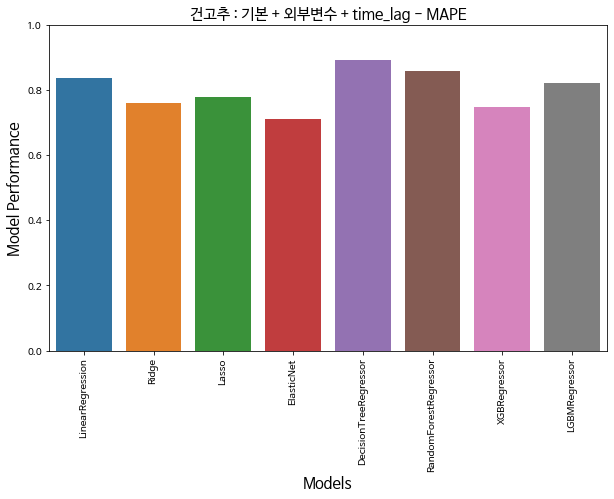

(1142, 43) (1142,) (309, 43) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 139.21it/s]

1 FOLDS: LinearRegression MAPE: 0.4665
2 FOLDS: LinearRegression MAPE: 0.3153
3 FOLDS: LinearRegression MAPE: 2.5008
4 FOLDS: LinearRegression MAPE: 0.3614
5 FOLDS: LinearRegression MAPE: 0.3160

LinearRegression mean MAPE: 0.7920


(1142, 43) (1142,) (309, 43) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 165.85it/s]

1 FOLDS: Ridge MAPE: 0.3076
2 FOLDS: Ridge MAPE: 0.2856
3 FOLDS: Ridge MAPE: 2.3211
4 FOLDS: Ridge MAPE: 0.3592
5 FOLDS: Ridge MAPE: 0.3170

Ridge mean MAPE: 0.7181


(1142, 43) (1142,) (309, 43) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 40.62it/s]

1 FOLDS: Lasso MAPE: 0.3857
2 FOLDS: Lasso MAPE: 0.3060
3 FOLDS: Lasso MAPE: 2.3807
4 FOLDS: Lasso MAPE: 0.3619
5 FOLDS: Lasso MAPE: 0.3184

Lasso mean MAPE: 0.7505


(1142, 43) (1142,) (309, 43) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 134.88it/s]

1 FOLDS: ElasticNet MAPE: 0.1738
2 FOLDS: ElasticNet MAPE: 0.2943
3 FOLDS: ElasticNet MAPE: 2.4534
4 FOLDS: ElasticNet MAPE: 0.3272
5 FOLDS: ElasticNet MAPE: 0.2932

ElasticNet mean MAPE: 0.7084


(1142, 43) (1142,) (309, 43) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 56.90it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2813
2 FOLDS: DecisionTreeRegressor MAPE: 1.5190
3 FOLDS: DecisionTreeRegressor MAPE: 3.6420
4 FOLDS: DecisionTreeRegressor MAPE: 0.4819
5 FOLDS: DecisionTreeRegressor MAPE: 0.3962

DecisionTreeRegressor mean MAPE: 1.2641


(1142, 43) (1142,) (309, 43) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:04<00:04,  1.13it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1797
2 FOLDS: RandomForestRegressor MAPE: 0.4492
3 FOLDS: RandomForestRegressor MAPE: 3.1680
4 FOLDS: RandomForestRegressor MAPE: 0.3810
5 FOLDS: RandomForestRegressor MAPE: 0.3271

RandomForestRegressor mean MAPE: 0.9010
(1142, 43) (1142,) (309, 43) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.19it/s]

[09:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.18it/s]

[09:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.58it/s]


1 FOLDS: XGBRegressor MAPE: 0.1856
2 FOLDS: XGBRegressor MAPE: 1.7043
3 FOLDS: XGBRegressor MAPE: 3.2372
4 FOLDS: XGBRegressor MAPE: 0.4122
5 FOLDS: XGBRegressor MAPE: 0.3553

XGBRegressor mean MAPE: 1.1789
(1142, 43) (1142,) (309, 43) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.74it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1880
2 FOLDS: LGBMRegressor MAPE: 0.2850
3 FOLDS: LGBMRegressor MAPE: 2.7909
4 FOLDS: LGBMRegressor MAPE: 0.3652
5 FOLDS: LGBMRegressor MAPE: 0.3920

LGBMRegressor mean MAPE: 0.8042


,Model,Score
0,LinearRegression,0.79
1,Ridge,0.72
2,Lasso,0.75
3,ElasticNet,0.71
4,DecisionTreeRegressor,1.26
5,RandomForestRegressor,0.90
6,XGBRegressor,1.18
7,LGBMRegressor,0.80


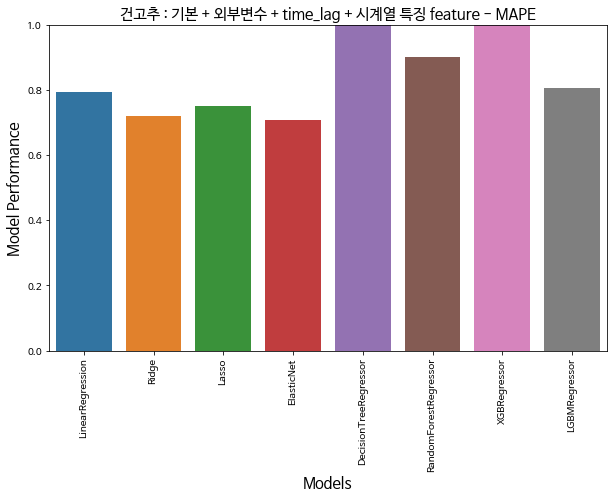

In [ ]:
modeling1('건고추')
modeling2('건고추')
modeling3('건고추')
modeling4('건고추')
modeling5('건고추')
modeling6('건고추')
modeling7('건고추')
modeling8('건고추')

### 이상치 처리

모든 모델링 경우의 수에서 3 FOLDS에서 값이 다른 folds 값보다 큼 -> 이상치 확인

3FOLDS면 대략.. 1folds가 9개월 ( 45 / 5 = 9 )

확실치 않음.., 우선 전구간에 대해 이상치 제거 후 다시 모델링 진행

In [ ]:
go = df[df.PUM_NM == '건고추']
go

In [ ]:
go2 = go[go.SALEDATE.between('2017-06-01', '2018-05-31')] # 기간 넉넉히 잡음
go['mean_price'] = go['TOT_AMT'] / go['TOT_QTY']
go2.head()

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
5363243,2017-06-01,건고추,건고추,전북 순창,77000.00,6.00,2017,6,1,3,...,0.00,25.69,45.30,1.95,58.04,4.50,0.00,8.30,0.35,12833.33
5363244,2017-06-01,건고추,건고추,전북 순창,300000.00,24.00,2017,6,1,3,...,0.00,25.69,45.30,1.95,58.04,4.50,0.00,8.30,0.35,12500.00
5363267,2017-06-01,건고추,건고추,전북 순창,300000.00,24.00,2017,6,1,3,...,0.00,25.69,45.30,1.95,58.04,4.50,0.00,8.30,0.35,12500.00
5364730,2017-06-01,건고추,건고추(일반),수입산,200000.00,25.00,2017,6,1,3,...,0.00,25.69,45.30,1.95,58.04,4.50,0.00,8.30,0.35,8000.00
5364731,2017-06-01,건고추,건고추(일반),수입산,170000.00,20.00,2017,6,1,3,...,0.00,25.69,45.30,1.95,58.04,4.50,0.00,8.30,0.35,8500.00


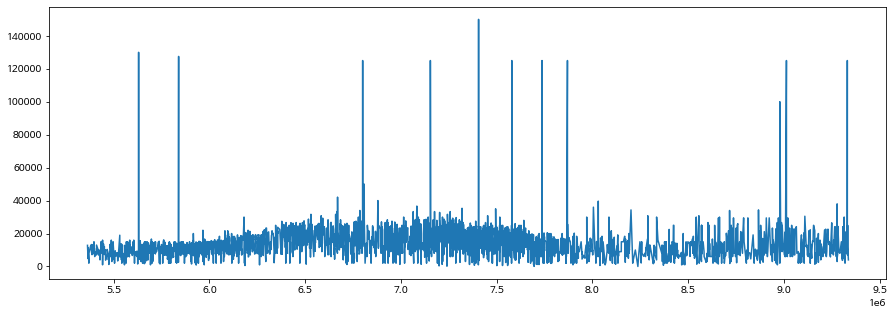

In [ ]:
go2.mean_price.plot(figsize = (15,5))

In [ ]:
go2[go2.mean_price > 50000] # 11개
# 산지는 대부분 부산광역시, 거래날짜는 골고루 되어있음

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
5630183,2017-06-30,건고추,건고추(일반),부산광역시,26000.00,0.20,2017,6,30,4,...,21.70,31.87,51.90,1.51,59.25,0.00,0.00,5.50,0.23,130000.00
5839081,2017-07-31,건고추,건고추(일반),부산광역시,51000.00,0.40,2017,7,31,0,...,24.00,25.54,29.40,1.13,88.38,11.50,0.00,0.00,0.00,127500.00
6800141,2017-09-30,건고추,건고추(일반),부산광역시,12500.00,0.10,2017,9,30,5,...,9.40,19.37,41.70,1.04,72.83,0.00,0.00,2.00,0.08,125000.00
7153731,2017-10-31,건고추,건고추(일반),부산광역시,25000.00,0.20,2017,10,31,1,...,0.20,7.98,17.50,1.06,62.83,0.00,0.00,10.00,0.42,125000.00
7405451,2017-11-17,건고추,기타건고추,전북 군산,150000.00,1.00,2017,11,17,4,...,-3.80,0.88,4.20,0.82,51.88,0.00,0.00,0.20,0.01,150000.00
7578997,2017-11-30,건고추,건고추(일반),부산광역시,25000.00,0.20,2017,11,30,3,...,-0.30,0.78,3.00,3.45,24.08,0.00,0.00,8.60,0.36,125000.00
7736846,2017-12-15,건고추,건고추(일반),부산광역시,12500.00,0.10,2017,12,15,4,...,-5.00,-2.60,-0.80,0.57,63.42,0.00,0.00,0.70,0.03,125000.00
7869539,2017-12-30,건고추,건고추(일반),부산광역시,12500.00,0.10,2017,12,30,5,...,-1.90,-0.73,0.10,0.67,82.71,0.40,0.00,0.20,0.01,125000.00
8978555,2018-04-26,건고추,기타건고추,인천,50000.00,0.50,2018,4,26,3,...,6.00,16.29,31.30,1.57,54.42,0.00,0.00,10.60,0.44,100000.00
9013098,2018-04-30,건고추,건고추(일반),부산광역시,12500.00,0.10,2018,4,30,0,...,10.70,20.81,38.00,1.43,57.83,0.00,0.00,8.30,0.35,125000.00


In [ ]:
go3 = go2.drop(go2[go2.mean_price > 50000].index)
go3

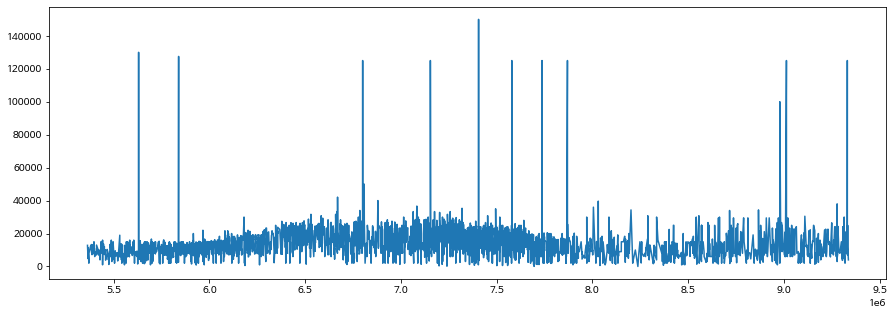

In [ ]:
# 이상치 제거 전
go2.mean_price.plot(figsize = (15,5))

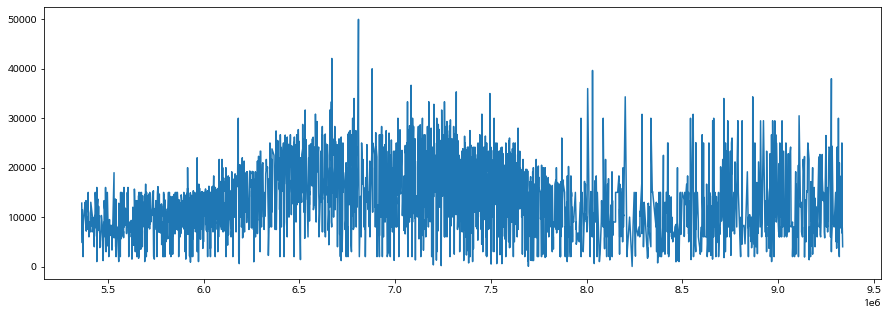

In [ ]:
# 이상치 제거 후
go3.mean_price.plot(figsize = (15,5))

In [ ]:
go[go.mean_price > 50000]

,SALEDATE,PUM_NM,KIND_NM,SAN_NM,TOT_AMT,TOT_QTY,year,month,day,weekday,...,지면온도(최저),지면온도(평균),지면온도(최고),풍속(m/s)(평균),습도(%)(평균),강수량(mm)(합계),적설량(cm)(합계),일조량(합계),일조량(평균),mean_price
573217,2016-02-29,건고추,건고추(일반),부산광역시,39000.00,0.30,2016,2,29,0,...,-3.10,-0.64,3.50,2.99,53.54,0.00,0.00,4.50,0.19,130000.00
577489,2016-02-29,건고추,건고추(일반),충북 제천,5999500.00,42.60,2016,2,29,0,...,-3.10,-0.64,3.50,2.99,53.54,0.00,0.00,4.50,0.19,140833.33
577509,2016-02-29,건고추,건고추(일반),충북 제천,10393500.00,73.80,2016,2,29,0,...,-3.10,-0.64,3.50,2.99,53.54,0.00,0.00,4.50,0.19,140833.33
1182237,2016-04-30,건고추,건고추(일반),부산광역시,117000.00,0.90,2016,4,30,5,...,8.90,18.13,31.80,1.95,57.67,0.00,0.00,1.70,0.07,130000.00
1489436,2016-06-01,건고추,건고추(일반),서울,56000.00,1.00,2016,6,1,2,...,16.70,29.69,51.00,1.67,49.96,0.00,0.00,11.30,0.47,56000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17678894,2020-08-19,건고추,건고추(일반),전북 순창,330000.00,6.00,2020,8,19,2,...,23.40,29.14,39.20,1.14,83.67,0.00,0.00,7.60,0.32,55000.00
17850766,2020-08-31,건고추,기타건고추,전북 군산,85800.00,1.00,2020,8,31,0,...,24.20,27.89,34.10,1.48,82.62,0.50,0.00,1.20,0.05,85800.00
17921967,2020-09-03,건고추,양건,전남 무안,996000.00,18.00,2020,9,3,3,...,21.20,24.14,29.10,4.15,77.96,37.40,0.00,3.30,0.14,55333.33
17997007,2020-09-09,건고추,기타건고추,전북 군산,597600.00,10.00,2020,9,9,2,...,20.00,22.70,30.70,1.01,91.58,14.60,0.00,1.00,0.04,59760.00


In [ ]:
go10 = go.drop(go[go.mean_price > 50000].index)

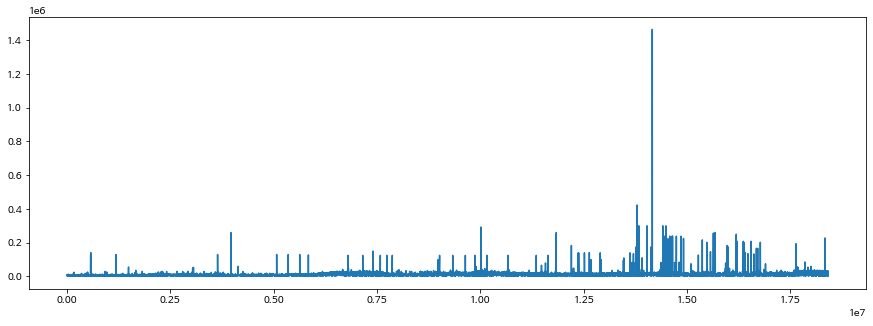

In [ ]:
# 거래건수 별 이상치 제거 전
go.mean_price.plot(figsize = (15,5))

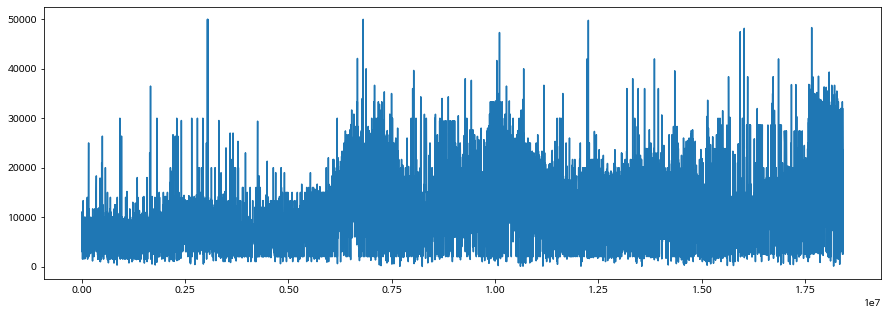

In [ ]:
# 거래건수 별 이상치 제거 후

go10.mean_price.plot(figsize = (15,5))

In [ ]:
go9 = mean_price(go)
go11 = mean_price(go10)

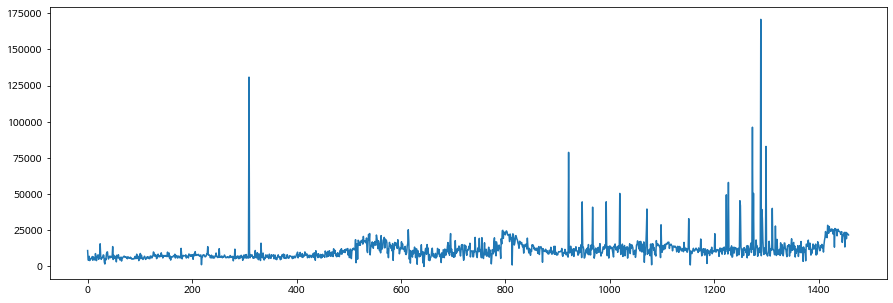

In [ ]:
go9.mean_price.plot(figsize = (15,5))

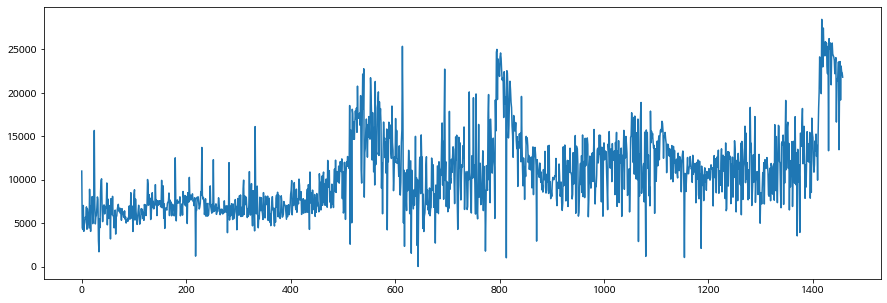

In [ ]:
go11.mean_price.plot(figsize = (15,5))

### 다시 모델링

(1142, 7) (1142,) (309, 7) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 232.94it/s]

1 FOLDS: LinearRegression MAPE: 0.1985
2 FOLDS: LinearRegression MAPE: 0.2918
3 FOLDS: LinearRegression MAPE: 2.8656
4 FOLDS: LinearRegression MAPE: 0.3905
5 FOLDS: LinearRegression MAPE: 0.3051

LinearRegression mean MAPE: 0.8103


(1142, 7) (1142,) (309, 7) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 243.12it/s]

1 FOLDS: Ridge MAPE: 0.1956
2 FOLDS: Ridge MAPE: 0.2931
3 FOLDS: Ridge MAPE: 2.8414
4 FOLDS: Ridge MAPE: 0.3888
5 FOLDS: Ridge MAPE: 0.3047

Ridge mean MAPE: 0.8047


(1142, 7) (1142,) (309, 7) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 255.34it/s]

1 FOLDS: Lasso MAPE: 0.1972
2 FOLDS: Lasso MAPE: 0.2929
3 FOLDS: Lasso MAPE: 2.8606
4 FOLDS: Lasso MAPE: 0.3900
5 FOLDS: Lasso MAPE: 0.3049

Lasso mean MAPE: 0.8091


(1142, 7) (1142,) (309, 7) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 250.59it/s]

1 FOLDS: ElasticNet MAPE: 0.1669
2 FOLDS: ElasticNet MAPE: 0.3186
3 FOLDS: ElasticNet MAPE: 2.3504
4 FOLDS: ElasticNet MAPE: 0.3351
5 FOLDS: ElasticNet MAPE: 0.2805

ElasticNet mean MAPE: 0.6903


(1142, 7) (1142,) (309, 7) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 160.98it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2184
2 FOLDS: DecisionTreeRegressor MAPE: 0.3570
3 FOLDS: DecisionTreeRegressor MAPE: 1.7707
4 FOLDS: DecisionTreeRegressor MAPE: 0.4908
5 FOLDS: DecisionTreeRegressor MAPE: 0.5759

DecisionTreeRegressor mean MAPE: 0.6826


(1142, 7) (1142,) (309, 7) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  3.72it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1869
2 FOLDS: RandomForestRegressor MAPE: 0.3053
3 FOLDS: RandomForestRegressor MAPE: 2.0887
4 FOLDS: RandomForestRegressor MAPE: 0.4252
5 FOLDS: RandomForestRegressor MAPE: 0.3039

RandomForestRegressor mean MAPE: 0.6620
(1142, 7) (1142,) (309, 7) (309,)


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 26.97it/s]

[10:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:07:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1835
2 FOLDS: XGBRegressor MAPE: 0.2986
3 FOLDS: XGBRegressor MAPE: 2.1784
4 FOLDS: XGBRegressor MAPE: 0.4246
5 FOLDS: XGBRegressor MAPE: 0.2873

XGBRegressor mean MAPE: 0.6745


(1142, 7) (1142,) (309, 7) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 20.57it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1840
2 FOLDS: LGBMRegressor MAPE: 0.3081
3 FOLDS: LGBMRegressor MAPE: 2.2076
4 FOLDS: LGBMRegressor MAPE: 0.4427
5 FOLDS: LGBMRegressor MAPE: 0.3230

LGBMRegressor mean MAPE: 0.6931


,Model,Score
0,LinearRegression,0.81
1,Ridge,0.80
2,Lasso,0.81
3,ElasticNet,0.69
4,DecisionTreeRegressor,0.68
5,RandomForestRegressor,0.66
6,XGBRegressor,0.67
7,LGBMRegressor,0.69


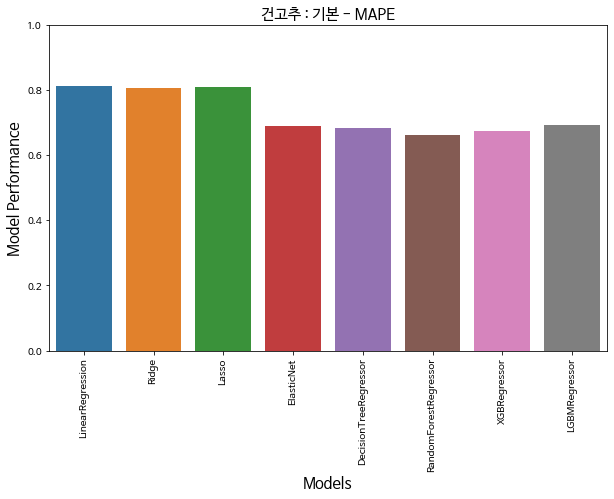

(1142, 16) (1142,) (309, 16) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 196.79it/s]

1 FOLDS: LinearRegression MAPE: 0.1986
2 FOLDS: LinearRegression MAPE: 0.2652
3 FOLDS: LinearRegression MAPE: 2.8157
4 FOLDS: LinearRegression MAPE: 0.3463
5 FOLDS: LinearRegression MAPE: 0.2790

LinearRegression mean MAPE: 0.7810


(1142, 16) (1142,) (309, 16) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.75it/s]

1 FOLDS: Ridge MAPE: 0.1953
2 FOLDS: Ridge MAPE: 0.2658
3 FOLDS: Ridge MAPE: 2.8060
4 FOLDS: Ridge MAPE: 0.3459
5 FOLDS: Ridge MAPE: 0.2789

Ridge mean MAPE: 0.7784


(1142, 16) (1142,) (309, 16) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 148.78it/s]

1 FOLDS: Lasso MAPE: 0.1975
2 FOLDS: Lasso MAPE: 0.2664
3 FOLDS: Lasso MAPE: 2.8108
4 FOLDS: Lasso MAPE: 0.3459
5 FOLDS: Lasso MAPE: 0.2789

Lasso mean MAPE: 0.7799


(1142, 16) (1142,) (309, 16) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 106.99it/s]

1 FOLDS: ElasticNet MAPE: 0.1676
2 FOLDS: ElasticNet MAPE: 0.3040
3 FOLDS: ElasticNet MAPE: 2.4980
4 FOLDS: ElasticNet MAPE: 0.3188
5 FOLDS: ElasticNet MAPE: 0.2673

ElasticNet mean MAPE: 0.7111


(1142, 16) (1142,) (309, 16) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 101.70it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2546
2 FOLDS: DecisionTreeRegressor MAPE: 0.3187
3 FOLDS: DecisionTreeRegressor MAPE: 3.6188
4 FOLDS: DecisionTreeRegressor MAPE: 0.3945
5 FOLDS: DecisionTreeRegressor MAPE: 0.3673

DecisionTreeRegressor mean MAPE: 0.9908


(1142, 16) (1142,) (309, 16) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  1.98it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1850
2 FOLDS: RandomForestRegressor MAPE: 0.2906
3 FOLDS: RandomForestRegressor MAPE: 3.1958
4 FOLDS: RandomForestRegressor MAPE: 0.3340
5 FOLDS: RandomForestRegressor MAPE: 0.2929

RandomForestRegressor mean MAPE: 0.8596
(1142, 16) (1142,) (309, 16) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.52it/s]

[10:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.77it/s]


[10:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1813
2 FOLDS: XGBRegressor MAPE: 0.2906
3 FOLDS: XGBRegressor MAPE: 3.1796
4 FOLDS: XGBRegressor MAPE: 0.3465
5 FOLDS: XGBRegressor MAPE: 0.2976

XGBRegressor mean MAPE: 0.8591
(1142, 16) (1142,) (309, 16) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.88it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1795
2 FOLDS: LGBMRegressor MAPE: 0.2997
3 FOLDS: LGBMRegressor MAPE: 3.0060
4 FOLDS: LGBMRegressor MAPE: 0.3539
5 FOLDS: LGBMRegressor MAPE: 0.3468

LGBMRegressor mean MAPE: 0.8372


,Model,Score
0,LinearRegression,0.78
1,Ridge,0.78
2,Lasso,0.78
3,ElasticNet,0.71
4,DecisionTreeRegressor,0.99
5,RandomForestRegressor,0.86
6,XGBRegressor,0.86
7,LGBMRegressor,0.84


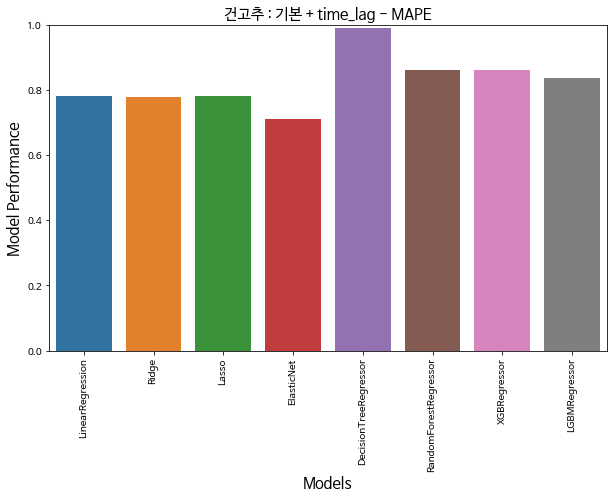

(1142, 17) (1142,) (309, 17) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 187.65it/s]

1 FOLDS: LinearRegression MAPE: 0.1771
2 FOLDS: LinearRegression MAPE: 0.2197
3 FOLDS: LinearRegression MAPE: 2.7770
4 FOLDS: LinearRegression MAPE: 0.3153
5 FOLDS: LinearRegression MAPE: 0.2596

LinearRegression mean MAPE: 0.7497


(1142, 17) (1142,) (309, 17) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 202.09it/s]

1 FOLDS: Ridge MAPE: 0.1795
2 FOLDS: Ridge MAPE: 0.2284
3 FOLDS: Ridge MAPE: 2.7752
4 FOLDS: Ridge MAPE: 0.3153
5 FOLDS: Ridge MAPE: 0.2596

Ridge mean MAPE: 0.7516


(1142, 17) (1142,) (309, 17) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 98.74it/s]

1 FOLDS: Lasso MAPE: 0.1766
2 FOLDS: Lasso MAPE: 0.2216
3 FOLDS: Lasso MAPE: 2.7710
4 FOLDS: Lasso MAPE: 0.3151
5 FOLDS: Lasso MAPE: 0.2594

Lasso mean MAPE: 0.7487


(1142, 17) (1142,) (309, 17) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 184.45it/s]

1 FOLDS: ElasticNet MAPE: 0.1661
2 FOLDS: ElasticNet MAPE: 0.3148
3 FOLDS: ElasticNet MAPE: 2.4614
4 FOLDS: ElasticNet MAPE: 0.3098
5 FOLDS: ElasticNet MAPE: 0.2601

ElasticNet mean MAPE: 0.7024


(1142, 17) (1142,) (309, 17) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 120.93it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2607
2 FOLDS: DecisionTreeRegressor MAPE: 0.3835
3 FOLDS: DecisionTreeRegressor MAPE: 2.9414
4 FOLDS: DecisionTreeRegressor MAPE: 0.4259
5 FOLDS: DecisionTreeRegressor MAPE: 0.2996

DecisionTreeRegressor mean MAPE: 0.8622


(1142, 17) (1142,) (309, 17) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:01<00:01,  2.67it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1857
2 FOLDS: RandomForestRegressor MAPE: 0.3044
3 FOLDS: RandomForestRegressor MAPE: 2.7569
4 FOLDS: RandomForestRegressor MAPE: 0.3326
5 FOLDS: RandomForestRegressor MAPE: 0.2935

RandomForestRegressor mean MAPE: 0.7746
(1142, 17) (1142,) (309, 17) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 24.54it/s]

[10:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 18.28it/s]


1 FOLDS: XGBRegressor MAPE: 0.1908
2 FOLDS: XGBRegressor MAPE: 0.3150
3 FOLDS: XGBRegressor MAPE: 2.6951
4 FOLDS: XGBRegressor MAPE: 0.3265
5 FOLDS: XGBRegressor MAPE: 0.2992

XGBRegressor mean MAPE: 0.7653
(1142, 17) (1142,) (309, 17) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 13.10it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1978
2 FOLDS: LGBMRegressor MAPE: 0.3163
3 FOLDS: LGBMRegressor MAPE: 2.6153
4 FOLDS: LGBMRegressor MAPE: 0.3501
5 FOLDS: LGBMRegressor MAPE: 0.3245

LGBMRegressor mean MAPE: 0.7608


,Model,Score
0,LinearRegression,0.75
1,Ridge,0.75
2,Lasso,0.75
3,ElasticNet,0.70
4,DecisionTreeRegressor,0.86
5,RandomForestRegressor,0.77
6,XGBRegressor,0.77
7,LGBMRegressor,0.76


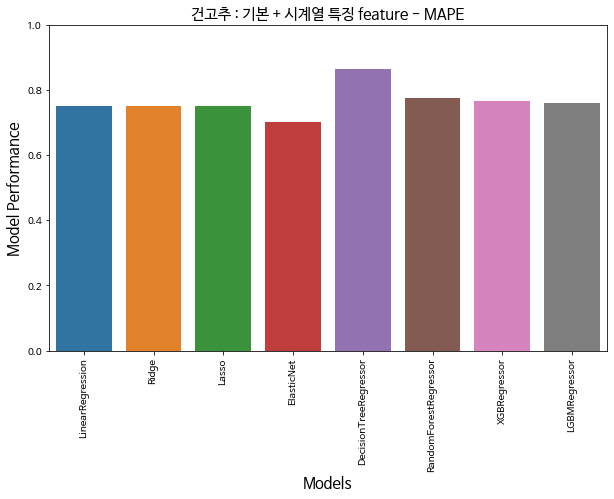

(1142, 24) (1142,) (309, 24) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 55.41it/s]

1 FOLDS: LinearRegression MAPE: 0.3461
2 FOLDS: LinearRegression MAPE: 0.3161
3 FOLDS: LinearRegression MAPE: 2.0972
4 FOLDS: LinearRegression MAPE: 0.3879
5 FOLDS: LinearRegression MAPE: 0.2853

LinearRegression mean MAPE: 0.6865


(1142, 24) (1142,) (309, 24) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 212.85it/s]

1 FOLDS: Ridge MAPE: 0.2364
2 FOLDS: Ridge MAPE: 0.3056
3 FOLDS: Ridge MAPE: 2.1147
4 FOLDS: Ridge MAPE: 0.3806
5 FOLDS: Ridge MAPE: 0.2877

Ridge mean MAPE: 0.6650


(1142, 24) (1142,) (309, 24) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 68.19it/s]

1 FOLDS: Lasso MAPE: 0.2904
2 FOLDS: Lasso MAPE: 0.3058
3 FOLDS: Lasso MAPE: 1.9078
4 FOLDS: Lasso MAPE: 0.3880
5 FOLDS: Lasso MAPE: 0.2875

Lasso mean MAPE: 0.6359


(1142, 24) (1142,) (309, 24) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 86.38it/s]

1 FOLDS: ElasticNet MAPE: 0.1640
2 FOLDS: ElasticNet MAPE: 0.3065
3 FOLDS: ElasticNet MAPE: 2.3392
4 FOLDS: ElasticNet MAPE: 0.3347
5 FOLDS: ElasticNet MAPE: 0.2764

ElasticNet mean MAPE: 0.6842


(1142, 24) (1142,) (309, 24) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 94.95it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2343
2 FOLDS: DecisionTreeRegressor MAPE: 0.3692
3 FOLDS: DecisionTreeRegressor MAPE: 1.9844
4 FOLDS: DecisionTreeRegressor MAPE: 0.5350
5 FOLDS: DecisionTreeRegressor MAPE: 0.3492

DecisionTreeRegressor mean MAPE: 0.6944


(1142, 24) (1142,) (309, 24) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:02<00:02,  2.02it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1659
2 FOLDS: RandomForestRegressor MAPE: 0.3089
3 FOLDS: RandomForestRegressor MAPE: 3.8682
4 FOLDS: RandomForestRegressor MAPE: 0.3852
5 FOLDS: RandomForestRegressor MAPE: 0.2663

RandomForestRegressor mean MAPE: 0.9989
(1142, 24) (1142,) (309, 24) (309,)


XGBRegressor Cross Validations...:  30%|███       | 3/10 [00:00<00:00, 20.79it/s]

[10:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 15.56it/s]


[10:08:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
1 FOLDS: XGBRegressor MAPE: 0.1777
2 FOLDS: XGBRegressor MAPE: 0.3077
3 FOLDS: XGBRegressor MAPE: 2.8354
4 FOLDS: XGBRegressor MAPE: 0.3826
5 FOLDS: XGBRegressor MAPE: 0.2860

XGBRegressor mean MAPE: 0.7979
(1142, 24) (1142,) (309, 24) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 12.25it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1855
2 FOLDS: LGBMRegressor MAPE: 0.3135
3 FOLDS: LGBMRegressor MAPE: 2.2490
4 FOLDS: LGBMRegressor MAPE: 0.4142
5 FOLDS: LGBMRegressor MAPE: 0.3023

LGBMRegressor mean MAPE: 0.6929


,Model,Score
0,LinearRegression,0.69
1,Ridge,0.66
2,Lasso,0.64
3,ElasticNet,0.68
4,DecisionTreeRegressor,0.69
5,RandomForestRegressor,1.00
6,XGBRegressor,0.80
7,LGBMRegressor,0.69


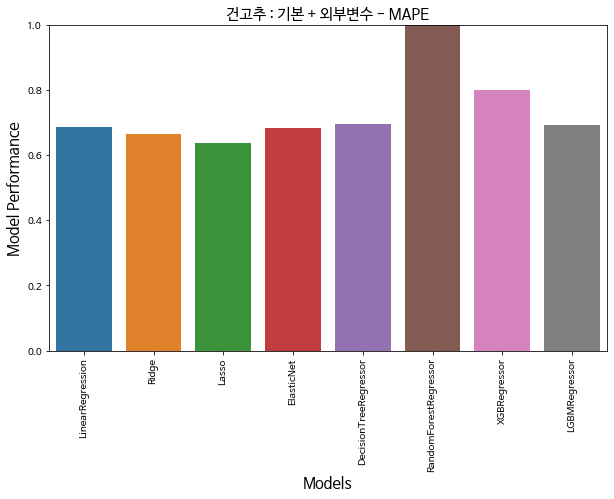

(1142, 26) (1142,) (309, 26) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 170.69it/s]

1 FOLDS: LinearRegression MAPE: 0.1811
2 FOLDS: LinearRegression MAPE: 0.2086
3 FOLDS: LinearRegression MAPE: 2.7589
4 FOLDS: LinearRegression MAPE: 0.3093
5 FOLDS: LinearRegression MAPE: 0.2616

LinearRegression mean MAPE: 0.7439


(1142, 26) (1142,) (309, 26) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 178.80it/s]

1 FOLDS: Ridge MAPE: 0.1832
2 FOLDS: Ridge MAPE: 0.2213
3 FOLDS: Ridge MAPE: 2.7577
4 FOLDS: Ridge MAPE: 0.3098
5 FOLDS: Ridge MAPE: 0.2615

Ridge mean MAPE: 0.7467


(1142, 26) (1142,) (309, 26) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 66.66it/s]

1 FOLDS: Lasso MAPE: 0.1803
2 FOLDS: Lasso MAPE: 0.2112
3 FOLDS: Lasso MAPE: 2.7505
4 FOLDS: Lasso MAPE: 0.3093
5 FOLDS: Lasso MAPE: 0.2614

Lasso mean MAPE: 0.7425


(1142, 26) (1142,) (309, 26) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 167.64it/s]

1 FOLDS: ElasticNet MAPE: 0.1669
2 FOLDS: ElasticNet MAPE: 0.3015
3 FOLDS: ElasticNet MAPE: 2.5445
4 FOLDS: ElasticNet MAPE: 0.3152
5 FOLDS: ElasticNet MAPE: 0.2631

ElasticNet mean MAPE: 0.7182


(1142, 26) (1142,) (309, 26) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 81.91it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2900
2 FOLDS: DecisionTreeRegressor MAPE: 0.3539
3 FOLDS: DecisionTreeRegressor MAPE: 3.5876
4 FOLDS: DecisionTreeRegressor MAPE: 0.3827
5 FOLDS: DecisionTreeRegressor MAPE: 0.3377

DecisionTreeRegressor mean MAPE: 0.9904


(1142, 26) (1142,) (309, 26) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.60it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1871
2 FOLDS: RandomForestRegressor MAPE: 0.2992
3 FOLDS: RandomForestRegressor MAPE: 3.0624
4 FOLDS: RandomForestRegressor MAPE: 0.3192
5 FOLDS: RandomForestRegressor MAPE: 0.3075

RandomForestRegressor mean MAPE: 0.8351
(1142, 26) (1142,) (309, 26) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.48it/s]

[10:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.22it/s]

[10:09:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.38it/s]


1 FOLDS: XGBRegressor MAPE: 0.1832
2 FOLDS: XGBRegressor MAPE: 0.3139
3 FOLDS: XGBRegressor MAPE: 2.9109
4 FOLDS: XGBRegressor MAPE: 0.3334
5 FOLDS: XGBRegressor MAPE: 0.2989

XGBRegressor mean MAPE: 0.8081
(1142, 26) (1142,) (309, 26) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  7.55it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1829
2 FOLDS: LGBMRegressor MAPE: 0.3145
3 FOLDS: LGBMRegressor MAPE: 2.9072
4 FOLDS: LGBMRegressor MAPE: 0.3413
5 FOLDS: LGBMRegressor MAPE: 0.3220

LGBMRegressor mean MAPE: 0.8136


,Model,Score
0,LinearRegression,0.74
1,Ridge,0.75
2,Lasso,0.74
3,ElasticNet,0.72
4,DecisionTreeRegressor,0.99
5,RandomForestRegressor,0.84
6,XGBRegressor,0.81
7,LGBMRegressor,0.81


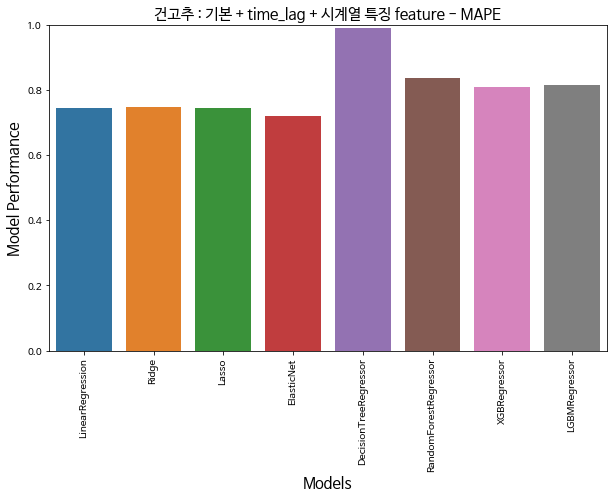

(1142, 34) (1142,) (309, 34) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 154.35it/s]

1 FOLDS: LinearRegression MAPE: 0.3197
2 FOLDS: LinearRegression MAPE: 0.2507
3 FOLDS: LinearRegression MAPE: 2.5819
4 FOLDS: LinearRegression MAPE: 0.3170
5 FOLDS: LinearRegression MAPE: 0.2574

LinearRegression mean MAPE: 0.7453


(1142, 34) (1142,) (309, 34) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 164.14it/s]

1 FOLDS: Ridge MAPE: 0.2287
2 FOLDS: Ridge MAPE: 0.2537
3 FOLDS: Ridge MAPE: 2.5818
4 FOLDS: Ridge MAPE: 0.3163
5 FOLDS: Ridge MAPE: 0.2594

Ridge mean MAPE: 0.7280


(1142, 34) (1142,) (309, 34) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 55.77it/s]

1 FOLDS: Lasso MAPE: 0.2630
2 FOLDS: Lasso MAPE: 0.2472
3 FOLDS: Lasso MAPE: 2.5252
4 FOLDS: Lasso MAPE: 0.3156
5 FOLDS: Lasso MAPE: 0.2592

Lasso mean MAPE: 0.7220


(1142, 34) (1142,) (309, 34) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 158.13it/s]

1 FOLDS: ElasticNet MAPE: 0.1640
2 FOLDS: ElasticNet MAPE: 0.3044
3 FOLDS: ElasticNet MAPE: 2.4351
4 FOLDS: ElasticNet MAPE: 0.3156
5 FOLDS: ElasticNet MAPE: 0.2618

ElasticNet mean MAPE: 0.6962


(1142, 34) (1142,) (309, 34) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 83.16it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2803
2 FOLDS: DecisionTreeRegressor MAPE: 0.3765
3 FOLDS: DecisionTreeRegressor MAPE: 3.6593
4 FOLDS: DecisionTreeRegressor MAPE: 0.4687
5 FOLDS: DecisionTreeRegressor MAPE: 0.3475

DecisionTreeRegressor mean MAPE: 1.0264


(1142, 34) (1142,) (309, 34) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.64it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1696
2 FOLDS: RandomForestRegressor MAPE: 0.3089
3 FOLDS: RandomForestRegressor MAPE: 3.0929
4 FOLDS: RandomForestRegressor MAPE: 0.3340
5 FOLDS: RandomForestRegressor MAPE: 0.2800

RandomForestRegressor mean MAPE: 0.8371
(1142, 34) (1142,) (309, 34) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 18.95it/s]

[10:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.42it/s]

[10:09:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 11.30it/s]


1 FOLDS: XGBRegressor MAPE: 0.1914
2 FOLDS: XGBRegressor MAPE: 0.3181
3 FOLDS: XGBRegressor MAPE: 2.4215
4 FOLDS: XGBRegressor MAPE: 0.3365
5 FOLDS: XGBRegressor MAPE: 0.2956

XGBRegressor mean MAPE: 0.7126
(1142, 34) (1142,) (309, 34) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.80it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1925
2 FOLDS: LGBMRegressor MAPE: 0.3189
3 FOLDS: LGBMRegressor MAPE: 2.8132
4 FOLDS: LGBMRegressor MAPE: 0.3605
5 FOLDS: LGBMRegressor MAPE: 0.3305

LGBMRegressor mean MAPE: 0.8031


,Model,Score
0,LinearRegression,0.75
1,Ridge,0.73
2,Lasso,0.72
3,ElasticNet,0.70
4,DecisionTreeRegressor,1.03
5,RandomForestRegressor,0.84
6,XGBRegressor,0.71
7,LGBMRegressor,0.80


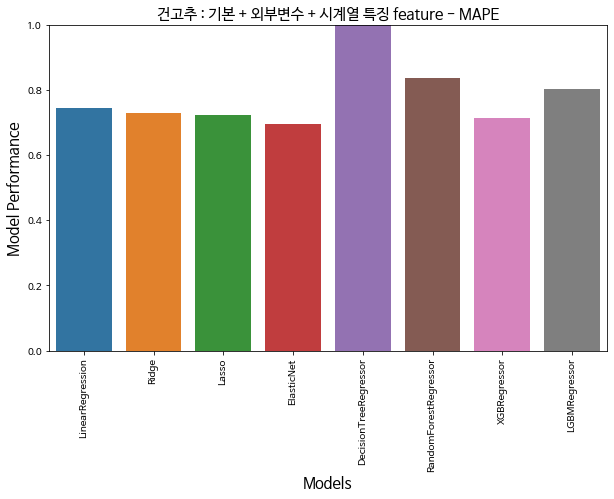

(1142, 33) (1142,) (309, 33) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 144.26it/s]

1 FOLDS: LinearRegression MAPE: 0.3639
2 FOLDS: LinearRegression MAPE: 0.3031
3 FOLDS: LinearRegression MAPE: 2.3732
4 FOLDS: LinearRegression MAPE: 0.3453
5 FOLDS: LinearRegression MAPE: 0.2746

LinearRegression mean MAPE: 0.7320


(1142, 33) (1142,) (309, 33) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 162.15it/s]

1 FOLDS: Ridge MAPE: 0.2414
2 FOLDS: Ridge MAPE: 0.2904
3 FOLDS: Ridge MAPE: 2.3817
4 FOLDS: Ridge MAPE: 0.3434
5 FOLDS: Ridge MAPE: 0.2771

Ridge mean MAPE: 0.7068


(1142, 33) (1142,) (309, 33) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 58.98it/s]

1 FOLDS: Lasso MAPE: 0.2910
2 FOLDS: Lasso MAPE: 0.2923
3 FOLDS: Lasso MAPE: 2.2666
4 FOLDS: Lasso MAPE: 0.3438
5 FOLDS: Lasso MAPE: 0.2768

Lasso mean MAPE: 0.6941


(1142, 33) (1142,) (309, 33) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 151.19it/s]

1 FOLDS: ElasticNet MAPE: 0.1656
2 FOLDS: ElasticNet MAPE: 0.2987
3 FOLDS: ElasticNet MAPE: 2.4512
4 FOLDS: ElasticNet MAPE: 0.3232
5 FOLDS: ElasticNet MAPE: 0.2692

ElasticNet mean MAPE: 0.7016


(1142, 33) (1142,) (309, 33) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 63.36it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2316
2 FOLDS: DecisionTreeRegressor MAPE: 0.3250
3 FOLDS: DecisionTreeRegressor MAPE: 4.8483
4 FOLDS: DecisionTreeRegressor MAPE: 0.4113
5 FOLDS: DecisionTreeRegressor MAPE: 0.3629

DecisionTreeRegressor mean MAPE: 1.2358


(1142, 33) (1142,) (309, 33) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1664
2 FOLDS: RandomForestRegressor MAPE: 0.2876
3 FOLDS: RandomForestRegressor MAPE: 3.3371
4 FOLDS: RandomForestRegressor MAPE: 0.3304
5 FOLDS: RandomForestRegressor MAPE: 0.2710

RandomForestRegressor mean MAPE: 0.8785
(1142, 33) (1142,) (309, 33) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 16.74it/s]

[10:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 11.15it/s]

[10:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:09:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  9.99it/s]


1 FOLDS: XGBRegressor MAPE: 0.1778
2 FOLDS: XGBRegressor MAPE: 0.2788
3 FOLDS: XGBRegressor MAPE: 3.2521
4 FOLDS: XGBRegressor MAPE: 0.3388
5 FOLDS: XGBRegressor MAPE: 0.2931

XGBRegressor mean MAPE: 0.8681
(1142, 33) (1142,) (309, 33) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  6.93it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1823
2 FOLDS: LGBMRegressor MAPE: 0.2945
3 FOLDS: LGBMRegressor MAPE: 3.2596
4 FOLDS: LGBMRegressor MAPE: 0.3386
5 FOLDS: LGBMRegressor MAPE: 0.2875

LGBMRegressor mean MAPE: 0.8725


,Model,Score
0,LinearRegression,0.73
1,Ridge,0.71
2,Lasso,0.69
3,ElasticNet,0.70
4,DecisionTreeRegressor,1.24
5,RandomForestRegressor,0.88
6,XGBRegressor,0.87
7,LGBMRegressor,0.87


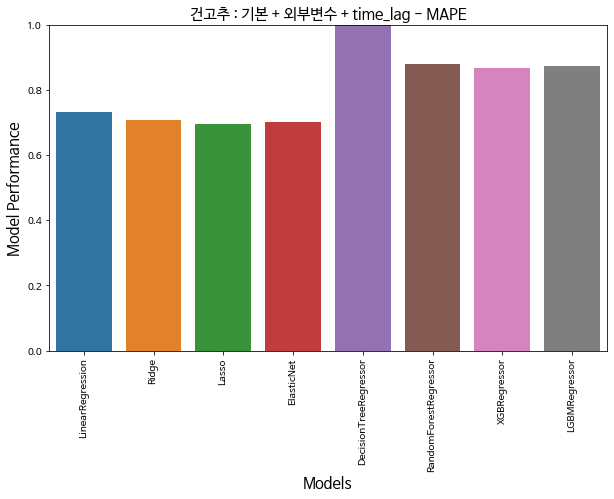

(1142, 43) (1142,) (309, 43) (309,)


LinearRegression Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 141.17it/s]

1 FOLDS: LinearRegression MAPE: 0.3622
2 FOLDS: LinearRegression MAPE: 0.2401
3 FOLDS: LinearRegression MAPE: 2.5975
4 FOLDS: LinearRegression MAPE: 0.3111
5 FOLDS: LinearRegression MAPE: 0.2583

LinearRegression mean MAPE: 0.7538


(1142, 43) (1142,) (309, 43) (309,)


Ridge Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 170.36it/s]

1 FOLDS: Ridge MAPE: 0.2426
2 FOLDS: Ridge MAPE: 0.2482
3 FOLDS: Ridge MAPE: 2.5849
4 FOLDS: Ridge MAPE: 0.3110
5 FOLDS: Ridge MAPE: 0.2594

Ridge mean MAPE: 0.7292


(1142, 43) (1142,) (309, 43) (309,)


Lasso Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 44.36it/s]

1 FOLDS: Lasso MAPE: 0.2871
2 FOLDS: Lasso MAPE: 0.2365
3 FOLDS: Lasso MAPE: 2.5486
4 FOLDS: Lasso MAPE: 0.3103
5 FOLDS: Lasso MAPE: 0.2594

Lasso mean MAPE: 0.7284


(1142, 43) (1142,) (309, 43) (309,)


ElasticNet Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 124.36it/s]

1 FOLDS: ElasticNet MAPE: 0.1656
2 FOLDS: ElasticNet MAPE: 0.2972
3 FOLDS: ElasticNet MAPE: 2.4990
4 FOLDS: ElasticNet MAPE: 0.3193
5 FOLDS: ElasticNet MAPE: 0.2649

ElasticNet mean MAPE: 0.7092


(1142, 43) (1142,) (309, 43) (309,)


DecisionTreeRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00, 56.74it/s]

1 FOLDS: DecisionTreeRegressor MAPE: 0.2218
2 FOLDS: DecisionTreeRegressor MAPE: 0.3261
3 FOLDS: DecisionTreeRegressor MAPE: 2.2926
4 FOLDS: DecisionTreeRegressor MAPE: 0.4414
5 FOLDS: DecisionTreeRegressor MAPE: 0.3602

DecisionTreeRegressor mean MAPE: 0.7284


(1142, 43) (1142,) (309, 43) (309,)


RandomForestRegressor Cross Validations...:  50%|█████     | 5/10 [00:04<00:04,  1.15it/s]


1 FOLDS: RandomForestRegressor MAPE: 0.1741
2 FOLDS: RandomForestRegressor MAPE: 0.2995
3 FOLDS: RandomForestRegressor MAPE: 3.1198
4 FOLDS: RandomForestRegressor MAPE: 0.3269
5 FOLDS: RandomForestRegressor MAPE: 0.2918

RandomForestRegressor mean MAPE: 0.8424
(1142, 43) (1142,) (309, 43) (309,)


XGBRegressor Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 14.44it/s]

[10:10:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  40%|████      | 4/10 [00:00<00:00,  9.88it/s]

[10:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  8.81it/s]


1 FOLDS: XGBRegressor MAPE: 0.1793
2 FOLDS: XGBRegressor MAPE: 0.3199
3 FOLDS: XGBRegressor MAPE: 2.8732
4 FOLDS: XGBRegressor MAPE: 0.3424
5 FOLDS: XGBRegressor MAPE: 0.2983

XGBRegressor mean MAPE: 0.8026
(1142, 43) (1142,) (309, 43) (309,)


LGBMRegressor Cross Validations...:  50%|█████     | 5/10 [00:00<00:00,  5.92it/s]

1 FOLDS: LGBMRegressor MAPE: 0.1829
2 FOLDS: LGBMRegressor MAPE: 0.3096
3 FOLDS: LGBMRegressor MAPE: 3.1252
4 FOLDS: LGBMRegressor MAPE: 0.3386
5 FOLDS: LGBMRegressor MAPE: 0.3167

LGBMRegressor mean MAPE: 0.8546


,Model,Score
0,LinearRegression,0.75
1,Ridge,0.73
2,Lasso,0.73
3,ElasticNet,0.71
4,DecisionTreeRegressor,0.73
5,RandomForestRegressor,0.84
6,XGBRegressor,0.80
7,LGBMRegressor,0.85


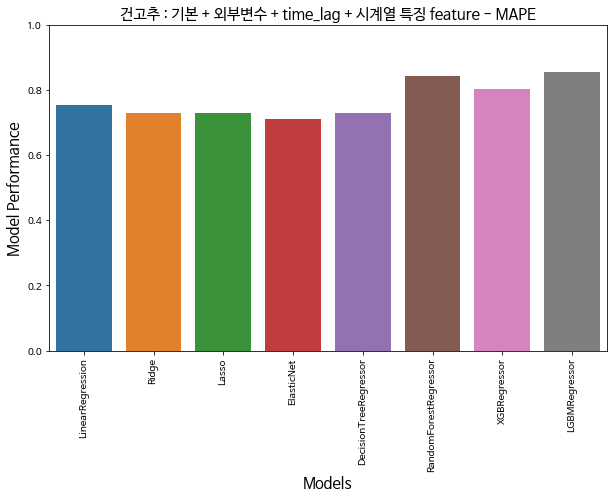

In [ ]:
# go10 = 거래건수별 mean_price가 5만원이 넘는 경우 drop

modeling1(go10, '건고추')
modeling2(go10, '건고추')
modeling3(go10, '건고추')
modeling4(go10, '건고추')
modeling5(go10, '건고추')
modeling6(go10, '건고추')
modeling7(go10, '건고추')
modeling8(go10, '건고추')

# 여전히 3folds에서 값이 크게 나옴.. 왜? -> 추후에 가격대 1~99% 사이로 진행 시 fold사이의 mape값 차이가 크지 않음